### Medium story link (https://medium.com/@denizdoruknuholu/airbnb-in-two-cities-seattle-vs-boston-66fba22fc1c1)

In [1]:
#Make necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
from re import sub
from decimal import Decimal
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize, WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tests as t
import re
import nltk
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Gather the Data

In [2]:
#Read Listing and Calendar files for Boston & Seattle datasets
boston_listings = pd.read_csv('boston/listings.csv')
seattle_listings = pd.read_csv('seattle/listings.csv')
boston_calendar = pd.read_csv('boston/calendar.csv', parse_dates=['date'])
seattle_calendar = pd.read_csv('seattle/calendar.csv', parse_dates=['date'])
boston_review = pd.read_csv('boston/reviews.csv')
seattle_review = pd.read_csv('seattle/reviews.csv')

# Drop columns found in boston dataset that are not in seattle dataset.
boston_drop_columns = [column for column in boston_listings.columns if column not in seattle_listings.columns]

for column in boston_drop_columns:
    boston_listings.drop(column,axis=1,inplace=True)

### Clean the data up

In [3]:
#Clean up the data
#Function converts price in a string in currency format to float
def clean_price(price):
    """Take in a string and return a float without the currency sign"""
    try:
        return float(sub(r'[^\d.]', '', price))
    except:
        return float(price)

seattle_calendar['price'] = seattle_calendar['price'].map(clean_price)
boston_calendar['price'] = boston_calendar['price'].map(clean_price)
seattle_calendar['day_of_year'] = seattle_calendar['date'].map(lambda x: x.timetuple().tm_yday)
boston_calendar['day_of_year'] = boston_calendar['date'].map(lambda x: x.timetuple().tm_yday)
seattle_calendar['available'] = seattle_calendar['available'].apply(lambda x: True if x == 't' else False)
boston_calendar['available'] = boston_calendar['available'].apply(lambda x: True if x == 't' else False)
avg_price_day_s = seattle_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_day_b = boston_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_date_s = seattle_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()
avg_price_date_b = boston_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()

### Assess the data

In [4]:
print('The median house price in Boston is ${}'.format(int(boston_calendar['price'].median())))
print('The median house price in Seattle is ${}'.format(int(seattle_calendar['price'].median())))

The median house price in Boston is $150
The median house price in Seattle is $109


### Question 1: How are the pricing of the properties in Boston and Seattle? Do they have seasonality? Are there any events that cause jumps in price?

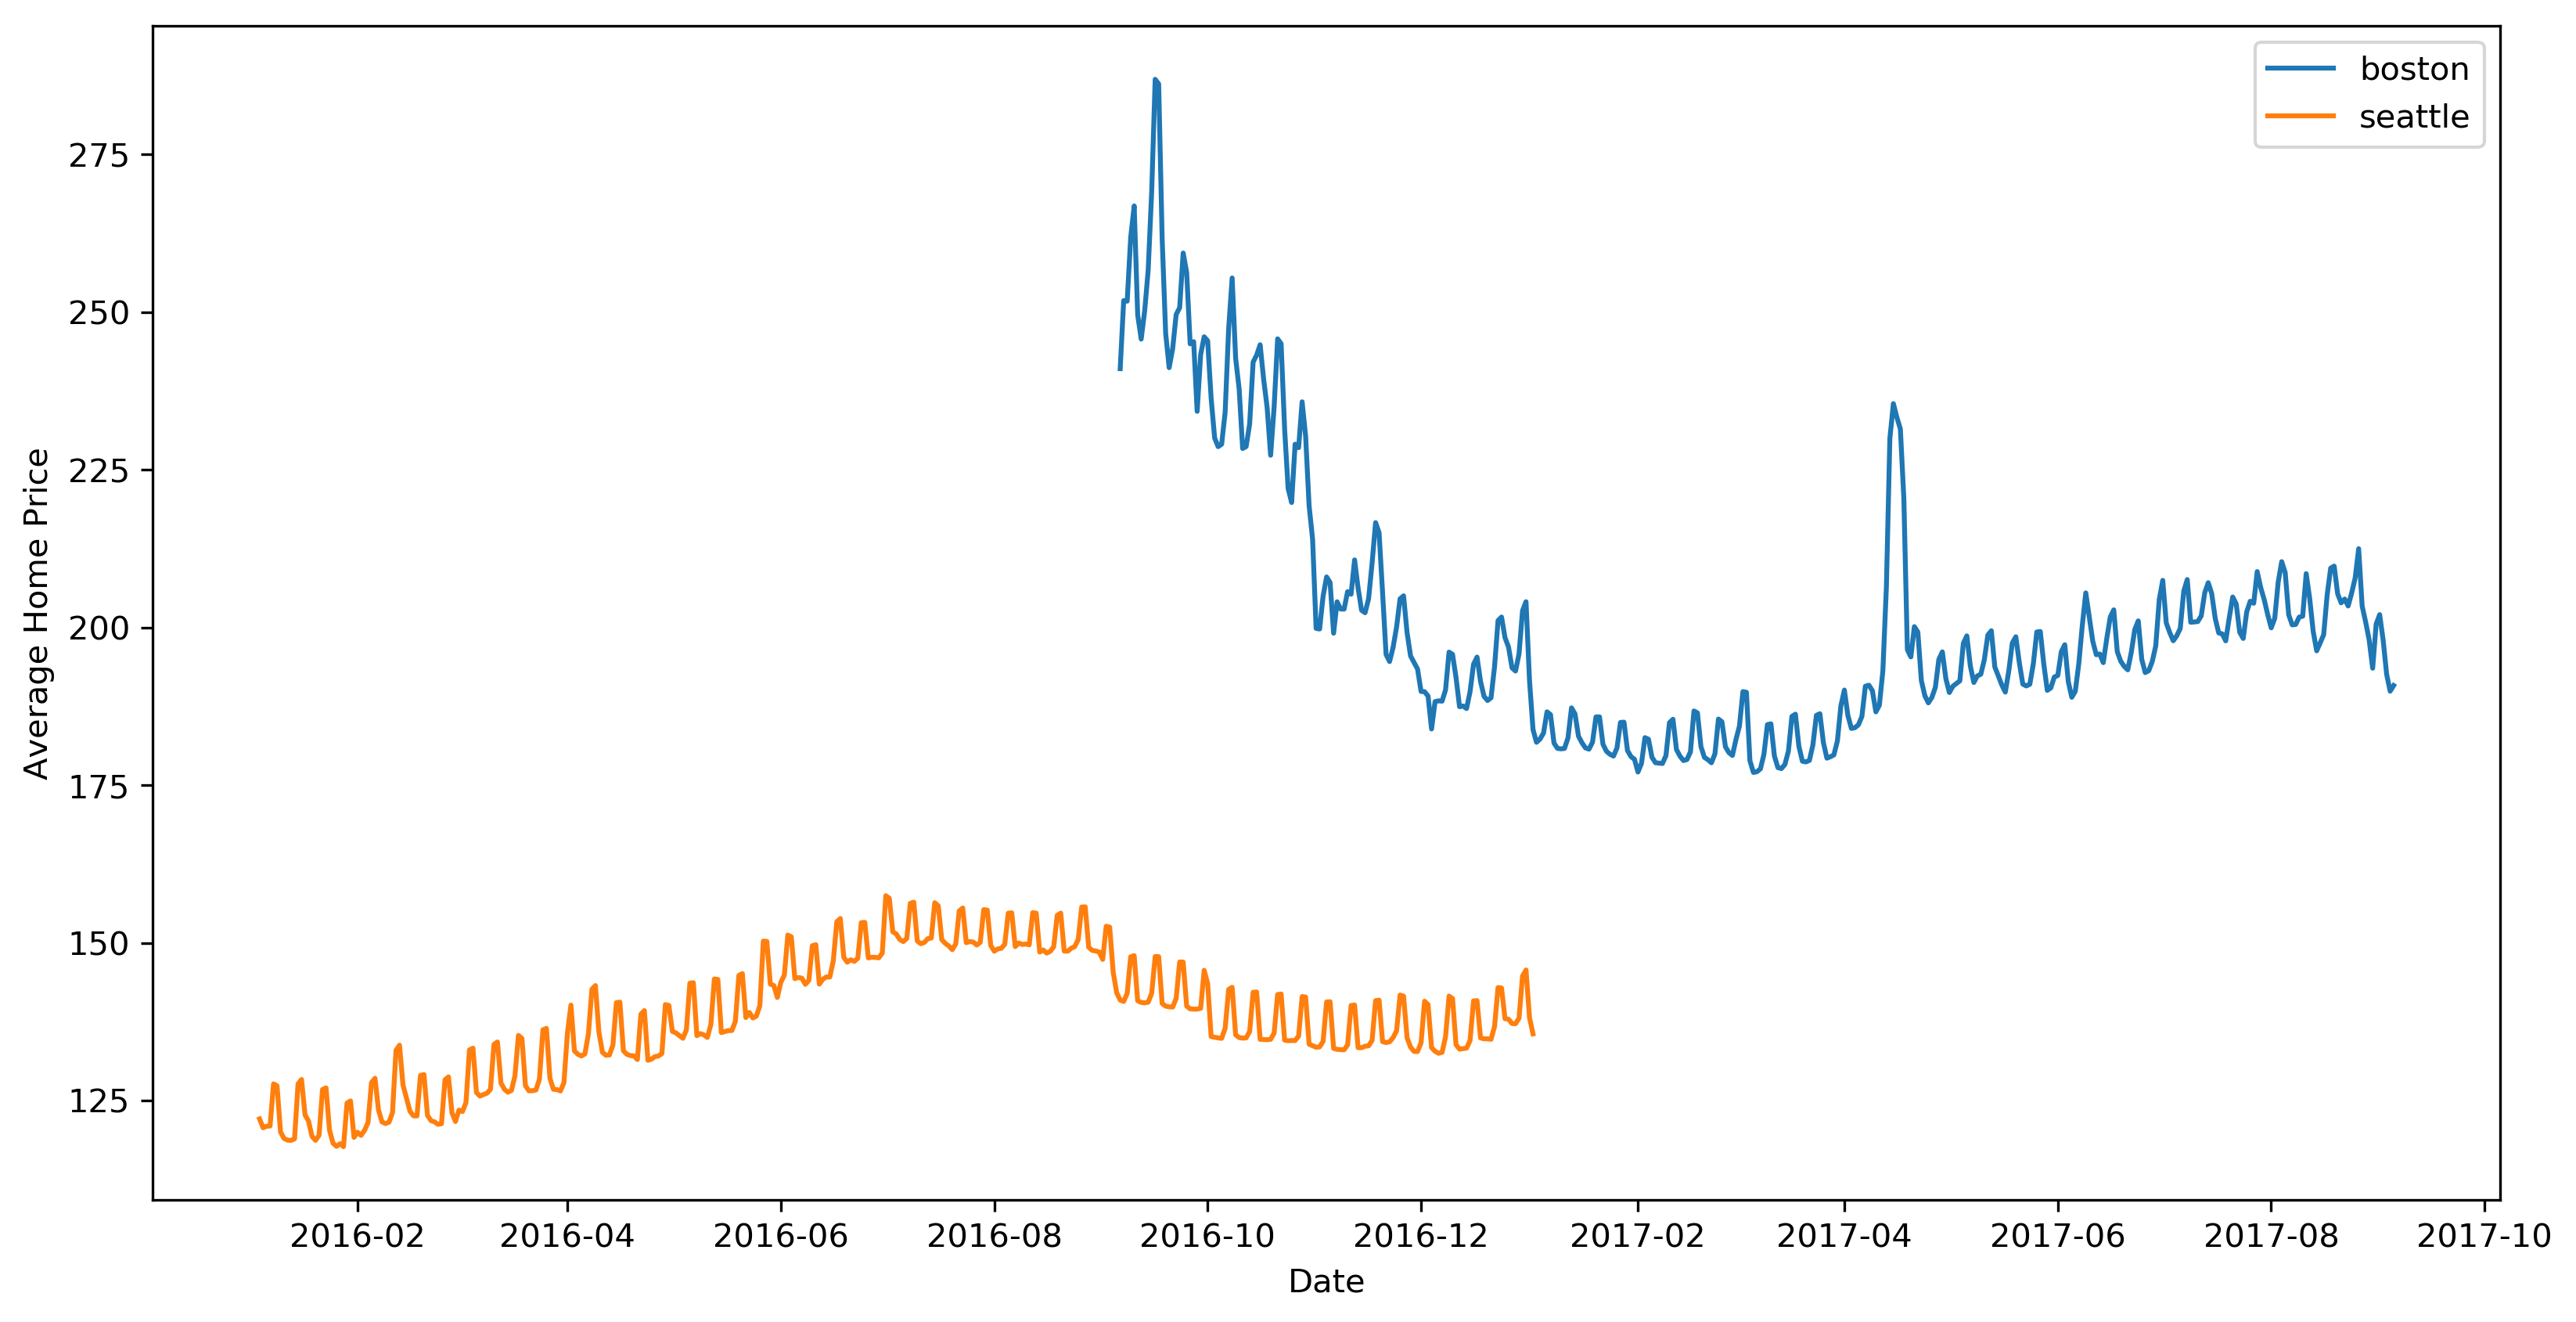

In [5]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(avg_price_date_b['price'], label='boston')
ax.plot(avg_price_date_s['price'], label='seattle')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Average Home Price');
fig.savefig('png\PriceVsDate.png', bbox_inches='tight')

In [6]:
'The average price during the Boston Marathon period in 2017 was ${}'.format(int(avg_price_date_b.loc['2017-04-14':'2017-04-17','price'].mean()))

'The average price during the Boston Marathon period in 2017 was $232'

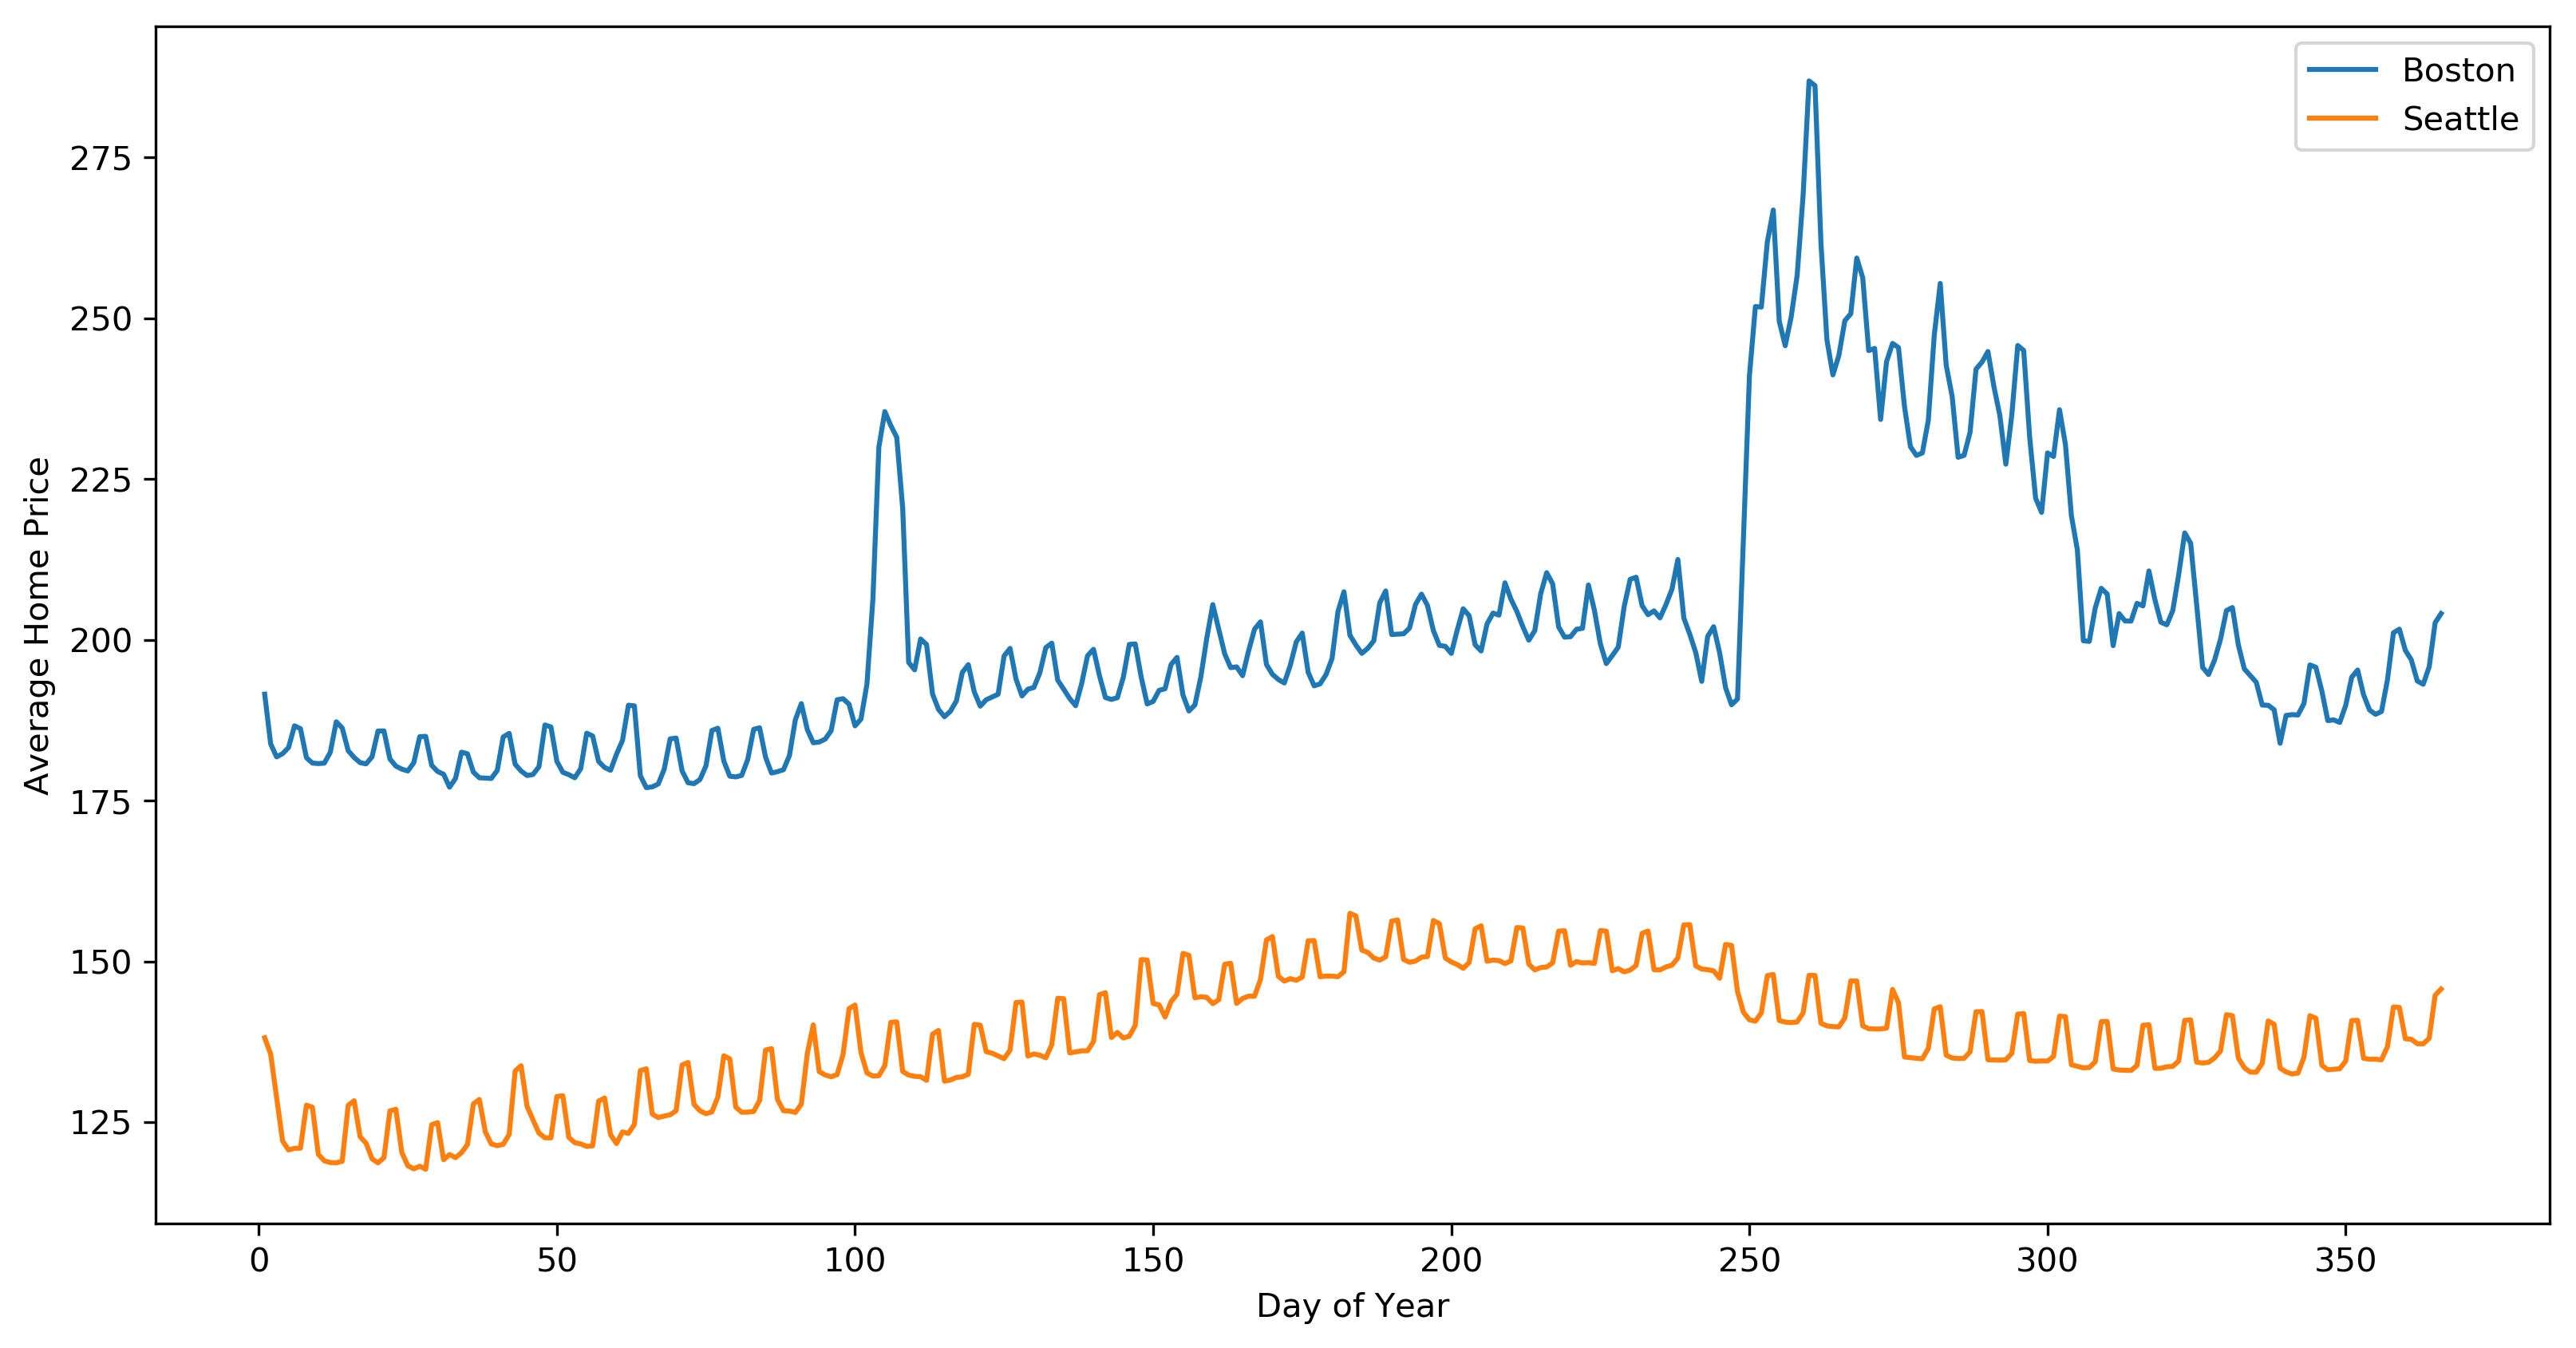

In [7]:
fig2 = plt.figure(figsize=(10,5),dpi=300)
ax2 = fig2.add_axes([0,0,1,1])
ax2.plot(avg_price_day_b['price'], label='Boston')
ax2.plot(avg_price_day_s['price'], label='Seattle');
ax2.legend()
ax2.set_xlabel('Day of Year')
ax2.set_ylabel('Average Home Price')
fig2.savefig('png\PricevsDay.png', bbox_inches='tight')

### Question 2: How is the availability of the properties in both cities throughout the year

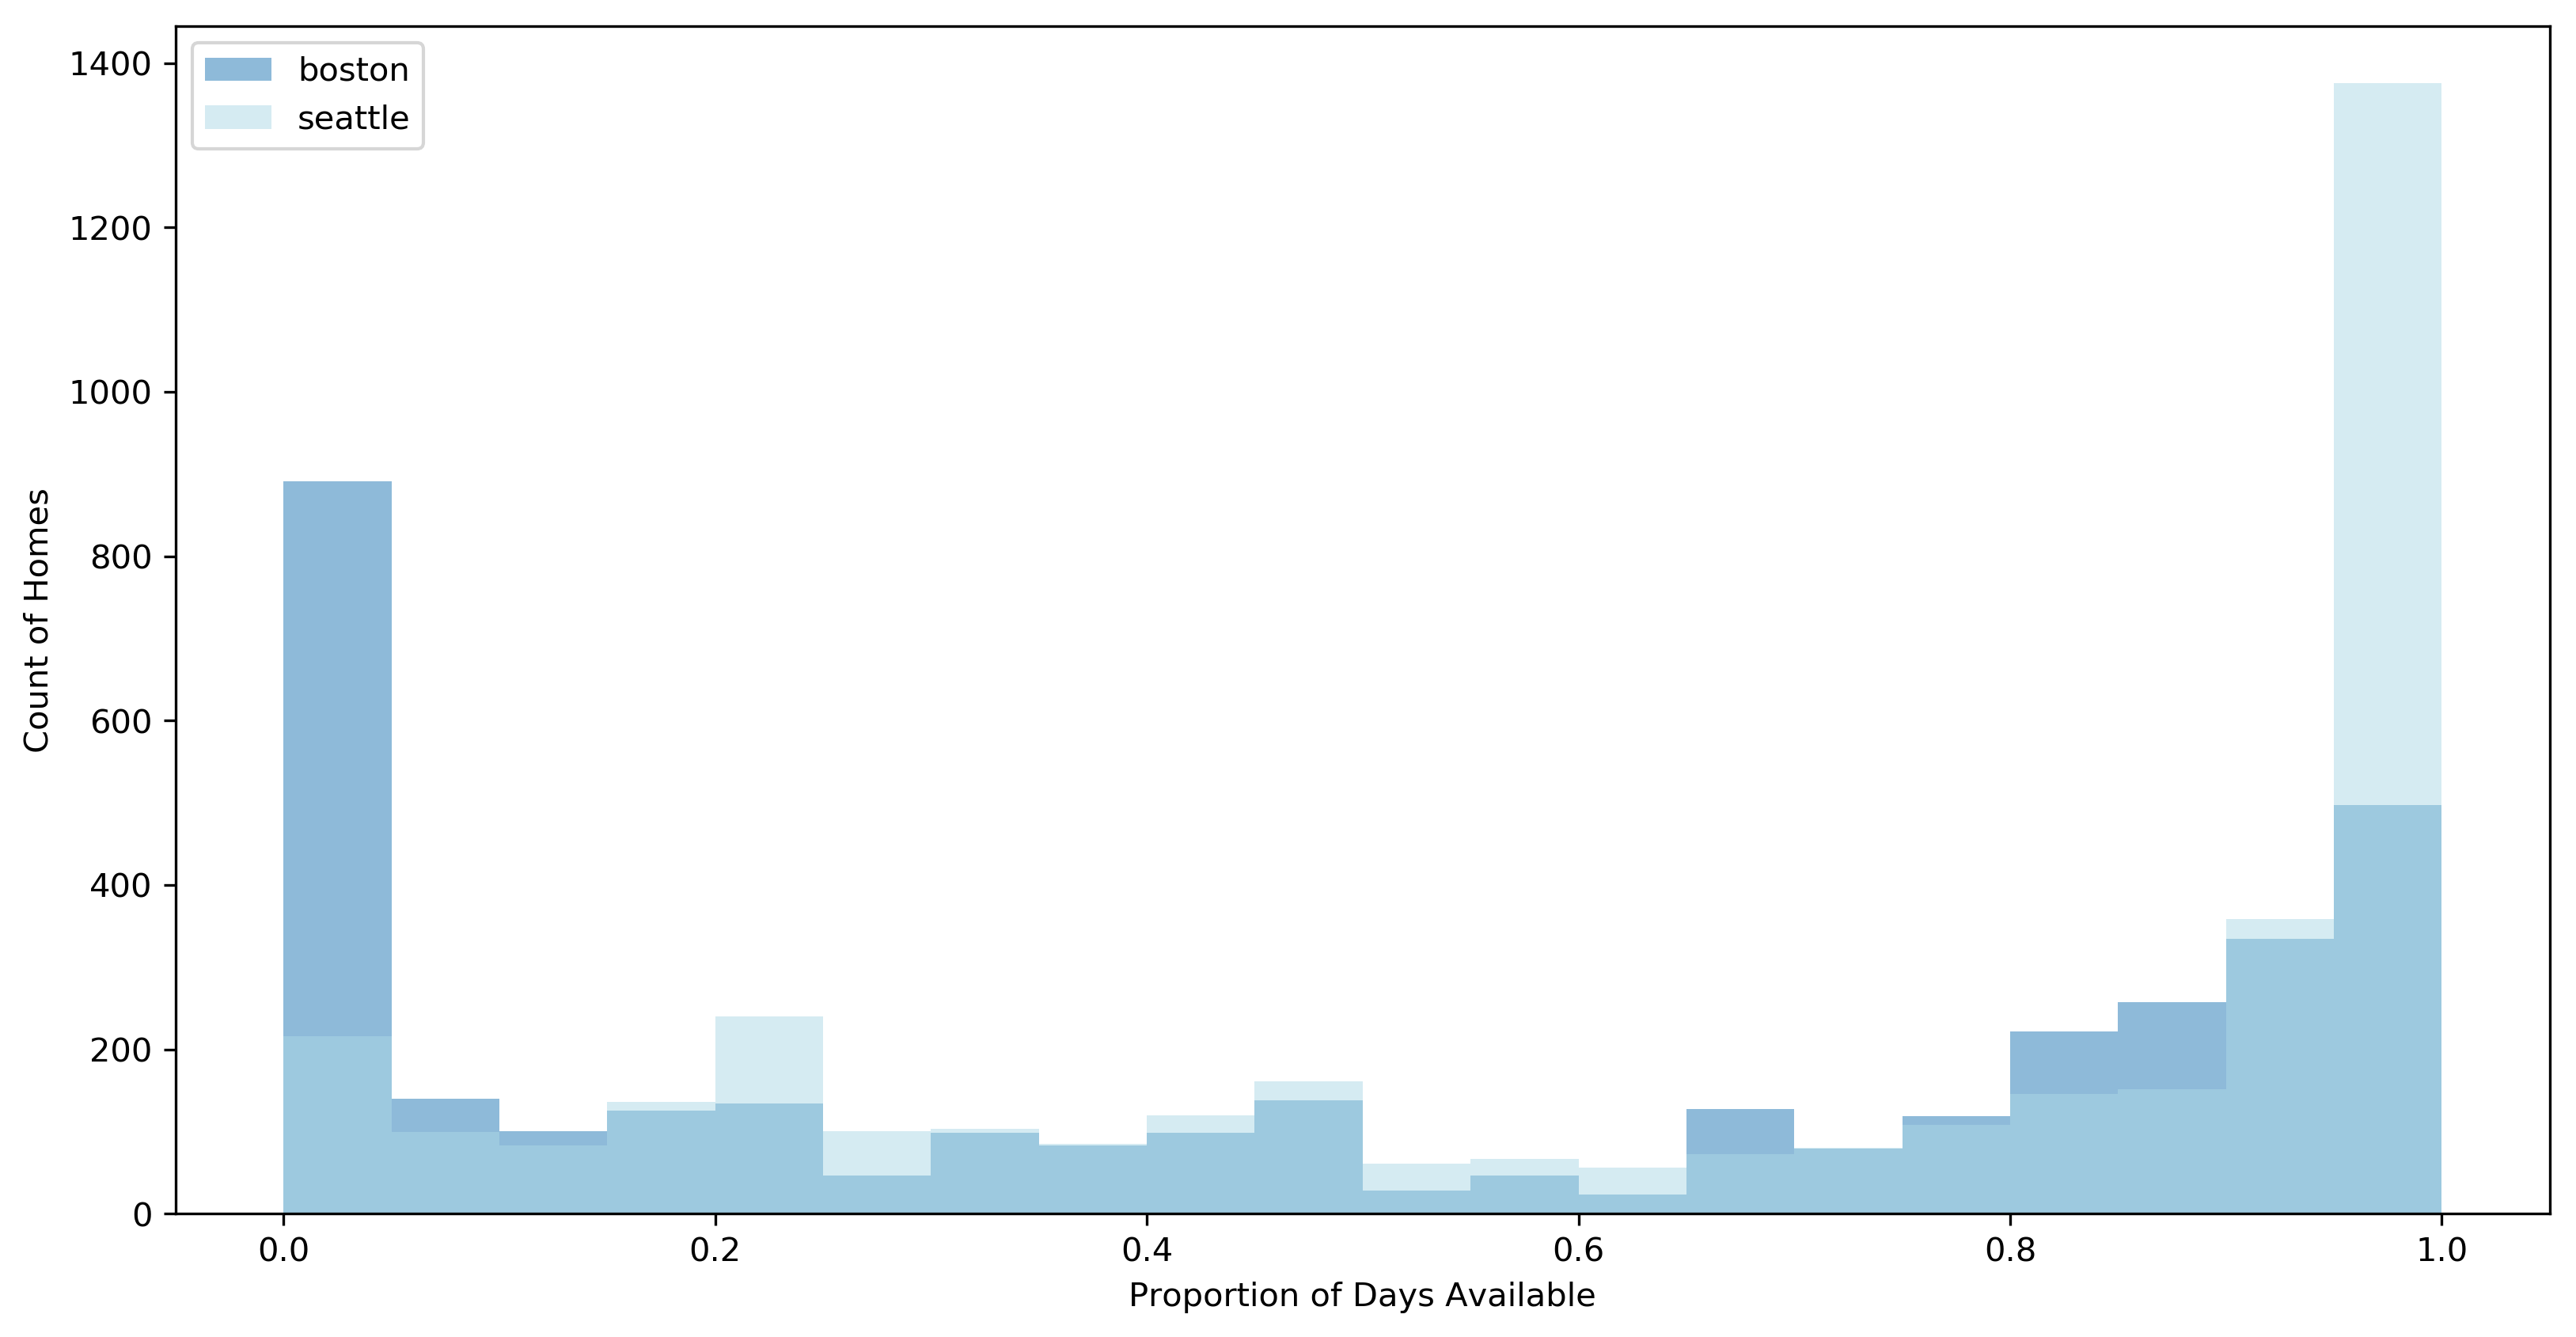

In [8]:
fig3 = plt.figure(figsize=(10,5),dpi=300)
ax3 = fig3.add_axes([0,0,1,1])
ax3.hist(boston_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='boston');
ax3.hist(seattle_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='seattle', color='lightblue')
ax3.legend()
ax3.set_xlabel('Proportion of Days Available')
ax3.set_ylabel('Count of Homes')
fig3.savefig('png\PropDaysAvailable.png', bbox_inches='tight')

In [9]:
'In Boston, at any given time, there is a %{} chance that a house is available, while in Seattle this figure is much higher at %{}'.format(int(boston_calendar['available'].mean()*100), int(seattle_calendar['available'].mean()*100))

'In Boston, at any given time, there is a %49 chance that a house is available, while in Seattle this figure is much higher at %67'

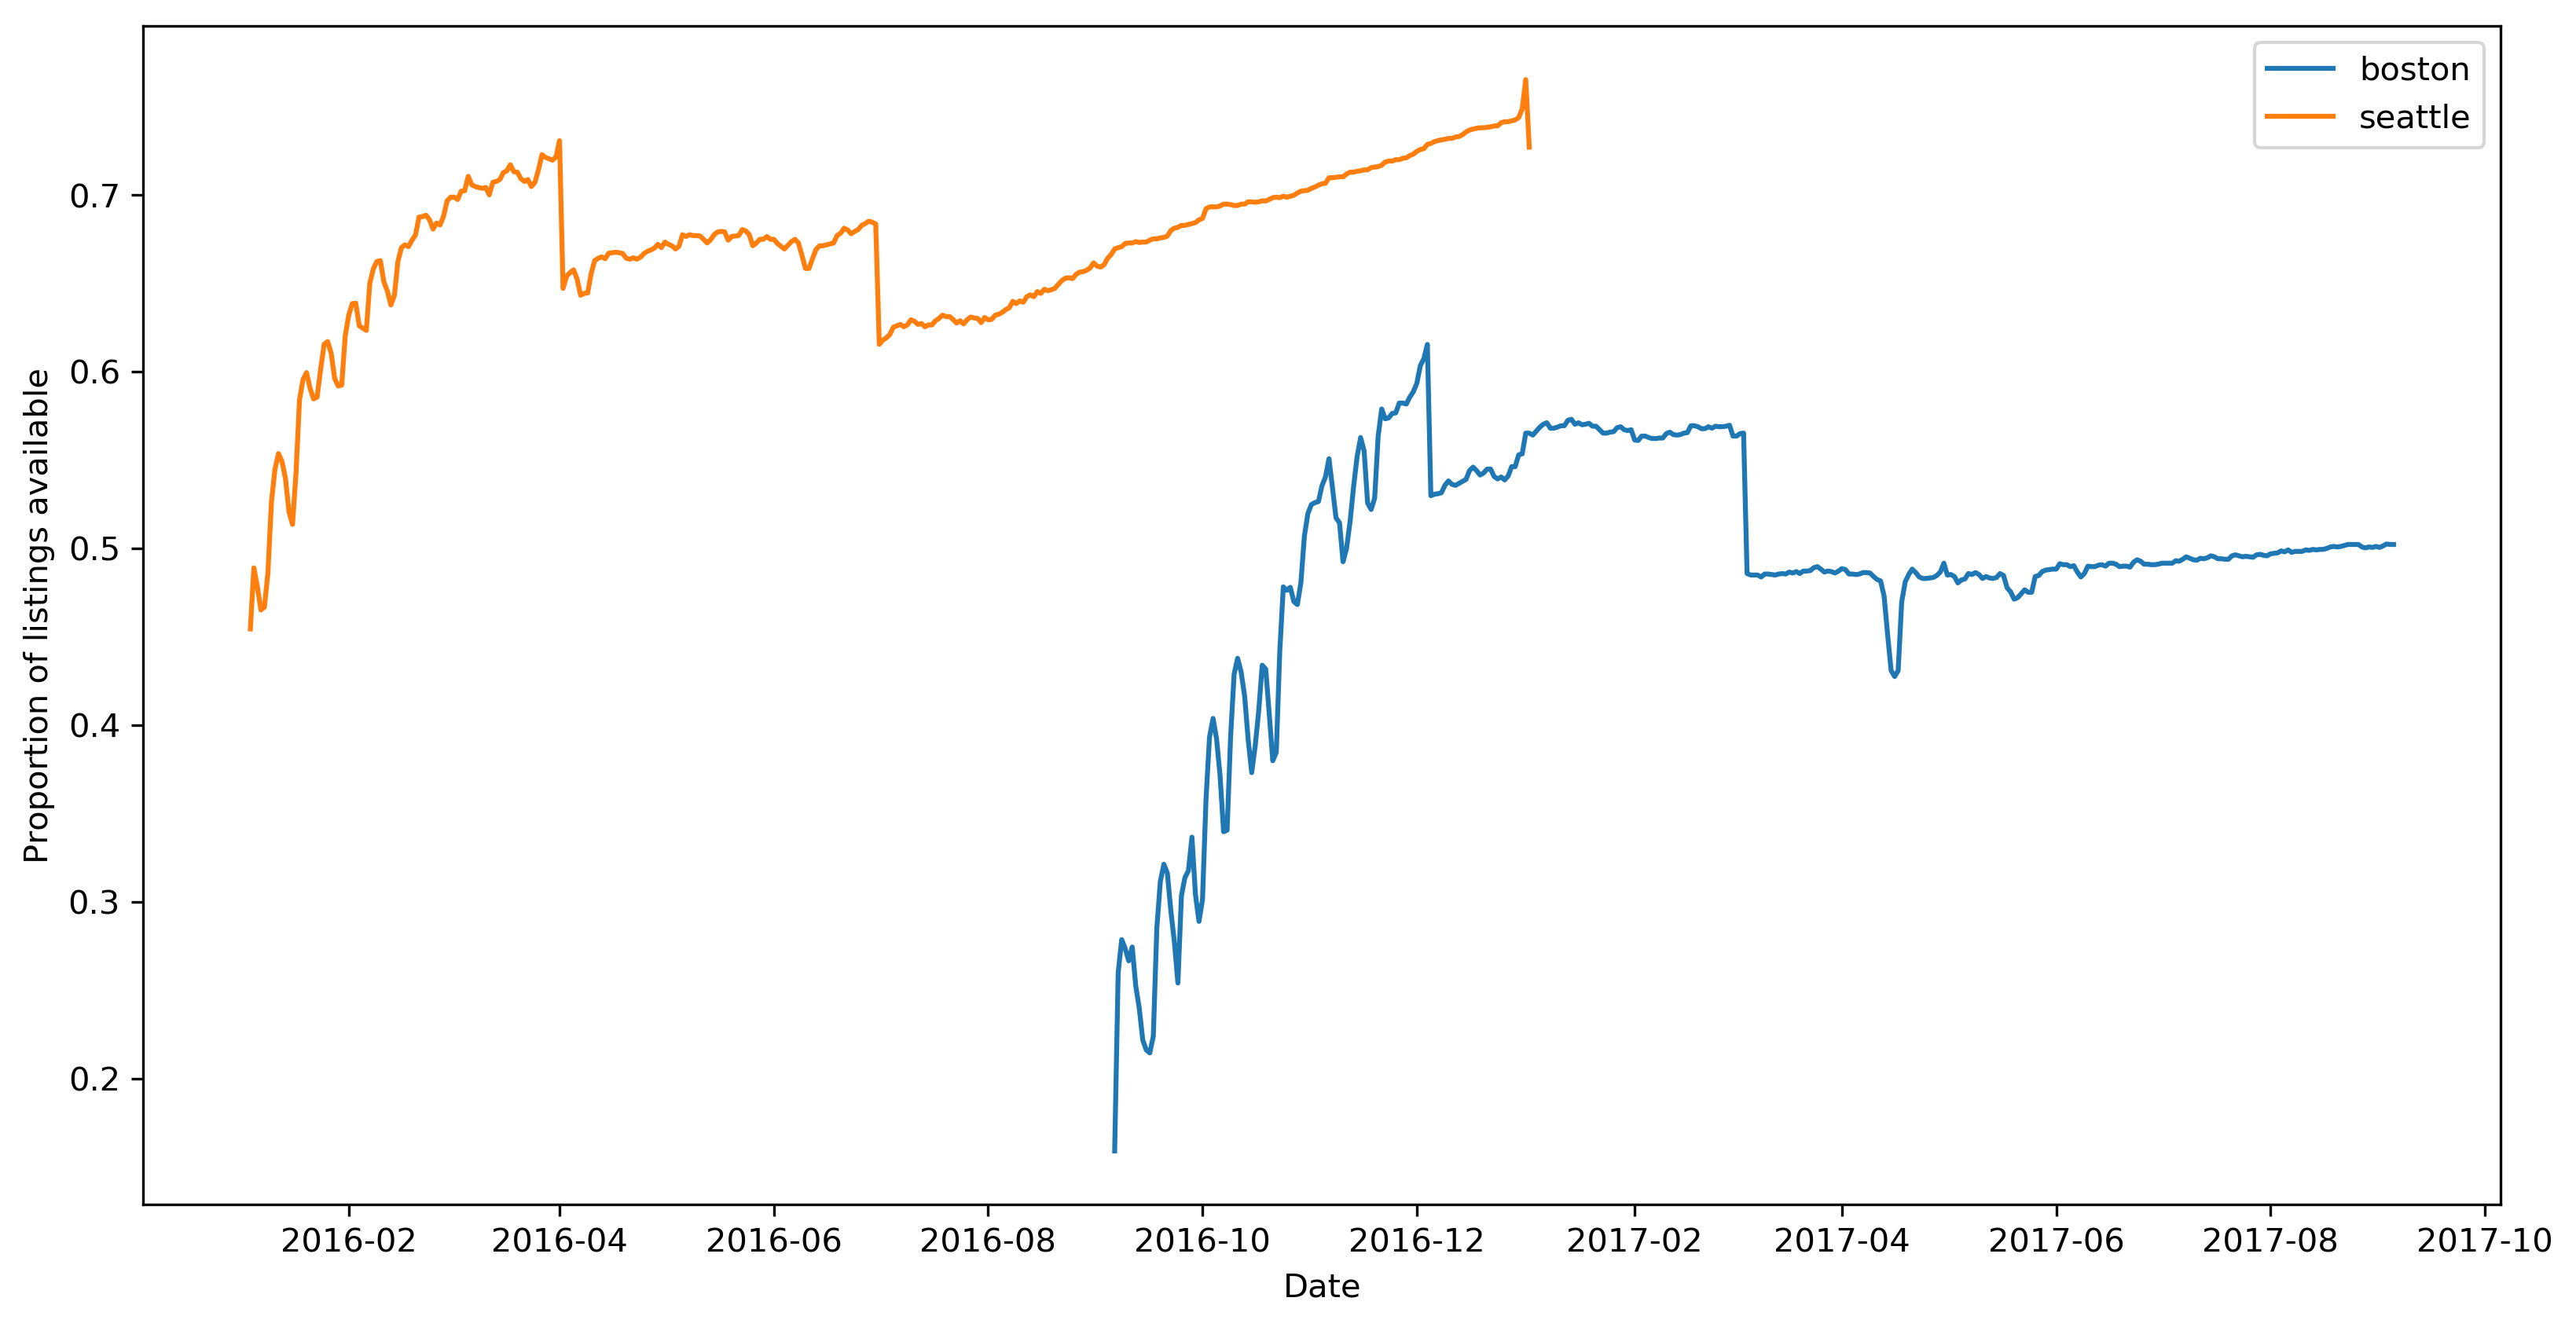

In [10]:
fig4 = plt.figure(figsize=(10,5),dpi=300)
ax4 = fig4.add_axes([0,0,1,1])
ax4.plot(boston_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='boston')
ax4.plot(seattle_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='seattle')
ax4.legend()
ax4.set_xlabel('Date')
ax4.set_ylabel('Proportion of listings available')
fig4.savefig('png\ListingsAvailableByDate.png', bbox_inches='tight')

### Question 3: Can we predict the review score from comments using regression? Do the comments of the visitors on a listing give us enough information for us to guess the review score of that listing

####  Create a reviews dataframe that concatenates all review strings into one per listing. Boston and Seattle data are also merged into one.

#### I will be dropping any reviews that have an NA value in either comments or scores for simplicity.

In [11]:
reviews = pd.DataFrame(columns=['comments'])

for item in seattle_review['listing_id'].unique():
        reviews.loc[item,'comments'] = seattle_review[seattle_review['listing_id']==item]['comments'].str.cat()

for item in boston_review['listing_id'].unique():
        reviews.loc[item,'comments'] = boston_review[boston_review['listing_id']==item]['comments'].str.cat()
        
review_score_rating = pd.concat([seattle_listings.loc[:,['id','review_scores_rating']],boston_listings.loc[:,['id','review_scores_rating']]])
reviews['review_scores_rating'] = reviews.index.map(review_score_rating.set_index('id')['review_scores_rating'])
reviews.dropna(inplace=True)

In [12]:
def preprocessor(text):
    """Takes in text, removes punctuation and returns it"""
    text = re.sub(r"[^a-zA-Z0-9]"," ", text)
    text = re.sub(r"'","", text)
    return text

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Define tokenizer, splitting text into tokens, while also removing stopwords, applying stemming and lemmatization as well
def tokenizer(text):
    """Splits text into tokens, removes stopwords, lemmatizes and stems, then returns resulting tokens"""
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens]
    return tokens

#Initialize Vectorizers
CV = CountVectorizer(stop_words=None, tokenizer=tokenizer, preprocessor=preprocessor, lowercase=True)
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, lowercase=True)

### Start TFIDF Vectorizer & Cross Validation Code (Analyze & Model)

In [13]:
#Initialize TFIDF Vectorizer with custom preprocessor and tokenizer
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, max_features=1000)

#Create intermediate set which contains our train and validation sets, as well as
X_intermediate, X_test, y_intermediate, y_test = train_test_split(reviews['comments'], reviews['review_scores_rating'],
                                                                  shuffle=True,
                                                                  test_size=0.2)
#Set alphas and learning_rates to GridSearch upon for SGDR, XGBR and CatBoostReg
alphas = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
learning_rates = [1,0.1,0.01,0.001,0.0001,0.00001,0.000001]

kf = KFold(3, shuffle=True, random_state=21)

train_errors_sgdr = {a:[] for a in alphas}
val_errors_sgdr = {a:[] for a in alphas}
train_errors_xgb = {n:[] for n in learning_rates}
val_errors_xgb = {n:[] for n in learning_rates}
train_errors_cat = {n:[] for n in learning_rates}
val_errors_cat = {n:[] for n in learning_rates}


for train_index, val_index in kf.split(X_intermediate, y_intermediate):
    
    X_train, X_val = X_intermediate[X_intermediate.index[train_index]], X_intermediate[X_intermediate.index[val_index]]
    y_train, y_val = y_intermediate[y_intermediate.index[train_index]], y_intermediate[y_intermediate.index[val_index]]
    
    X_train = pd.DataFrame(TFIDF.fit_transform(X_train).toarray(), X_train.index)
    X_val = pd.DataFrame(TFIDF.transform(X_val).toarray(), X_val.index)
    
    #Stochastic Gradient Descent
    for alpha in alphas:
        #instantiate Stochastic Gradient Descent model and fit it
        sgdr = SGDRegressor(alpha=alpha, random_state=21).fit(X_train, y_train)
    
        #calculate errors
        yhat_train = sgdr.predict(X_train)
        yhat_val = sgdr.predict(X_val)
        train_error, val_error = mean_squared_error(y_train, yhat_train), mean_squared_error(y_val, yhat_val)
        train_errors_sgdr[alpha].append(train_error)
        val_errors_sgdr[alpha].append(val_error)
    
    for lr in learning_rates:
        
        # CatBoost Regressor
        cat = CatBoostRegressor(learning_rate=lr,random_seed=21,thread_count=4).fit(X_train, y_train)
        train_error_cat, val_error_cat = mean_squared_error(cat.predict(X_train), y_train), mean_squared_error(cat.predict(X_val), y_val)
        train_errors_cat[lr].append(train_error_cat)
        val_errors_cat[lr].append(val_error_cat)
        
        # XGBoost Regressor
        xgb = XGBRegressor(learning_rate=lr,random_seed=21,n_jobs=-1).fit(X_train, y_train)
        train_error_xgb, val_error_xgb = mean_squared_error(xgb.predict(X_train), y_train), mean_squared_error(xgb.predict(X_val), y_val)
        train_errors_xgb[lr].append(train_error_xgb)
        val_errors_xgb[lr].append(val_error_xgb)

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0:	learn: 9.9516472	total: 498ms	remaining: 8m 17s
1:	learn: 9.0717533	total: 812ms	remaining: 6m 45s
2:	learn: 8.9392522	total: 1.12s	remaining: 6m 12s
3:	learn: 8.6080953	total: 1.43s	remaining: 5m 56s
4:	learn: 8.4357476	total: 1.74s	remaining: 5m 46s
5:	learn: 8.2734945	total: 2.05s	remaining: 5m 39s
6:	learn: 8.1631177	total: 2.35s	remaining: 5m 33s
7:	learn: 8.0705026	total: 2.65s	remaining: 5m 29s
8:	learn: 7.8826288	total: 2.96s	remaining: 5m 26s
9:	learn: 7.7985714	total: 3.27s	remaining: 5m 23s
10:	learn: 7.7126039	total: 3.57s	remaining: 5m 21s
11:	learn: 7.6612157	total: 3.87s	remaining: 5m 18s
12:	learn: 7.6134344	total: 4.18s	remaining: 5m 17s
13:	learn: 7.2229712	total: 4.49s	remaining: 5m 16s
14:	learn: 7.0589977	total: 4.8s	remaining: 5m 15s
15:	learn: 6.9098034	total: 5.12s	remaining: 5m 14s
16:	learn: 6.8812313	total: 5.43s	remaining: 5m 14s
17:	learn: 6.8725341	total: 5.73s	remaining: 5m 12s
18:	learn: 6.8561177	total: 6.04s	remaining: 5m 11s
19:	learn: 6.7936876	to

158:	learn: 4.6501182	total: 48.8s	remaining: 4m 18s
159:	learn: 4.6483833	total: 49.1s	remaining: 4m 17s
160:	learn: 4.6436744	total: 49.4s	remaining: 4m 17s
161:	learn: 4.6406619	total: 49.7s	remaining: 4m 17s
162:	learn: 4.6399101	total: 50s	remaining: 4m 16s
163:	learn: 4.6361465	total: 50.3s	remaining: 4m 16s
164:	learn: 4.6339928	total: 50.6s	remaining: 4m 16s
165:	learn: 4.6222244	total: 50.9s	remaining: 4m 15s
166:	learn: 4.6113284	total: 51.2s	remaining: 4m 15s
167:	learn: 4.6039569	total: 51.5s	remaining: 4m 15s
168:	learn: 4.6006042	total: 51.8s	remaining: 4m 14s
169:	learn: 4.5923422	total: 52.1s	remaining: 4m 14s
170:	learn: 4.5897661	total: 52.4s	remaining: 4m 14s
171:	learn: 4.5848758	total: 52.8s	remaining: 4m 13s
172:	learn: 4.5799928	total: 53.1s	remaining: 4m 13s
173:	learn: 4.5779084	total: 53.4s	remaining: 4m 13s
174:	learn: 4.5763463	total: 53.7s	remaining: 4m 12s
175:	learn: 4.5689925	total: 54s	remaining: 4m 12s
176:	learn: 4.5610789	total: 54.3s	remaining: 4m 1

313:	learn: 3.8411435	total: 1m 35s	remaining: 3m 29s
314:	learn: 3.8365324	total: 1m 36s	remaining: 3m 29s
315:	learn: 3.8331855	total: 1m 36s	remaining: 3m 29s
316:	learn: 3.8302616	total: 1m 36s	remaining: 3m 28s
317:	learn: 3.8259950	total: 1m 37s	remaining: 3m 28s
318:	learn: 3.8238680	total: 1m 37s	remaining: 3m 28s
319:	learn: 3.8167625	total: 1m 37s	remaining: 3m 27s
320:	learn: 3.8118884	total: 1m 38s	remaining: 3m 27s
321:	learn: 3.8080093	total: 1m 38s	remaining: 3m 27s
322:	learn: 3.8072725	total: 1m 38s	remaining: 3m 26s
323:	learn: 3.8014429	total: 1m 39s	remaining: 3m 26s
324:	learn: 3.7969930	total: 1m 39s	remaining: 3m 26s
325:	learn: 3.7960142	total: 1m 39s	remaining: 3m 26s
326:	learn: 3.7934396	total: 1m 39s	remaining: 3m 25s
327:	learn: 3.7923694	total: 1m 40s	remaining: 3m 25s
328:	learn: 3.7914671	total: 1m 40s	remaining: 3m 25s
329:	learn: 3.7866426	total: 1m 40s	remaining: 3m 24s
330:	learn: 3.7796432	total: 1m 41s	remaining: 3m 24s
331:	learn: 3.7726044	total:

467:	learn: 3.3969206	total: 2m 22s	remaining: 2m 42s
468:	learn: 3.3957034	total: 2m 23s	remaining: 2m 42s
469:	learn: 3.3920885	total: 2m 23s	remaining: 2m 41s
470:	learn: 3.3896785	total: 2m 23s	remaining: 2m 41s
471:	learn: 3.3877817	total: 2m 24s	remaining: 2m 41s
472:	learn: 3.3833499	total: 2m 24s	remaining: 2m 40s
473:	learn: 3.3810475	total: 2m 24s	remaining: 2m 40s
474:	learn: 3.3749123	total: 2m 25s	remaining: 2m 40s
475:	learn: 3.3726357	total: 2m 25s	remaining: 2m 39s
476:	learn: 3.3715263	total: 2m 25s	remaining: 2m 39s
477:	learn: 3.3698053	total: 2m 25s	remaining: 2m 39s
478:	learn: 3.3652527	total: 2m 26s	remaining: 2m 39s
479:	learn: 3.3646062	total: 2m 26s	remaining: 2m 38s
480:	learn: 3.3642331	total: 2m 26s	remaining: 2m 38s
481:	learn: 3.3591088	total: 2m 27s	remaining: 2m 38s
482:	learn: 3.3575761	total: 2m 27s	remaining: 2m 37s
483:	learn: 3.3531078	total: 2m 27s	remaining: 2m 37s
484:	learn: 3.3525882	total: 2m 28s	remaining: 2m 37s
485:	learn: 3.3518211	total:

621:	learn: 3.0757102	total: 3m 9s	remaining: 1m 55s
622:	learn: 3.0747623	total: 3m 10s	remaining: 1m 55s
623:	learn: 3.0729058	total: 3m 10s	remaining: 1m 54s
624:	learn: 3.0706342	total: 3m 10s	remaining: 1m 54s
625:	learn: 3.0699669	total: 3m 11s	remaining: 1m 54s
626:	learn: 3.0694107	total: 3m 11s	remaining: 1m 53s
627:	learn: 3.0621500	total: 3m 11s	remaining: 1m 53s
628:	learn: 3.0616138	total: 3m 11s	remaining: 1m 53s
629:	learn: 3.0570393	total: 3m 12s	remaining: 1m 52s
630:	learn: 3.0550226	total: 3m 12s	remaining: 1m 52s
631:	learn: 3.0535038	total: 3m 12s	remaining: 1m 52s
632:	learn: 3.0509520	total: 3m 13s	remaining: 1m 52s
633:	learn: 3.0493933	total: 3m 13s	remaining: 1m 51s
634:	learn: 3.0488608	total: 3m 13s	remaining: 1m 51s
635:	learn: 3.0469658	total: 3m 14s	remaining: 1m 51s
636:	learn: 3.0459318	total: 3m 14s	remaining: 1m 50s
637:	learn: 3.0361197	total: 3m 14s	remaining: 1m 50s
638:	learn: 3.0352708	total: 3m 15s	remaining: 1m 50s
639:	learn: 3.0345538	total: 

773:	learn: 2.7931262	total: 3m 56s	remaining: 1m 9s
774:	learn: 2.7927559	total: 3m 57s	remaining: 1m 8s
775:	learn: 2.7914327	total: 3m 57s	remaining: 1m 8s
776:	learn: 2.7902142	total: 3m 57s	remaining: 1m 8s
777:	learn: 2.7887002	total: 3m 58s	remaining: 1m 7s
778:	learn: 2.7879454	total: 3m 58s	remaining: 1m 7s
779:	learn: 2.7853198	total: 3m 58s	remaining: 1m 7s
780:	learn: 2.7847846	total: 3m 58s	remaining: 1m 6s
781:	learn: 2.7841759	total: 3m 59s	remaining: 1m 6s
782:	learn: 2.7834797	total: 3m 59s	remaining: 1m 6s
783:	learn: 2.7821165	total: 3m 59s	remaining: 1m 6s
784:	learn: 2.7809620	total: 4m	remaining: 1m 5s
785:	learn: 2.7780701	total: 4m	remaining: 1m 5s
786:	learn: 2.7759355	total: 4m	remaining: 1m 5s
787:	learn: 2.7741082	total: 4m 1s	remaining: 1m 4s
788:	learn: 2.7728810	total: 4m 1s	remaining: 1m 4s
789:	learn: 2.7725467	total: 4m 1s	remaining: 1m 4s
790:	learn: 2.7711566	total: 4m 1s	remaining: 1m 3s
791:	learn: 2.7694755	total: 4m 2s	remaining: 1m 3s
792:	learn

930:	learn: 2.5909860	total: 4m 44s	remaining: 21.1s
931:	learn: 2.5908257	total: 4m 45s	remaining: 20.8s
932:	learn: 2.5906210	total: 4m 45s	remaining: 20.5s
933:	learn: 2.5898629	total: 4m 45s	remaining: 20.2s
934:	learn: 2.5896900	total: 4m 46s	remaining: 19.9s
935:	learn: 2.5876278	total: 4m 46s	remaining: 19.6s
936:	learn: 2.5871979	total: 4m 46s	remaining: 19.3s
937:	learn: 2.5852085	total: 4m 46s	remaining: 19s
938:	learn: 2.5839010	total: 4m 47s	remaining: 18.7s
939:	learn: 2.5830969	total: 4m 47s	remaining: 18.4s
940:	learn: 2.5815650	total: 4m 47s	remaining: 18.1s
941:	learn: 2.5791425	total: 4m 48s	remaining: 17.7s
942:	learn: 2.5789343	total: 4m 48s	remaining: 17.4s
943:	learn: 2.5732820	total: 4m 48s	remaining: 17.1s
944:	learn: 2.5717668	total: 4m 49s	remaining: 16.8s
945:	learn: 2.5706234	total: 4m 49s	remaining: 16.5s
946:	learn: 2.5703622	total: 4m 49s	remaining: 16.2s
947:	learn: 2.5699942	total: 4m 50s	remaining: 15.9s
948:	learn: 2.5674743	total: 4m 50s	remaining: 1

88:	learn: 5.8707082	total: 27.5s	remaining: 4m 41s
89:	learn: 5.8310997	total: 27.8s	remaining: 4m 41s
90:	learn: 5.8155629	total: 28.1s	remaining: 4m 40s
91:	learn: 5.8006400	total: 28.4s	remaining: 4m 40s
92:	learn: 5.7819798	total: 28.7s	remaining: 4m 40s
93:	learn: 5.7364939	total: 29s	remaining: 4m 39s
94:	learn: 5.7182660	total: 29.3s	remaining: 4m 39s
95:	learn: 5.6917787	total: 29.6s	remaining: 4m 39s
96:	learn: 5.6699093	total: 29.9s	remaining: 4m 38s
97:	learn: 5.6296035	total: 30.3s	remaining: 4m 38s
98:	learn: 5.6088485	total: 30.6s	remaining: 4m 38s
99:	learn: 5.5895205	total: 30.9s	remaining: 4m 37s
100:	learn: 5.5833418	total: 31.2s	remaining: 4m 37s
101:	learn: 5.5530617	total: 31.5s	remaining: 4m 37s
102:	learn: 5.5447732	total: 31.8s	remaining: 4m 36s
103:	learn: 5.5357562	total: 32.1s	remaining: 4m 36s
104:	learn: 5.5196999	total: 32.4s	remaining: 4m 36s
105:	learn: 5.5016942	total: 32.7s	remaining: 4m 35s
106:	learn: 5.4917447	total: 33s	remaining: 4m 35s
107:	lear

244:	learn: 4.4451588	total: 1m 15s	remaining: 3m 51s
245:	learn: 4.4443800	total: 1m 15s	remaining: 3m 51s
246:	learn: 4.4380595	total: 1m 15s	remaining: 3m 51s
247:	learn: 4.4359021	total: 1m 16s	remaining: 3m 50s
248:	learn: 4.4348856	total: 1m 16s	remaining: 3m 50s
249:	learn: 4.4320401	total: 1m 16s	remaining: 3m 50s
250:	learn: 4.4295928	total: 1m 16s	remaining: 3m 49s
251:	learn: 4.4282273	total: 1m 17s	remaining: 3m 49s
252:	learn: 4.4212499	total: 1m 17s	remaining: 3m 49s
253:	learn: 4.4197443	total: 1m 17s	remaining: 3m 48s
254:	learn: 4.4178814	total: 1m 18s	remaining: 3m 48s
255:	learn: 4.4157427	total: 1m 18s	remaining: 3m 48s
256:	learn: 4.4110441	total: 1m 18s	remaining: 3m 47s
257:	learn: 4.4086479	total: 1m 19s	remaining: 3m 47s
258:	learn: 4.4056819	total: 1m 19s	remaining: 3m 47s
259:	learn: 4.4048915	total: 1m 19s	remaining: 3m 46s
260:	learn: 4.4026830	total: 1m 20s	remaining: 3m 46s
261:	learn: 4.4017097	total: 1m 20s	remaining: 3m 46s
262:	learn: 4.3995813	total:

397:	learn: 4.1022699	total: 2m 1s	remaining: 3m 4s
398:	learn: 4.1013191	total: 2m 2s	remaining: 3m 4s
399:	learn: 4.1010266	total: 2m 2s	remaining: 3m 3s
400:	learn: 4.1006270	total: 2m 2s	remaining: 3m 3s
401:	learn: 4.0977642	total: 2m 3s	remaining: 3m 3s
402:	learn: 4.0976926	total: 2m 3s	remaining: 3m 2s
403:	learn: 4.0972591	total: 2m 3s	remaining: 3m 2s
404:	learn: 4.0956424	total: 2m 3s	remaining: 3m 2s
405:	learn: 4.0943189	total: 2m 4s	remaining: 3m 1s
406:	learn: 4.0906879	total: 2m 4s	remaining: 3m 1s
407:	learn: 4.0895243	total: 2m 4s	remaining: 3m 1s
408:	learn: 4.0856504	total: 2m 5s	remaining: 3m
409:	learn: 4.0852350	total: 2m 5s	remaining: 3m
410:	learn: 4.0837144	total: 2m 5s	remaining: 3m
411:	learn: 4.0803224	total: 2m 6s	remaining: 2m 59s
412:	learn: 4.0785819	total: 2m 6s	remaining: 2m 59s
413:	learn: 4.0682679	total: 2m 6s	remaining: 2m 59s
414:	learn: 4.0617091	total: 2m 7s	remaining: 2m 59s
415:	learn: 4.0612453	total: 2m 7s	remaining: 2m 58s
416:	learn: 4.05

550:	learn: 3.8739764	total: 2m 48s	remaining: 2m 17s
551:	learn: 3.8735190	total: 2m 48s	remaining: 2m 16s
552:	learn: 3.8728515	total: 2m 48s	remaining: 2m 16s
553:	learn: 3.8720328	total: 2m 49s	remaining: 2m 16s
554:	learn: 3.8712219	total: 2m 49s	remaining: 2m 15s
555:	learn: 3.8705604	total: 2m 49s	remaining: 2m 15s
556:	learn: 3.8702163	total: 2m 50s	remaining: 2m 15s
557:	learn: 3.8698678	total: 2m 50s	remaining: 2m 14s
558:	learn: 3.8697757	total: 2m 50s	remaining: 2m 14s
559:	learn: 3.8659111	total: 2m 50s	remaining: 2m 14s
560:	learn: 3.8656554	total: 2m 51s	remaining: 2m 14s
561:	learn: 3.8655711	total: 2m 51s	remaining: 2m 13s
562:	learn: 3.8651018	total: 2m 51s	remaining: 2m 13s
563:	learn: 3.8645940	total: 2m 52s	remaining: 2m 13s
564:	learn: 3.8608656	total: 2m 52s	remaining: 2m 12s
565:	learn: 3.8597644	total: 2m 52s	remaining: 2m 12s
566:	learn: 3.8583424	total: 2m 53s	remaining: 2m 12s
567:	learn: 3.8579808	total: 2m 53s	remaining: 2m 11s
568:	learn: 3.8572653	total:

704:	learn: 3.7311529	total: 3m 35s	remaining: 1m 30s
705:	learn: 3.7308225	total: 3m 35s	remaining: 1m 29s
706:	learn: 3.7281513	total: 3m 35s	remaining: 1m 29s
707:	learn: 3.7239394	total: 3m 36s	remaining: 1m 29s
708:	learn: 3.7239225	total: 3m 36s	remaining: 1m 28s
709:	learn: 3.7164317	total: 3m 36s	remaining: 1m 28s
710:	learn: 3.7143083	total: 3m 36s	remaining: 1m 28s
711:	learn: 3.7141168	total: 3m 37s	remaining: 1m 27s
712:	learn: 3.7137830	total: 3m 37s	remaining: 1m 27s
713:	learn: 3.7135269	total: 3m 37s	remaining: 1m 27s
714:	learn: 3.7133606	total: 3m 38s	remaining: 1m 26s
715:	learn: 3.7128017	total: 3m 38s	remaining: 1m 26s
716:	learn: 3.7126287	total: 3m 38s	remaining: 1m 26s
717:	learn: 3.7120541	total: 3m 39s	remaining: 1m 26s
718:	learn: 3.7084361	total: 3m 39s	remaining: 1m 25s
719:	learn: 3.7084182	total: 3m 39s	remaining: 1m 25s
720:	learn: 3.7083663	total: 3m 40s	remaining: 1m 25s
721:	learn: 3.7078450	total: 3m 40s	remaining: 1m 24s
722:	learn: 3.7073925	total:

859:	learn: 3.5854540	total: 4m 22s	remaining: 42.7s
860:	learn: 3.5844227	total: 4m 22s	remaining: 42.4s
861:	learn: 3.5839829	total: 4m 22s	remaining: 42.1s
862:	learn: 3.5823103	total: 4m 23s	remaining: 41.8s
863:	learn: 3.5812096	total: 4m 23s	remaining: 41.5s
864:	learn: 3.5808613	total: 4m 23s	remaining: 41.2s
865:	learn: 3.5808160	total: 4m 24s	remaining: 40.9s
866:	learn: 3.5799018	total: 4m 24s	remaining: 40.6s
867:	learn: 3.5792886	total: 4m 24s	remaining: 40.3s
868:	learn: 3.5783109	total: 4m 25s	remaining: 40s
869:	learn: 3.5777916	total: 4m 25s	remaining: 39.7s
870:	learn: 3.5720296	total: 4m 25s	remaining: 39.4s
871:	learn: 3.5700984	total: 4m 26s	remaining: 39s
872:	learn: 3.5696906	total: 4m 26s	remaining: 38.7s
873:	learn: 3.5696351	total: 4m 26s	remaining: 38.4s
874:	learn: 3.5675686	total: 4m 26s	remaining: 38.1s
875:	learn: 3.5672536	total: 4m 27s	remaining: 37.8s
876:	learn: 3.5671440	total: 4m 27s	remaining: 37.5s
877:	learn: 3.5669242	total: 4m 27s	remaining: 37.

15:	learn: 80.1636441	total: 5.06s	remaining: 5m 11s
16:	learn: 79.3805687	total: 5.37s	remaining: 5m 10s
17:	learn: 78.6119590	total: 5.68s	remaining: 5m 10s
18:	learn: 77.8536081	total: 5.99s	remaining: 5m 9s
19:	learn: 77.0906458	total: 6.3s	remaining: 5m 8s
20:	learn: 76.3424953	total: 6.61s	remaining: 5m 8s
21:	learn: 75.5979943	total: 6.92s	remaining: 5m 7s
22:	learn: 74.8627976	total: 7.23s	remaining: 5m 7s
23:	learn: 74.1358370	total: 7.53s	remaining: 5m 6s
24:	learn: 73.4279885	total: 7.85s	remaining: 5m 5s
25:	learn: 72.7137105	total: 8.16s	remaining: 5m 5s
26:	learn: 72.0148582	total: 8.47s	remaining: 5m 5s
27:	learn: 71.3111020	total: 8.77s	remaining: 5m 4s
28:	learn: 70.6178421	total: 9.08s	remaining: 5m 4s
29:	learn: 69.9324998	total: 9.39s	remaining: 5m 3s
30:	learn: 69.2484733	total: 9.69s	remaining: 5m 2s
31:	learn: 68.5767958	total: 10s	remaining: 5m 2s
32:	learn: 67.9079964	total: 10.3s	remaining: 5m 2s
33:	learn: 67.2559264	total: 10.6s	remaining: 5m 1s
34:	learn: 6

170:	learn: 18.9128289	total: 53.1s	remaining: 4m 17s
171:	learn: 18.7566245	total: 53.4s	remaining: 4m 16s
172:	learn: 18.6024036	total: 53.7s	remaining: 4m 16s
173:	learn: 18.4484551	total: 54s	remaining: 4m 16s
174:	learn: 18.2972042	total: 54.3s	remaining: 4m 15s
175:	learn: 18.1479892	total: 54.6s	remaining: 4m 15s
176:	learn: 18.0005320	total: 54.9s	remaining: 4m 15s
177:	learn: 17.8545576	total: 55.2s	remaining: 4m 15s
178:	learn: 17.7108844	total: 55.5s	remaining: 4m 14s
179:	learn: 17.5682924	total: 55.8s	remaining: 4m 14s
180:	learn: 17.4273191	total: 56.1s	remaining: 4m 14s
181:	learn: 17.2886529	total: 56.5s	remaining: 4m 13s
182:	learn: 17.1520787	total: 56.8s	remaining: 4m 13s
183:	learn: 17.0168682	total: 57.1s	remaining: 4m 13s
184:	learn: 16.8837710	total: 57.4s	remaining: 4m 12s
185:	learn: 16.7520405	total: 57.7s	remaining: 4m 12s
186:	learn: 16.6215154	total: 58s	remaining: 4m 12s
187:	learn: 16.4928427	total: 58.3s	remaining: 4m 11s
188:	learn: 16.3650157	total: 58

323:	learn: 8.1807028	total: 1m 40s	remaining: 3m 30s
324:	learn: 8.1622876	total: 1m 40s	remaining: 3m 29s
325:	learn: 8.1428798	total: 1m 41s	remaining: 3m 29s
326:	learn: 8.1243321	total: 1m 41s	remaining: 3m 29s
327:	learn: 8.1047132	total: 1m 41s	remaining: 3m 28s
328:	learn: 8.0794002	total: 1m 42s	remaining: 3m 28s
329:	learn: 8.0614349	total: 1m 42s	remaining: 3m 28s
330:	learn: 8.0398524	total: 1m 42s	remaining: 3m 27s
331:	learn: 8.0204331	total: 1m 43s	remaining: 3m 27s
332:	learn: 8.0003965	total: 1m 43s	remaining: 3m 27s
333:	learn: 7.9827047	total: 1m 43s	remaining: 3m 26s
334:	learn: 7.9659988	total: 1m 44s	remaining: 3m 26s
335:	learn: 7.9468032	total: 1m 44s	remaining: 3m 26s
336:	learn: 7.9280921	total: 1m 44s	remaining: 3m 26s
337:	learn: 7.9098312	total: 1m 45s	remaining: 3m 25s
338:	learn: 7.8939632	total: 1m 45s	remaining: 3m 25s
339:	learn: 7.8794354	total: 1m 45s	remaining: 3m 25s
340:	learn: 7.8608273	total: 1m 45s	remaining: 3m 24s
341:	learn: 7.8434454	total:

477:	learn: 6.6011108	total: 2m 28s	remaining: 2m 42s
478:	learn: 6.5956711	total: 2m 28s	remaining: 2m 41s
479:	learn: 6.5915313	total: 2m 29s	remaining: 2m 41s
480:	learn: 6.5868391	total: 2m 29s	remaining: 2m 41s
481:	learn: 6.5837616	total: 2m 29s	remaining: 2m 41s
482:	learn: 6.5790573	total: 2m 30s	remaining: 2m 40s
483:	learn: 6.5763274	total: 2m 30s	remaining: 2m 40s
484:	learn: 6.5733015	total: 2m 30s	remaining: 2m 40s
485:	learn: 6.5699398	total: 2m 31s	remaining: 2m 39s
486:	learn: 6.5669858	total: 2m 31s	remaining: 2m 39s
487:	learn: 6.5620423	total: 2m 31s	remaining: 2m 39s
488:	learn: 6.5579280	total: 2m 32s	remaining: 2m 38s
489:	learn: 6.5552463	total: 2m 32s	remaining: 2m 38s
490:	learn: 6.5496032	total: 2m 32s	remaining: 2m 38s
491:	learn: 6.5453423	total: 2m 32s	remaining: 2m 37s
492:	learn: 6.5386483	total: 2m 33s	remaining: 2m 37s
493:	learn: 6.5349103	total: 2m 33s	remaining: 2m 37s
494:	learn: 6.5322972	total: 2m 33s	remaining: 2m 36s
495:	learn: 6.5281679	total:

631:	learn: 6.1314244	total: 3m 15s	remaining: 1m 54s
632:	learn: 6.1276972	total: 3m 16s	remaining: 1m 53s
633:	learn: 6.1262155	total: 3m 16s	remaining: 1m 53s
634:	learn: 6.1239198	total: 3m 16s	remaining: 1m 53s
635:	learn: 6.1211764	total: 3m 17s	remaining: 1m 52s
636:	learn: 6.1183802	total: 3m 17s	remaining: 1m 52s
637:	learn: 6.1155450	total: 3m 17s	remaining: 1m 52s
638:	learn: 6.1143185	total: 3m 18s	remaining: 1m 51s
639:	learn: 6.1122790	total: 3m 18s	remaining: 1m 51s
640:	learn: 6.1101250	total: 3m 18s	remaining: 1m 51s
641:	learn: 6.1079575	total: 3m 18s	remaining: 1m 50s
642:	learn: 6.1061230	total: 3m 19s	remaining: 1m 50s
643:	learn: 6.1051397	total: 3m 19s	remaining: 1m 50s
644:	learn: 6.1038435	total: 3m 19s	remaining: 1m 50s
645:	learn: 6.1023983	total: 3m 20s	remaining: 1m 49s
646:	learn: 6.1008000	total: 3m 20s	remaining: 1m 49s
647:	learn: 6.0984007	total: 3m 20s	remaining: 1m 49s
648:	learn: 6.0972851	total: 3m 21s	remaining: 1m 48s
649:	learn: 6.0964253	total:

784:	learn: 5.9021729	total: 4m 2s	remaining: 1m 6s
785:	learn: 5.9003513	total: 4m 2s	remaining: 1m 6s
786:	learn: 5.8996147	total: 4m 2s	remaining: 1m 5s
787:	learn: 5.8981326	total: 4m 3s	remaining: 1m 5s
788:	learn: 5.8976287	total: 4m 3s	remaining: 1m 5s
789:	learn: 5.8950928	total: 4m 3s	remaining: 1m 4s
790:	learn: 5.8929665	total: 4m 4s	remaining: 1m 4s
791:	learn: 5.8920785	total: 4m 4s	remaining: 1m 4s
792:	learn: 5.8907782	total: 4m 4s	remaining: 1m 3s
793:	learn: 5.8883195	total: 4m 5s	remaining: 1m 3s
794:	learn: 5.8869556	total: 4m 5s	remaining: 1m 3s
795:	learn: 5.8855413	total: 4m 5s	remaining: 1m 2s
796:	learn: 5.8835489	total: 4m 5s	remaining: 1m 2s
797:	learn: 5.8825405	total: 4m 6s	remaining: 1m 2s
798:	learn: 5.8820103	total: 4m 6s	remaining: 1m 2s
799:	learn: 5.8803364	total: 4m 6s	remaining: 1m 1s
800:	learn: 5.8793758	total: 4m 7s	remaining: 1m 1s
801:	learn: 5.8790370	total: 4m 7s	remaining: 1m 1s
802:	learn: 5.8781488	total: 4m 7s	remaining: 1m
803:	learn: 5.8

940:	learn: 5.6138322	total: 4m 50s	remaining: 18.2s
941:	learn: 5.6121749	total: 4m 50s	remaining: 17.9s
942:	learn: 5.6077216	total: 4m 50s	remaining: 17.6s
943:	learn: 5.6050841	total: 4m 50s	remaining: 17.3s
944:	learn: 5.6023439	total: 4m 51s	remaining: 17s
945:	learn: 5.6013436	total: 4m 51s	remaining: 16.6s
946:	learn: 5.5987628	total: 4m 51s	remaining: 16.3s
947:	learn: 5.5977171	total: 4m 52s	remaining: 16s
948:	learn: 5.5968085	total: 4m 52s	remaining: 15.7s
949:	learn: 5.5954901	total: 4m 52s	remaining: 15.4s
950:	learn: 5.5945987	total: 4m 53s	remaining: 15.1s
951:	learn: 5.5920010	total: 4m 53s	remaining: 14.8s
952:	learn: 5.5886098	total: 4m 53s	remaining: 14.5s
953:	learn: 5.5873470	total: 4m 54s	remaining: 14.2s
954:	learn: 5.5841730	total: 4m 54s	remaining: 13.9s
955:	learn: 5.5817147	total: 4m 54s	remaining: 13.6s
956:	learn: 5.5809797	total: 4m 54s	remaining: 13.3s
957:	learn: 5.5779792	total: 4m 55s	remaining: 12.9s
958:	learn: 5.5756733	total: 4m 55s	remaining: 12.

97:	learn: 85.1838232	total: 30.6s	remaining: 4m 41s
98:	learn: 85.1007843	total: 30.9s	remaining: 4m 41s
99:	learn: 85.0176944	total: 31.2s	remaining: 4m 41s
100:	learn: 84.9349919	total: 31.5s	remaining: 4m 40s
101:	learn: 84.8520889	total: 31.8s	remaining: 4m 40s
102:	learn: 84.7690197	total: 32.2s	remaining: 4m 40s
103:	learn: 84.6863553	total: 32.5s	remaining: 4m 39s
104:	learn: 84.6039356	total: 32.8s	remaining: 4m 39s
105:	learn: 84.5214516	total: 33.1s	remaining: 4m 39s
106:	learn: 84.4398164	total: 33.4s	remaining: 4m 38s
107:	learn: 84.3575588	total: 33.7s	remaining: 4m 38s
108:	learn: 84.2752254	total: 34s	remaining: 4m 38s
109:	learn: 84.1930494	total: 34.3s	remaining: 4m 37s
110:	learn: 84.1107650	total: 34.6s	remaining: 4m 37s
111:	learn: 84.0283938	total: 35s	remaining: 4m 37s
112:	learn: 83.9462155	total: 35.3s	remaining: 4m 36s
113:	learn: 83.8646867	total: 35.6s	remaining: 4m 36s
114:	learn: 83.7830464	total: 35.9s	remaining: 4m 36s
115:	learn: 83.7010769	total: 36.2s

250:	learn: 73.4103585	total: 1m 18s	remaining: 3m 53s
251:	learn: 73.3391595	total: 1m 18s	remaining: 3m 53s
252:	learn: 73.2677919	total: 1m 18s	remaining: 3m 52s
253:	learn: 73.1969879	total: 1m 19s	remaining: 3m 52s
254:	learn: 73.1254195	total: 1m 19s	remaining: 3m 52s
255:	learn: 73.0537660	total: 1m 19s	remaining: 3m 52s
256:	learn: 72.9828372	total: 1m 20s	remaining: 3m 51s
257:	learn: 72.9126498	total: 1m 20s	remaining: 3m 51s
258:	learn: 72.8425234	total: 1m 20s	remaining: 3m 51s
259:	learn: 72.7717127	total: 1m 21s	remaining: 3m 50s
260:	learn: 72.7008074	total: 1m 21s	remaining: 3m 50s
261:	learn: 72.6311602	total: 1m 21s	remaining: 3m 50s
262:	learn: 72.5605306	total: 1m 22s	remaining: 3m 49s
263:	learn: 72.4898681	total: 1m 22s	remaining: 3m 49s
264:	learn: 72.4196811	total: 1m 22s	remaining: 3m 49s
265:	learn: 72.3490488	total: 1m 22s	remaining: 3m 48s
266:	learn: 72.2788321	total: 1m 23s	remaining: 3m 48s
267:	learn: 72.2083237	total: 1m 23s	remaining: 3m 48s
268:	learn

400:	learn: 63.4732579	total: 2m 4s	remaining: 3m 6s
401:	learn: 63.4120016	total: 2m 5s	remaining: 3m 6s
402:	learn: 63.3507887	total: 2m 5s	remaining: 3m 5s
403:	learn: 63.2893627	total: 2m 5s	remaining: 3m 5s
404:	learn: 63.2282769	total: 2m 6s	remaining: 3m 5s
405:	learn: 63.1665363	total: 2m 6s	remaining: 3m 4s
406:	learn: 63.1053079	total: 2m 6s	remaining: 3m 4s
407:	learn: 63.0454076	total: 2m 7s	remaining: 3m 4s
408:	learn: 62.9839338	total: 2m 7s	remaining: 3m 4s
409:	learn: 62.9228726	total: 2m 7s	remaining: 3m 3s
410:	learn: 62.8616572	total: 2m 7s	remaining: 3m 3s
411:	learn: 62.8007149	total: 2m 8s	remaining: 3m 3s
412:	learn: 62.7396932	total: 2m 8s	remaining: 3m 2s
413:	learn: 62.6793046	total: 2m 8s	remaining: 3m 2s
414:	learn: 62.6184946	total: 2m 9s	remaining: 3m 2s
415:	learn: 62.5583172	total: 2m 9s	remaining: 3m 1s
416:	learn: 62.4978129	total: 2m 9s	remaining: 3m 1s
417:	learn: 62.4372077	total: 2m 10s	remaining: 3m 1s
418:	learn: 62.3764477	total: 2m 10s	remainin

550:	learn: 54.9147930	total: 2m 51s	remaining: 2m 19s
551:	learn: 54.8615152	total: 2m 51s	remaining: 2m 19s
552:	learn: 54.8086838	total: 2m 52s	remaining: 2m 19s
553:	learn: 54.7561333	total: 2m 52s	remaining: 2m 18s
554:	learn: 54.7037502	total: 2m 52s	remaining: 2m 18s
555:	learn: 54.6507933	total: 2m 53s	remaining: 2m 18s
556:	learn: 54.5983863	total: 2m 53s	remaining: 2m 17s
557:	learn: 54.5461380	total: 2m 53s	remaining: 2m 17s
558:	learn: 54.4945600	total: 2m 53s	remaining: 2m 17s
559:	learn: 54.4418597	total: 2m 54s	remaining: 2m 16s
560:	learn: 54.3902004	total: 2m 54s	remaining: 2m 16s
561:	learn: 54.3377194	total: 2m 54s	remaining: 2m 16s
562:	learn: 54.2853445	total: 2m 55s	remaining: 2m 16s
563:	learn: 54.2330873	total: 2m 55s	remaining: 2m 15s
564:	learn: 54.1806863	total: 2m 55s	remaining: 2m 15s
565:	learn: 54.1284999	total: 2m 56s	remaining: 2m 15s
566:	learn: 54.0766954	total: 2m 56s	remaining: 2m 14s
567:	learn: 54.0249912	total: 2m 56s	remaining: 2m 14s
568:	learn

701:	learn: 47.5160963	total: 3m 38s	remaining: 1m 32s
702:	learn: 47.4707400	total: 3m 38s	remaining: 1m 32s
703:	learn: 47.4252904	total: 3m 39s	remaining: 1m 32s
704:	learn: 47.3800883	total: 3m 39s	remaining: 1m 31s
705:	learn: 47.3350881	total: 3m 39s	remaining: 1m 31s
706:	learn: 47.2897578	total: 3m 40s	remaining: 1m 31s
707:	learn: 47.2443180	total: 3m 40s	remaining: 1m 30s
708:	learn: 47.1988601	total: 3m 40s	remaining: 1m 30s
709:	learn: 47.1538174	total: 3m 40s	remaining: 1m 30s
710:	learn: 47.1087015	total: 3m 41s	remaining: 1m 29s
711:	learn: 47.0635474	total: 3m 41s	remaining: 1m 29s
712:	learn: 47.0182197	total: 3m 41s	remaining: 1m 29s
713:	learn: 46.9735838	total: 3m 42s	remaining: 1m 29s
714:	learn: 46.9286732	total: 3m 42s	remaining: 1m 28s
715:	learn: 46.8839266	total: 3m 42s	remaining: 1m 28s
716:	learn: 46.8390003	total: 3m 43s	remaining: 1m 28s
717:	learn: 46.7938959	total: 3m 43s	remaining: 1m 27s
718:	learn: 46.7491273	total: 3m 43s	remaining: 1m 27s
719:	learn

853:	learn: 41.1169189	total: 4m 25s	remaining: 45.4s
854:	learn: 41.0784493	total: 4m 25s	remaining: 45.1s
855:	learn: 41.0392930	total: 4m 26s	remaining: 44.8s
856:	learn: 41.0001964	total: 4m 26s	remaining: 44.5s
857:	learn: 40.9610767	total: 4m 26s	remaining: 44.1s
858:	learn: 40.9220899	total: 4m 27s	remaining: 43.8s
859:	learn: 40.8833155	total: 4m 27s	remaining: 43.5s
860:	learn: 40.8444631	total: 4m 27s	remaining: 43.2s
861:	learn: 40.8058598	total: 4m 27s	remaining: 42.9s
862:	learn: 40.7671438	total: 4m 28s	remaining: 42.6s
863:	learn: 40.7286954	total: 4m 28s	remaining: 42.3s
864:	learn: 40.6899067	total: 4m 28s	remaining: 42s
865:	learn: 40.6515356	total: 4m 29s	remaining: 41.7s
866:	learn: 40.6129301	total: 4m 29s	remaining: 41.3s
867:	learn: 40.5745184	total: 4m 29s	remaining: 41s
868:	learn: 40.5364099	total: 4m 30s	remaining: 40.7s
869:	learn: 40.4978153	total: 4m 30s	remaining: 40.4s
870:	learn: 40.4596233	total: 4m 30s	remaining: 40.1s
871:	learn: 40.4209801	total: 4m

7:	learn: 93.6459663	total: 2.57s	remaining: 5m 19s
8:	learn: 93.6368736	total: 2.88s	remaining: 5m 17s
9:	learn: 93.6277386	total: 3.19s	remaining: 5m 15s
10:	learn: 93.6186355	total: 3.5s	remaining: 5m 14s
11:	learn: 93.6095896	total: 3.81s	remaining: 5m 13s
12:	learn: 93.6005156	total: 4.12s	remaining: 5m 12s
13:	learn: 93.5913983	total: 4.43s	remaining: 5m 11s
14:	learn: 93.5823214	total: 4.74s	remaining: 5m 11s
15:	learn: 93.5732307	total: 5.05s	remaining: 5m 10s
16:	learn: 93.5640676	total: 5.35s	remaining: 5m 9s
17:	learn: 93.5549828	total: 5.67s	remaining: 5m 9s
18:	learn: 93.5459305	total: 5.97s	remaining: 5m 8s
19:	learn: 93.5367343	total: 6.28s	remaining: 5m 7s
20:	learn: 93.5276266	total: 6.6s	remaining: 5m 7s
21:	learn: 93.5184725	total: 6.9s	remaining: 5m 6s
22:	learn: 93.5093422	total: 7.21s	remaining: 5m 6s
23:	learn: 93.5002251	total: 7.52s	remaining: 5m 5s
24:	learn: 93.4912595	total: 7.84s	remaining: 5m 5s
25:	learn: 93.4821255	total: 8.14s	remaining: 5m 5s
26:	learn

162:	learn: 92.2418493	total: 50.4s	remaining: 4m 19s
163:	learn: 92.2329349	total: 50.8s	remaining: 4m 18s
164:	learn: 92.2239728	total: 51.1s	remaining: 4m 18s
165:	learn: 92.2149633	total: 51.4s	remaining: 4m 18s
166:	learn: 92.2059971	total: 51.7s	remaining: 4m 17s
167:	learn: 92.1970194	total: 52s	remaining: 4m 17s
168:	learn: 92.1879830	total: 52.3s	remaining: 4m 17s
169:	learn: 92.1789756	total: 52.6s	remaining: 4m 16s
170:	learn: 92.1700640	total: 52.9s	remaining: 4m 16s
171:	learn: 92.1610242	total: 53.2s	remaining: 4m 16s
172:	learn: 92.1520042	total: 53.5s	remaining: 4m 15s
173:	learn: 92.1430698	total: 53.9s	remaining: 4m 15s
174:	learn: 92.1340898	total: 54.2s	remaining: 4m 15s
175:	learn: 92.1251212	total: 54.5s	remaining: 4m 15s
176:	learn: 92.1160747	total: 54.8s	remaining: 4m 14s
177:	learn: 92.1070355	total: 55.1s	remaining: 4m 14s
178:	learn: 92.0980757	total: 55.4s	remaining: 4m 14s
179:	learn: 92.0890677	total: 55.7s	remaining: 4m 13s
180:	learn: 92.0800902	total: 

314:	learn: 90.8863258	total: 1m 37s	remaining: 3m 31s
315:	learn: 90.8774848	total: 1m 37s	remaining: 3m 31s
316:	learn: 90.8685759	total: 1m 38s	remaining: 3m 31s
317:	learn: 90.8597811	total: 1m 38s	remaining: 3m 31s
318:	learn: 90.8508745	total: 1m 38s	remaining: 3m 30s
319:	learn: 90.8420136	total: 1m 39s	remaining: 3m 30s
320:	learn: 90.8331493	total: 1m 39s	remaining: 3m 30s
321:	learn: 90.8242863	total: 1m 39s	remaining: 3m 29s
322:	learn: 90.8154835	total: 1m 39s	remaining: 3m 29s
323:	learn: 90.8067058	total: 1m 40s	remaining: 3m 29s
324:	learn: 90.7978977	total: 1m 40s	remaining: 3m 28s
325:	learn: 90.7889982	total: 1m 40s	remaining: 3m 28s
326:	learn: 90.7801404	total: 1m 41s	remaining: 3m 28s
327:	learn: 90.7712870	total: 1m 41s	remaining: 3m 27s
328:	learn: 90.7625259	total: 1m 41s	remaining: 3m 27s
329:	learn: 90.7537578	total: 1m 42s	remaining: 3m 27s
330:	learn: 90.7449783	total: 1m 42s	remaining: 3m 26s
331:	learn: 90.7361397	total: 1m 42s	remaining: 3m 26s
332:	learn

465:	learn: 89.5588310	total: 2m 24s	remaining: 2m 45s
466:	learn: 89.5502345	total: 2m 24s	remaining: 2m 44s
467:	learn: 89.5415494	total: 2m 24s	remaining: 2m 44s
468:	learn: 89.5328028	total: 2m 24s	remaining: 2m 44s
469:	learn: 89.5240648	total: 2m 25s	remaining: 2m 43s
470:	learn: 89.5153506	total: 2m 25s	remaining: 2m 43s
471:	learn: 89.5065925	total: 2m 25s	remaining: 2m 43s
472:	learn: 89.4979098	total: 2m 26s	remaining: 2m 42s
473:	learn: 89.4892567	total: 2m 26s	remaining: 2m 42s
474:	learn: 89.4805449	total: 2m 26s	remaining: 2m 42s
475:	learn: 89.4717515	total: 2m 27s	remaining: 2m 41s
476:	learn: 89.4629746	total: 2m 27s	remaining: 2m 41s
477:	learn: 89.4542577	total: 2m 27s	remaining: 2m 41s
478:	learn: 89.4454934	total: 2m 28s	remaining: 2m 41s
479:	learn: 89.4367006	total: 2m 28s	remaining: 2m 40s
480:	learn: 89.4279870	total: 2m 28s	remaining: 2m 40s
481:	learn: 89.4192865	total: 2m 28s	remaining: 2m 40s
482:	learn: 89.4105761	total: 2m 29s	remaining: 2m 39s
483:	learn

616:	learn: 88.2516067	total: 3m 10s	remaining: 1m 58s
617:	learn: 88.2430299	total: 3m 10s	remaining: 1m 58s
618:	learn: 88.2344261	total: 3m 11s	remaining: 1m 57s
619:	learn: 88.2258331	total: 3m 11s	remaining: 1m 57s
620:	learn: 88.2172066	total: 3m 11s	remaining: 1m 57s
621:	learn: 88.2087176	total: 3m 12s	remaining: 1m 56s
622:	learn: 88.2001007	total: 3m 12s	remaining: 1m 56s
623:	learn: 88.1914794	total: 3m 12s	remaining: 1m 56s
624:	learn: 88.1829475	total: 3m 13s	remaining: 1m 55s
625:	learn: 88.1743381	total: 3m 13s	remaining: 1m 55s
626:	learn: 88.1656906	total: 3m 13s	remaining: 1m 55s
627:	learn: 88.1570929	total: 3m 14s	remaining: 1m 54s
628:	learn: 88.1485748	total: 3m 14s	remaining: 1m 54s
629:	learn: 88.1400230	total: 3m 14s	remaining: 1m 54s
630:	learn: 88.1315294	total: 3m 14s	remaining: 1m 54s
631:	learn: 88.1229797	total: 3m 15s	remaining: 1m 53s
632:	learn: 88.1144271	total: 3m 15s	remaining: 1m 53s
633:	learn: 88.1058677	total: 3m 15s	remaining: 1m 53s
634:	learn

765:	learn: 86.9820517	total: 3m 56s	remaining: 1m 12s
766:	learn: 86.9736128	total: 3m 57s	remaining: 1m 12s
767:	learn: 86.9651910	total: 3m 57s	remaining: 1m 11s
768:	learn: 86.9566848	total: 3m 57s	remaining: 1m 11s
769:	learn: 86.9482043	total: 3m 57s	remaining: 1m 11s
770:	learn: 86.9397035	total: 3m 58s	remaining: 1m 10s
771:	learn: 86.9312519	total: 3m 58s	remaining: 1m 10s
772:	learn: 86.9228580	total: 3m 58s	remaining: 1m 10s
773:	learn: 86.9143698	total: 3m 59s	remaining: 1m 9s
774:	learn: 86.9058964	total: 3m 59s	remaining: 1m 9s
775:	learn: 86.8974231	total: 3m 59s	remaining: 1m 9s
776:	learn: 86.8889451	total: 4m	remaining: 1m 8s
777:	learn: 86.8805677	total: 4m	remaining: 1m 8s
778:	learn: 86.8721559	total: 4m	remaining: 1m 8s
779:	learn: 86.8636835	total: 4m 1s	remaining: 1m 7s
780:	learn: 86.8552976	total: 4m 1s	remaining: 1m 7s
781:	learn: 86.8468864	total: 4m 1s	remaining: 1m 7s
782:	learn: 86.8384510	total: 4m 1s	remaining: 1m 7s
783:	learn: 86.8299530	total: 4m 2s	

918:	learn: 85.6974449	total: 4m 44s	remaining: 25s
919:	learn: 85.6891368	total: 4m 44s	remaining: 24.7s
920:	learn: 85.6807708	total: 4m 44s	remaining: 24.4s
921:	learn: 85.6724033	total: 4m 44s	remaining: 24.1s
922:	learn: 85.6641002	total: 4m 45s	remaining: 23.8s
923:	learn: 85.6557160	total: 4m 45s	remaining: 23.5s
924:	learn: 85.6474147	total: 4m 45s	remaining: 23.2s
925:	learn: 85.6390595	total: 4m 46s	remaining: 22.9s
926:	learn: 85.6307393	total: 4m 46s	remaining: 22.6s
927:	learn: 85.6224579	total: 4m 46s	remaining: 22.3s
928:	learn: 85.6141382	total: 4m 47s	remaining: 21.9s
929:	learn: 85.6058314	total: 4m 47s	remaining: 21.6s
930:	learn: 85.5975742	total: 4m 47s	remaining: 21.3s
931:	learn: 85.5892405	total: 4m 48s	remaining: 21s
932:	learn: 85.5809522	total: 4m 48s	remaining: 20.7s
933:	learn: 85.5726220	total: 4m 48s	remaining: 20.4s
934:	learn: 85.5643370	total: 4m 48s	remaining: 20.1s
935:	learn: 85.5559317	total: 4m 49s	remaining: 19.8s
936:	learn: 85.5477329	total: 4m

73:	learn: 93.6514407	total: 23s	remaining: 4m 47s
74:	learn: 93.6505299	total: 23.3s	remaining: 4m 46s
75:	learn: 93.6496129	total: 23.6s	remaining: 4m 46s
76:	learn: 93.6487042	total: 23.9s	remaining: 4m 46s
77:	learn: 93.6477949	total: 24.2s	remaining: 4m 45s
78:	learn: 93.6468745	total: 24.5s	remaining: 4m 45s
79:	learn: 93.6459581	total: 24.8s	remaining: 4m 45s
80:	learn: 93.6450418	total: 25.1s	remaining: 4m 44s
81:	learn: 93.6441235	total: 25.4s	remaining: 4m 44s
82:	learn: 93.6432092	total: 25.7s	remaining: 4m 44s
83:	learn: 93.6423002	total: 26s	remaining: 4m 43s
84:	learn: 93.6413884	total: 26.4s	remaining: 4m 43s
85:	learn: 93.6404704	total: 26.7s	remaining: 4m 43s
86:	learn: 93.6395582	total: 27s	remaining: 4m 42s
87:	learn: 93.6386497	total: 27.3s	remaining: 4m 42s
88:	learn: 93.6377409	total: 27.6s	remaining: 4m 42s
89:	learn: 93.6368296	total: 27.9s	remaining: 4m 41s
90:	learn: 93.6359236	total: 28.2s	remaining: 4m 41s
91:	learn: 93.6350076	total: 28.5s	remaining: 4m 41s

227:	learn: 93.5110167	total: 1m 10s	remaining: 3m 59s
228:	learn: 93.5101029	total: 1m 10s	remaining: 3m 58s
229:	learn: 93.5091905	total: 1m 11s	remaining: 3m 58s
230:	learn: 93.5082769	total: 1m 11s	remaining: 3m 58s
231:	learn: 93.5073656	total: 1m 11s	remaining: 3m 57s
232:	learn: 93.5064554	total: 1m 12s	remaining: 3m 57s
233:	learn: 93.5055451	total: 1m 12s	remaining: 3m 57s
234:	learn: 93.5046311	total: 1m 12s	remaining: 3m 56s
235:	learn: 93.5037150	total: 1m 13s	remaining: 3m 56s
236:	learn: 93.5028037	total: 1m 13s	remaining: 3m 56s
237:	learn: 93.5018851	total: 1m 13s	remaining: 3m 55s
238:	learn: 93.5009832	total: 1m 13s	remaining: 3m 55s
239:	learn: 93.5000732	total: 1m 14s	remaining: 3m 55s
240:	learn: 93.4991641	total: 1m 14s	remaining: 3m 54s
241:	learn: 93.4982460	total: 1m 14s	remaining: 3m 54s
242:	learn: 93.4973323	total: 1m 15s	remaining: 3m 54s
243:	learn: 93.4964270	total: 1m 15s	remaining: 3m 54s
244:	learn: 93.4955179	total: 1m 15s	remaining: 3m 53s
245:	learn

376:	learn: 93.3753238	total: 1m 56s	remaining: 3m 12s
377:	learn: 93.3744106	total: 1m 56s	remaining: 3m 12s
378:	learn: 93.3735035	total: 1m 57s	remaining: 3m 12s
379:	learn: 93.3725891	total: 1m 57s	remaining: 3m 11s
380:	learn: 93.3716772	total: 1m 57s	remaining: 3m 11s
381:	learn: 93.3707676	total: 1m 58s	remaining: 3m 11s
382:	learn: 93.3698622	total: 1m 58s	remaining: 3m 10s
383:	learn: 93.3689502	total: 1m 58s	remaining: 3m 10s
384:	learn: 93.3680409	total: 1m 59s	remaining: 3m 10s
385:	learn: 93.3671291	total: 1m 59s	remaining: 3m 9s
386:	learn: 93.3662231	total: 1m 59s	remaining: 3m 9s
387:	learn: 93.3653159	total: 2m	remaining: 3m 9s
388:	learn: 93.3644028	total: 2m	remaining: 3m 8s
389:	learn: 93.3634941	total: 2m	remaining: 3m 8s
390:	learn: 93.3625791	total: 2m	remaining: 3m 8s
391:	learn: 93.3616678	total: 2m 1s	remaining: 3m 8s
392:	learn: 93.3607615	total: 2m 1s	remaining: 3m 7s
393:	learn: 93.3598514	total: 2m 1s	remaining: 3m 7s
394:	learn: 93.3589396	total: 2m 2s	re

527:	learn: 93.2379642	total: 2m 43s	remaining: 2m 25s
528:	learn: 93.2370542	total: 2m 43s	remaining: 2m 25s
529:	learn: 93.2361400	total: 2m 43s	remaining: 2m 25s
530:	learn: 93.2352314	total: 2m 44s	remaining: 2m 25s
531:	learn: 93.2343172	total: 2m 44s	remaining: 2m 24s
532:	learn: 93.2334051	total: 2m 44s	remaining: 2m 24s
533:	learn: 93.2324959	total: 2m 45s	remaining: 2m 24s
534:	learn: 93.2315882	total: 2m 45s	remaining: 2m 23s
535:	learn: 93.2306772	total: 2m 45s	remaining: 2m 23s
536:	learn: 93.2297671	total: 2m 46s	remaining: 2m 23s
537:	learn: 93.2288525	total: 2m 46s	remaining: 2m 22s
538:	learn: 93.2279433	total: 2m 46s	remaining: 2m 22s
539:	learn: 93.2270283	total: 2m 46s	remaining: 2m 22s
540:	learn: 93.2261255	total: 2m 47s	remaining: 2m 21s
541:	learn: 93.2252152	total: 2m 47s	remaining: 2m 21s
542:	learn: 93.2243041	total: 2m 47s	remaining: 2m 21s
543:	learn: 93.2233898	total: 2m 48s	remaining: 2m 21s
544:	learn: 93.2224789	total: 2m 48s	remaining: 2m 20s
545:	learn

678:	learn: 93.1010123	total: 3m 30s	remaining: 1m 39s
679:	learn: 93.1001138	total: 3m 30s	remaining: 1m 38s
680:	learn: 93.0992016	total: 3m 30s	remaining: 1m 38s
681:	learn: 93.0982896	total: 3m 30s	remaining: 1m 38s
682:	learn: 93.0973793	total: 3m 31s	remaining: 1m 38s
683:	learn: 93.0964797	total: 3m 31s	remaining: 1m 37s
684:	learn: 93.0955753	total: 3m 31s	remaining: 1m 37s
685:	learn: 93.0946719	total: 3m 32s	remaining: 1m 37s
686:	learn: 93.0937597	total: 3m 32s	remaining: 1m 36s
687:	learn: 93.0928490	total: 3m 32s	remaining: 1m 36s
688:	learn: 93.0919320	total: 3m 33s	remaining: 1m 36s
689:	learn: 93.0910262	total: 3m 33s	remaining: 1m 35s
690:	learn: 93.0901274	total: 3m 33s	remaining: 1m 35s
691:	learn: 93.0892284	total: 3m 34s	remaining: 1m 35s
692:	learn: 93.0883181	total: 3m 34s	remaining: 1m 34s
693:	learn: 93.0874108	total: 3m 34s	remaining: 1m 34s
694:	learn: 93.0864989	total: 3m 34s	remaining: 1m 34s
695:	learn: 93.0855971	total: 3m 35s	remaining: 1m 34s
696:	learn

829:	learn: 92.9642497	total: 4m 16s	remaining: 52.6s
830:	learn: 92.9633439	total: 4m 17s	remaining: 52.3s
831:	learn: 92.9624350	total: 4m 17s	remaining: 52s
832:	learn: 92.9615288	total: 4m 17s	remaining: 51.7s
833:	learn: 92.9606173	total: 4m 18s	remaining: 51.4s
834:	learn: 92.9597065	total: 4m 18s	remaining: 51s
835:	learn: 92.9587978	total: 4m 18s	remaining: 50.7s
836:	learn: 92.9578943	total: 4m 18s	remaining: 50.4s
837:	learn: 92.9569854	total: 4m 19s	remaining: 50.1s
838:	learn: 92.9560746	total: 4m 19s	remaining: 49.8s
839:	learn: 92.9551654	total: 4m 19s	remaining: 49.5s
840:	learn: 92.9542598	total: 4m 20s	remaining: 49.2s
841:	learn: 92.9533595	total: 4m 20s	remaining: 48.9s
842:	learn: 92.9524634	total: 4m 20s	remaining: 48.6s
843:	learn: 92.9515589	total: 4m 21s	remaining: 48.3s
844:	learn: 92.9506633	total: 4m 21s	remaining: 48s
845:	learn: 92.9497579	total: 4m 21s	remaining: 47.6s
846:	learn: 92.9488448	total: 4m 22s	remaining: 47.3s
847:	learn: 92.9479368	total: 4m 2

982:	learn: 92.8258189	total: 5m 4s	remaining: 5.26s
983:	learn: 92.8249160	total: 5m 4s	remaining: 4.95s
984:	learn: 92.8240202	total: 5m 4s	remaining: 4.64s
985:	learn: 92.8231168	total: 5m 5s	remaining: 4.33s
986:	learn: 92.8222074	total: 5m 5s	remaining: 4.02s
987:	learn: 92.8212934	total: 5m 5s	remaining: 3.71s
988:	learn: 92.8203868	total: 5m 6s	remaining: 3.4s
989:	learn: 92.8194745	total: 5m 6s	remaining: 3.1s
990:	learn: 92.8185700	total: 5m 6s	remaining: 2.79s
991:	learn: 92.8176730	total: 5m 7s	remaining: 2.48s
992:	learn: 92.8167785	total: 5m 7s	remaining: 2.17s
993:	learn: 92.8158810	total: 5m 7s	remaining: 1.86s
994:	learn: 92.8149736	total: 5m 8s	remaining: 1.55s
995:	learn: 92.8140813	total: 5m 8s	remaining: 1.24s
996:	learn: 92.8131754	total: 5m 8s	remaining: 929ms
997:	learn: 92.8122746	total: 5m 8s	remaining: 619ms
998:	learn: 92.8113673	total: 5m 9s	remaining: 310ms
999:	learn: 92.8104590	total: 5m 9s	remaining: 0us
0:	learn: 93.7189115	total: 404ms	remaining: 6m 43

138:	learn: 93.7063033	total: 43.3s	remaining: 4m 27s
139:	learn: 93.7062122	total: 43.6s	remaining: 4m 27s
140:	learn: 93.7061203	total: 43.9s	remaining: 4m 27s
141:	learn: 93.7060284	total: 44.2s	remaining: 4m 26s
142:	learn: 93.7059390	total: 44.5s	remaining: 4m 26s
143:	learn: 93.7058475	total: 44.8s	remaining: 4m 26s
144:	learn: 93.7057564	total: 45.1s	remaining: 4m 26s
145:	learn: 93.7056648	total: 45.4s	remaining: 4m 25s
146:	learn: 93.7055738	total: 45.7s	remaining: 4m 25s
147:	learn: 93.7054824	total: 46.1s	remaining: 4m 25s
148:	learn: 93.7053916	total: 46.4s	remaining: 4m 24s
149:	learn: 93.7053005	total: 46.7s	remaining: 4m 24s
150:	learn: 93.7052093	total: 47s	remaining: 4m 24s
151:	learn: 93.7051179	total: 47.3s	remaining: 4m 23s
152:	learn: 93.7050265	total: 47.6s	remaining: 4m 23s
153:	learn: 93.7049354	total: 47.9s	remaining: 4m 23s
154:	learn: 93.7048447	total: 48.2s	remaining: 4m 23s
155:	learn: 93.7047531	total: 48.6s	remaining: 4m 22s
156:	learn: 93.7046613	total: 

290:	learn: 93.6924304	total: 1m 30s	remaining: 3m 40s
291:	learn: 93.6923395	total: 1m 30s	remaining: 3m 40s
292:	learn: 93.6922478	total: 1m 31s	remaining: 3m 39s
293:	learn: 93.6921561	total: 1m 31s	remaining: 3m 39s
294:	learn: 93.6920645	total: 1m 31s	remaining: 3m 39s
295:	learn: 93.6919746	total: 1m 32s	remaining: 3m 38s
296:	learn: 93.6918829	total: 1m 32s	remaining: 3m 38s
297:	learn: 93.6917907	total: 1m 32s	remaining: 3m 38s
298:	learn: 93.6916993	total: 1m 32s	remaining: 3m 38s
299:	learn: 93.6916074	total: 1m 33s	remaining: 3m 37s
300:	learn: 93.6915171	total: 1m 33s	remaining: 3m 37s
301:	learn: 93.6914260	total: 1m 33s	remaining: 3m 37s
302:	learn: 93.6913349	total: 1m 34s	remaining: 3m 36s
303:	learn: 93.6912439	total: 1m 34s	remaining: 3m 36s
304:	learn: 93.6911523	total: 1m 34s	remaining: 3m 36s
305:	learn: 93.6910610	total: 1m 35s	remaining: 3m 35s
306:	learn: 93.6909694	total: 1m 35s	remaining: 3m 35s
307:	learn: 93.6908782	total: 1m 35s	remaining: 3m 35s
308:	learn

441:	learn: 93.6786399	total: 2m 17s	remaining: 2m 53s
442:	learn: 93.6785488	total: 2m 17s	remaining: 2m 53s
443:	learn: 93.6784582	total: 2m 17s	remaining: 2m 52s
444:	learn: 93.6783664	total: 2m 18s	remaining: 2m 52s
445:	learn: 93.6782749	total: 2m 18s	remaining: 2m 52s
446:	learn: 93.6781837	total: 2m 18s	remaining: 2m 51s
447:	learn: 93.6780922	total: 2m 19s	remaining: 2m 51s
448:	learn: 93.6780011	total: 2m 19s	remaining: 2m 51s
449:	learn: 93.6779097	total: 2m 19s	remaining: 2m 50s
450:	learn: 93.6778182	total: 2m 20s	remaining: 2m 50s
451:	learn: 93.6777271	total: 2m 20s	remaining: 2m 50s
452:	learn: 93.6776364	total: 2m 20s	remaining: 2m 50s
453:	learn: 93.6775451	total: 2m 21s	remaining: 2m 49s
454:	learn: 93.6774534	total: 2m 21s	remaining: 2m 49s
455:	learn: 93.6773617	total: 2m 21s	remaining: 2m 49s
456:	learn: 93.6772700	total: 2m 22s	remaining: 2m 48s
457:	learn: 93.6771778	total: 2m 22s	remaining: 2m 48s
458:	learn: 93.6770866	total: 2m 22s	remaining: 2m 48s
459:	learn

591:	learn: 93.6649460	total: 3m 3s	remaining: 2m 6s
592:	learn: 93.6648558	total: 3m 4s	remaining: 2m 6s
593:	learn: 93.6647643	total: 3m 4s	remaining: 2m 6s
594:	learn: 93.6646735	total: 3m 4s	remaining: 2m 5s
595:	learn: 93.6645821	total: 3m 5s	remaining: 2m 5s
596:	learn: 93.6644914	total: 3m 5s	remaining: 2m 5s
597:	learn: 93.6644003	total: 3m 5s	remaining: 2m 4s
598:	learn: 93.6643090	total: 3m 6s	remaining: 2m 4s
599:	learn: 93.6642172	total: 3m 6s	remaining: 2m 4s
600:	learn: 93.6641259	total: 3m 6s	remaining: 2m 4s
601:	learn: 93.6640352	total: 3m 7s	remaining: 2m 3s
602:	learn: 93.6639436	total: 3m 7s	remaining: 2m 3s
603:	learn: 93.6638526	total: 3m 7s	remaining: 2m 3s
604:	learn: 93.6637614	total: 3m 8s	remaining: 2m 2s
605:	learn: 93.6636703	total: 3m 8s	remaining: 2m 2s
606:	learn: 93.6635789	total: 3m 8s	remaining: 2m 2s
607:	learn: 93.6634870	total: 3m 8s	remaining: 2m 1s
608:	learn: 93.6633958	total: 3m 9s	remaining: 2m 1s
609:	learn: 93.6633041	total: 3m 9s	remaining:

741:	learn: 93.6512700	total: 3m 52s	remaining: 1m 20s
742:	learn: 93.6511791	total: 3m 52s	remaining: 1m 20s
743:	learn: 93.6510882	total: 3m 52s	remaining: 1m 20s
744:	learn: 93.6509973	total: 3m 53s	remaining: 1m 19s
745:	learn: 93.6509061	total: 3m 53s	remaining: 1m 19s
746:	learn: 93.6508149	total: 3m 53s	remaining: 1m 19s
747:	learn: 93.6507233	total: 3m 54s	remaining: 1m 18s
748:	learn: 93.6506314	total: 3m 54s	remaining: 1m 18s
749:	learn: 93.6505413	total: 3m 54s	remaining: 1m 18s
750:	learn: 93.6504503	total: 3m 55s	remaining: 1m 17s
751:	learn: 93.6503601	total: 3m 55s	remaining: 1m 17s
752:	learn: 93.6502683	total: 3m 55s	remaining: 1m 17s
753:	learn: 93.6501767	total: 3m 56s	remaining: 1m 17s
754:	learn: 93.6500855	total: 3m 56s	remaining: 1m 16s
755:	learn: 93.6499950	total: 3m 56s	remaining: 1m 16s
756:	learn: 93.6499037	total: 3m 57s	remaining: 1m 16s
757:	learn: 93.6498127	total: 3m 57s	remaining: 1m 15s
758:	learn: 93.6497216	total: 3m 57s	remaining: 1m 15s
759:	learn

894:	learn: 93.6373190	total: 4m 40s	remaining: 32.9s
895:	learn: 93.6372279	total: 4m 40s	remaining: 32.6s
896:	learn: 93.6371369	total: 4m 40s	remaining: 32.2s
897:	learn: 93.6370463	total: 4m 41s	remaining: 31.9s
898:	learn: 93.6369563	total: 4m 41s	remaining: 31.6s
899:	learn: 93.6368649	total: 4m 41s	remaining: 31.3s
900:	learn: 93.6367742	total: 4m 42s	remaining: 31s
901:	learn: 93.6366833	total: 4m 42s	remaining: 30.7s
902:	learn: 93.6365918	total: 4m 42s	remaining: 30.4s
903:	learn: 93.6365013	total: 4m 43s	remaining: 30.1s
904:	learn: 93.6364097	total: 4m 43s	remaining: 29.7s
905:	learn: 93.6363190	total: 4m 43s	remaining: 29.4s
906:	learn: 93.6362277	total: 4m 43s	remaining: 29.1s
907:	learn: 93.6361378	total: 4m 44s	remaining: 28.8s
908:	learn: 93.6360463	total: 4m 44s	remaining: 28.5s
909:	learn: 93.6359554	total: 4m 44s	remaining: 28.2s
910:	learn: 93.6358650	total: 4m 45s	remaining: 27.9s
911:	learn: 93.6357739	total: 4m 45s	remaining: 27.6s
912:	learn: 93.6356823	total: 

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0:	learn: 9.2792558	total: 397ms	remaining: 6m 36s
1:	learn: 8.7083193	total: 699ms	remaining: 5m 48s
2:	learn: 8.3713244	total: 1.01s	remaining: 5m 36s
3:	learn: 8.1320404	total: 1.31s	remaining: 5m 27s
4:	learn: 7.9957563	total: 1.62s	remaining: 5m 21s
5:	learn: 7.7902514	total: 1.92s	remaining: 5m 18s
6:	learn: 7.7159250	total: 2.22s	remaining: 5m 15s
7:	learn: 7.7077469	total: 2.52s	remaining: 5m 12s
8:	learn: 7.7021564	total: 2.82s	remaining: 5m 10s
9:	learn: 7.3582136	total: 3.13s	remaining: 5m 10s
10:	learn: 7.1870996	total: 3.43s	remaining: 5m 8s
11:	learn: 7.1241410	total: 3.73s	remaining: 5m 7s
12:	learn: 7.0288380	total: 4.04s	remaining: 5m 6s
13:	learn: 7.0085067	total: 4.34s	remaining: 5m 5s
14:	learn: 6.8892546	total: 4.64s	remaining: 5m 4s
15:	learn: 6.7368751	total: 4.95s	remaining: 5m 4s
16:	learn: 6.7271587	total: 5.25s	remaining: 5m 3s
17:	learn: 6.6975939	total: 5.55s	remaining: 5m 2s
18:	learn: 6.5560304	total: 5.85s	remaining: 5m 2s
19:	learn: 6.4189697	total: 6.1

158:	learn: 4.4429128	total: 48.2s	remaining: 4m 15s
159:	learn: 4.4421932	total: 48.6s	remaining: 4m 14s
160:	learn: 4.4354255	total: 48.9s	remaining: 4m 14s
161:	learn: 4.4316829	total: 49.2s	remaining: 4m 14s
162:	learn: 4.4265974	total: 49.5s	remaining: 4m 13s
163:	learn: 4.4209092	total: 49.8s	remaining: 4m 13s
164:	learn: 4.4162552	total: 50.1s	remaining: 4m 13s
165:	learn: 4.4037079	total: 50.4s	remaining: 4m 13s
166:	learn: 4.3982474	total: 50.7s	remaining: 4m 12s
167:	learn: 4.3938420	total: 51s	remaining: 4m 12s
168:	learn: 4.3829588	total: 51.3s	remaining: 4m 12s
169:	learn: 4.3655237	total: 51.6s	remaining: 4m 11s
170:	learn: 4.3628172	total: 51.9s	remaining: 4m 11s
171:	learn: 4.3583129	total: 52.2s	remaining: 4m 11s
172:	learn: 4.3572401	total: 52.5s	remaining: 4m 10s
173:	learn: 4.3542977	total: 52.8s	remaining: 4m 10s
174:	learn: 4.3510745	total: 53.1s	remaining: 4m 10s
175:	learn: 4.3449100	total: 53.4s	remaining: 4m 10s
176:	learn: 4.3427966	total: 53.7s	remaining: 4m

313:	learn: 3.6528905	total: 1m 35s	remaining: 3m 27s
314:	learn: 3.6502877	total: 1m 35s	remaining: 3m 27s
315:	learn: 3.6446773	total: 1m 35s	remaining: 3m 27s
316:	learn: 3.6435829	total: 1m 36s	remaining: 3m 27s
317:	learn: 3.6403357	total: 1m 36s	remaining: 3m 26s
318:	learn: 3.6373415	total: 1m 36s	remaining: 3m 26s
319:	learn: 3.6154306	total: 1m 37s	remaining: 3m 26s
320:	learn: 3.6064030	total: 1m 37s	remaining: 3m 25s
321:	learn: 3.6032114	total: 1m 37s	remaining: 3m 25s
322:	learn: 3.6004474	total: 1m 37s	remaining: 3m 25s
323:	learn: 3.5951107	total: 1m 38s	remaining: 3m 24s
324:	learn: 3.5908671	total: 1m 38s	remaining: 3m 24s
325:	learn: 3.5847343	total: 1m 38s	remaining: 3m 24s
326:	learn: 3.5802255	total: 1m 39s	remaining: 3m 24s
327:	learn: 3.5768699	total: 1m 39s	remaining: 3m 23s
328:	learn: 3.5743050	total: 1m 39s	remaining: 3m 23s
329:	learn: 3.5731623	total: 1m 40s	remaining: 3m 23s
330:	learn: 3.5713754	total: 1m 40s	remaining: 3m 22s
331:	learn: 3.5614715	total:

467:	learn: 3.1876040	total: 2m 21s	remaining: 2m 41s
468:	learn: 3.1871863	total: 2m 22s	remaining: 2m 40s
469:	learn: 3.1867210	total: 2m 22s	remaining: 2m 40s
470:	learn: 3.1856472	total: 2m 22s	remaining: 2m 40s
471:	learn: 3.1848640	total: 2m 23s	remaining: 2m 39s
472:	learn: 3.1822295	total: 2m 23s	remaining: 2m 39s
473:	learn: 3.1819378	total: 2m 23s	remaining: 2m 39s
474:	learn: 3.1804227	total: 2m 23s	remaining: 2m 39s
475:	learn: 3.1797018	total: 2m 24s	remaining: 2m 38s
476:	learn: 3.1784314	total: 2m 24s	remaining: 2m 38s
477:	learn: 3.1781717	total: 2m 24s	remaining: 2m 38s
478:	learn: 3.1771499	total: 2m 25s	remaining: 2m 37s
479:	learn: 3.1767982	total: 2m 25s	remaining: 2m 37s
480:	learn: 3.1750189	total: 2m 25s	remaining: 2m 37s
481:	learn: 3.1743786	total: 2m 26s	remaining: 2m 36s
482:	learn: 3.1736508	total: 2m 26s	remaining: 2m 36s
483:	learn: 3.1717919	total: 2m 26s	remaining: 2m 36s
484:	learn: 3.1579347	total: 2m 26s	remaining: 2m 36s
485:	learn: 3.1567447	total:

621:	learn: 2.8616586	total: 3m 8s	remaining: 1m 54s
622:	learn: 2.8609159	total: 3m 8s	remaining: 1m 54s
623:	learn: 2.8607136	total: 3m 8s	remaining: 1m 53s
624:	learn: 2.8606638	total: 3m 9s	remaining: 1m 53s
625:	learn: 2.8598568	total: 3m 9s	remaining: 1m 53s
626:	learn: 2.8593088	total: 3m 9s	remaining: 1m 52s
627:	learn: 2.8584294	total: 3m 10s	remaining: 1m 52s
628:	learn: 2.8581279	total: 3m 10s	remaining: 1m 52s
629:	learn: 2.8553264	total: 3m 10s	remaining: 1m 52s
630:	learn: 2.8545473	total: 3m 11s	remaining: 1m 51s
631:	learn: 2.8543096	total: 3m 11s	remaining: 1m 51s
632:	learn: 2.8531263	total: 3m 11s	remaining: 1m 51s
633:	learn: 2.8527536	total: 3m 11s	remaining: 1m 50s
634:	learn: 2.8502851	total: 3m 12s	remaining: 1m 50s
635:	learn: 2.8499136	total: 3m 12s	remaining: 1m 50s
636:	learn: 2.8489598	total: 3m 12s	remaining: 1m 49s
637:	learn: 2.8488844	total: 3m 13s	remaining: 1m 49s
638:	learn: 2.8485859	total: 3m 13s	remaining: 1m 49s
639:	learn: 2.8484700	total: 3m 13

773:	learn: 2.6251989	total: 3m 54s	remaining: 1m 8s
774:	learn: 2.6246354	total: 3m 54s	remaining: 1m 8s
775:	learn: 2.6205954	total: 3m 55s	remaining: 1m 7s
776:	learn: 2.6195565	total: 3m 55s	remaining: 1m 7s
777:	learn: 2.6152930	total: 3m 55s	remaining: 1m 7s
778:	learn: 2.6137114	total: 3m 56s	remaining: 1m 6s
779:	learn: 2.6131705	total: 3m 56s	remaining: 1m 6s
780:	learn: 2.6124435	total: 3m 56s	remaining: 1m 6s
781:	learn: 2.6119797	total: 3m 57s	remaining: 1m 6s
782:	learn: 2.6115073	total: 3m 57s	remaining: 1m 5s
783:	learn: 2.6114891	total: 3m 57s	remaining: 1m 5s
784:	learn: 2.6108496	total: 3m 57s	remaining: 1m 5s
785:	learn: 2.6094290	total: 3m 58s	remaining: 1m 4s
786:	learn: 2.6092208	total: 3m 58s	remaining: 1m 4s
787:	learn: 2.6077911	total: 3m 58s	remaining: 1m 4s
788:	learn: 2.5954853	total: 3m 59s	remaining: 1m 3s
789:	learn: 2.5952715	total: 3m 59s	remaining: 1m 3s
790:	learn: 2.5924038	total: 3m 59s	remaining: 1m 3s
791:	learn: 2.5914289	total: 4m	remaining: 1m 

930:	learn: 2.4300802	total: 4m 41s	remaining: 20.9s
931:	learn: 2.4258945	total: 4m 42s	remaining: 20.6s
932:	learn: 2.4254875	total: 4m 42s	remaining: 20.3s
933:	learn: 2.4240692	total: 4m 42s	remaining: 20s
934:	learn: 2.4219921	total: 4m 43s	remaining: 19.7s
935:	learn: 2.4214016	total: 4m 43s	remaining: 19.4s
936:	learn: 2.4207334	total: 4m 43s	remaining: 19.1s
937:	learn: 2.4200138	total: 4m 44s	remaining: 18.8s
938:	learn: 2.4196370	total: 4m 44s	remaining: 18.5s
939:	learn: 2.4190761	total: 4m 44s	remaining: 18.2s
940:	learn: 2.4172014	total: 4m 45s	remaining: 17.9s
941:	learn: 2.4159643	total: 4m 45s	remaining: 17.6s
942:	learn: 2.4157340	total: 4m 45s	remaining: 17.3s
943:	learn: 2.4151499	total: 4m 45s	remaining: 17s
944:	learn: 2.4145921	total: 4m 46s	remaining: 16.7s
945:	learn: 2.4140941	total: 4m 46s	remaining: 16.4s
946:	learn: 2.4125039	total: 4m 46s	remaining: 16.1s
947:	learn: 2.4105061	total: 4m 47s	remaining: 15.7s
948:	learn: 2.4103111	total: 4m 47s	remaining: 15.

88:	learn: 6.1719713	total: 27.5s	remaining: 4m 41s
89:	learn: 6.1625353	total: 27.8s	remaining: 4m 40s
90:	learn: 6.1553021	total: 28.1s	remaining: 4m 40s
91:	learn: 6.1381429	total: 28.4s	remaining: 4m 40s
92:	learn: 6.1305357	total: 28.7s	remaining: 4m 39s
93:	learn: 6.1139025	total: 29s	remaining: 4m 39s
94:	learn: 6.1025627	total: 29.3s	remaining: 4m 39s
95:	learn: 6.0868735	total: 29.6s	remaining: 4m 38s
96:	learn: 6.0496608	total: 29.9s	remaining: 4m 38s
97:	learn: 6.0316020	total: 30.2s	remaining: 4m 37s
98:	learn: 6.0233614	total: 30.5s	remaining: 4m 37s
99:	learn: 6.0046869	total: 30.8s	remaining: 4m 37s
100:	learn: 5.9940632	total: 31.1s	remaining: 4m 36s
101:	learn: 5.9799138	total: 31.4s	remaining: 4m 36s
102:	learn: 5.9619675	total: 31.7s	remaining: 4m 36s
103:	learn: 5.9481530	total: 32s	remaining: 4m 36s
104:	learn: 5.9383461	total: 32.4s	remaining: 4m 35s
105:	learn: 5.9285901	total: 32.7s	remaining: 4m 35s
106:	learn: 5.9070008	total: 33s	remaining: 4m 35s
107:	learn:

244:	learn: 4.8734415	total: 1m 15s	remaining: 3m 51s
245:	learn: 4.8685091	total: 1m 15s	remaining: 3m 50s
246:	learn: 4.8661425	total: 1m 15s	remaining: 3m 50s
247:	learn: 4.8615776	total: 1m 15s	remaining: 3m 50s
248:	learn: 4.8601792	total: 1m 16s	remaining: 3m 49s
249:	learn: 4.8567087	total: 1m 16s	remaining: 3m 49s
250:	learn: 4.8549092	total: 1m 16s	remaining: 3m 49s
251:	learn: 4.8541827	total: 1m 17s	remaining: 3m 48s
252:	learn: 4.8504740	total: 1m 17s	remaining: 3m 48s
253:	learn: 4.8480015	total: 1m 17s	remaining: 3m 48s
254:	learn: 4.8463572	total: 1m 18s	remaining: 3m 48s
255:	learn: 4.8453362	total: 1m 18s	remaining: 3m 47s
256:	learn: 4.8403618	total: 1m 18s	remaining: 3m 47s
257:	learn: 4.8392659	total: 1m 18s	remaining: 3m 47s
258:	learn: 4.8379197	total: 1m 19s	remaining: 3m 46s
259:	learn: 4.8364056	total: 1m 19s	remaining: 3m 46s
260:	learn: 4.8353012	total: 1m 19s	remaining: 3m 46s
261:	learn: 4.8336284	total: 1m 20s	remaining: 3m 45s
262:	learn: 4.8309474	total:

397:	learn: 4.5187916	total: 2m 1s	remaining: 3m 3s
398:	learn: 4.5183724	total: 2m 1s	remaining: 3m 3s
399:	learn: 4.5168097	total: 2m 1s	remaining: 3m 2s
400:	learn: 4.5164091	total: 2m 2s	remaining: 3m 2s
401:	learn: 4.5155088	total: 2m 2s	remaining: 3m 2s
402:	learn: 4.5149418	total: 2m 2s	remaining: 3m 1s
403:	learn: 4.5123112	total: 2m 3s	remaining: 3m 1s
404:	learn: 4.5115501	total: 2m 3s	remaining: 3m 1s
405:	learn: 4.5107517	total: 2m 3s	remaining: 3m
406:	learn: 4.5096252	total: 2m 3s	remaining: 3m
407:	learn: 4.5092178	total: 2m 4s	remaining: 3m
408:	learn: 4.5085455	total: 2m 4s	remaining: 2m 59s
409:	learn: 4.5016477	total: 2m 4s	remaining: 2m 59s
410:	learn: 4.5004584	total: 2m 5s	remaining: 2m 59s
411:	learn: 4.4999026	total: 2m 5s	remaining: 2m 59s
412:	learn: 4.4991722	total: 2m 5s	remaining: 2m 58s
413:	learn: 4.4986633	total: 2m 6s	remaining: 2m 58s
414:	learn: 4.4957876	total: 2m 6s	remaining: 2m 58s
415:	learn: 4.4946555	total: 2m 6s	remaining: 2m 57s
416:	learn: 4

550:	learn: 4.2758399	total: 2m 47s	remaining: 2m 16s
551:	learn: 4.2752742	total: 2m 47s	remaining: 2m 16s
552:	learn: 4.2752106	total: 2m 47s	remaining: 2m 15s
553:	learn: 4.2604716	total: 2m 48s	remaining: 2m 15s
554:	learn: 4.2602281	total: 2m 48s	remaining: 2m 15s
555:	learn: 4.2596529	total: 2m 48s	remaining: 2m 14s
556:	learn: 4.2585692	total: 2m 49s	remaining: 2m 14s
557:	learn: 4.2584806	total: 2m 49s	remaining: 2m 14s
558:	learn: 4.2578620	total: 2m 49s	remaining: 2m 13s
559:	learn: 4.2566114	total: 2m 50s	remaining: 2m 13s
560:	learn: 4.2556590	total: 2m 50s	remaining: 2m 13s
561:	learn: 4.2553066	total: 2m 50s	remaining: 2m 13s
562:	learn: 4.2550404	total: 2m 51s	remaining: 2m 12s
563:	learn: 4.2542888	total: 2m 51s	remaining: 2m 12s
564:	learn: 4.2533686	total: 2m 51s	remaining: 2m 12s
565:	learn: 4.2526215	total: 2m 51s	remaining: 2m 11s
566:	learn: 4.2513348	total: 2m 52s	remaining: 2m 11s
567:	learn: 4.2494957	total: 2m 52s	remaining: 2m 11s
568:	learn: 4.2489609	total:

704:	learn: 4.0622983	total: 3m 33s	remaining: 1m 29s
705:	learn: 4.0619926	total: 3m 34s	remaining: 1m 29s
706:	learn: 4.0617605	total: 3m 34s	remaining: 1m 28s
707:	learn: 4.0515153	total: 3m 34s	remaining: 1m 28s
708:	learn: 4.0499138	total: 3m 35s	remaining: 1m 28s
709:	learn: 4.0493594	total: 3m 35s	remaining: 1m 27s
710:	learn: 4.0471572	total: 3m 35s	remaining: 1m 27s
711:	learn: 4.0465837	total: 3m 36s	remaining: 1m 27s
712:	learn: 4.0439152	total: 3m 36s	remaining: 1m 27s
713:	learn: 4.0438520	total: 3m 36s	remaining: 1m 26s
714:	learn: 4.0437122	total: 3m 36s	remaining: 1m 26s
715:	learn: 4.0431522	total: 3m 37s	remaining: 1m 26s
716:	learn: 4.0430623	total: 3m 37s	remaining: 1m 25s
717:	learn: 4.0390771	total: 3m 37s	remaining: 1m 25s
718:	learn: 4.0374880	total: 3m 38s	remaining: 1m 25s
719:	learn: 4.0372085	total: 3m 38s	remaining: 1m 24s
720:	learn: 4.0368923	total: 3m 38s	remaining: 1m 24s
721:	learn: 4.0365913	total: 3m 39s	remaining: 1m 24s
722:	learn: 4.0365175	total:

859:	learn: 3.9214785	total: 4m 20s	remaining: 42.4s
860:	learn: 3.9213088	total: 4m 20s	remaining: 42.1s
861:	learn: 3.9207895	total: 4m 21s	remaining: 41.8s
862:	learn: 3.9202642	total: 4m 21s	remaining: 41.5s
863:	learn: 3.9200965	total: 4m 21s	remaining: 41.2s
864:	learn: 3.9178567	total: 4m 22s	remaining: 40.9s
865:	learn: 3.9178107	total: 4m 22s	remaining: 40.6s
866:	learn: 3.9172891	total: 4m 22s	remaining: 40.3s
867:	learn: 3.9172250	total: 4m 23s	remaining: 40s
868:	learn: 3.9168094	total: 4m 23s	remaining: 39.7s
869:	learn: 3.9164584	total: 4m 23s	remaining: 39.4s
870:	learn: 3.9161730	total: 4m 23s	remaining: 39.1s
871:	learn: 3.9143489	total: 4m 24s	remaining: 38.8s
872:	learn: 3.9141331	total: 4m 24s	remaining: 38.5s
873:	learn: 3.9127436	total: 4m 24s	remaining: 38.2s
874:	learn: 3.9126334	total: 4m 25s	remaining: 37.9s
875:	learn: 3.9086333	total: 4m 25s	remaining: 37.6s
876:	learn: 3.9082914	total: 4m 25s	remaining: 37.3s
877:	learn: 3.9081637	total: 4m 26s	remaining: 3

15:	learn: 80.2894296	total: 5.06s	remaining: 5m 11s
16:	learn: 79.5079553	total: 5.37s	remaining: 5m 10s
17:	learn: 78.7321443	total: 5.68s	remaining: 5m 9s
18:	learn: 77.9702311	total: 5.99s	remaining: 5m 9s
19:	learn: 77.2107299	total: 6.29s	remaining: 5m 8s
20:	learn: 76.4723393	total: 6.61s	remaining: 5m 8s
21:	learn: 75.7295915	total: 6.92s	remaining: 5m 7s
22:	learn: 74.9883866	total: 7.23s	remaining: 5m 6s
23:	learn: 74.2623556	total: 7.54s	remaining: 5m 6s
24:	learn: 73.5444696	total: 7.85s	remaining: 5m 6s
25:	learn: 72.8304555	total: 8.15s	remaining: 5m 5s
26:	learn: 72.1237361	total: 8.46s	remaining: 5m 4s
27:	learn: 71.4216487	total: 8.77s	remaining: 5m 4s
28:	learn: 70.7302397	total: 9.07s	remaining: 5m 3s
29:	learn: 70.0394859	total: 9.38s	remaining: 5m 3s
30:	learn: 69.3567255	total: 9.68s	remaining: 5m 2s
31:	learn: 68.6853630	total: 9.99s	remaining: 5m 2s
32:	learn: 68.0182687	total: 10.3s	remaining: 5m 1s
33:	learn: 67.3608959	total: 10.6s	remaining: 5m 1s
34:	learn:

170:	learn: 18.9624023	total: 52.8s	remaining: 4m 16s
171:	learn: 18.8059873	total: 53.1s	remaining: 4m 15s
172:	learn: 18.6529484	total: 53.4s	remaining: 4m 15s
173:	learn: 18.5010593	total: 53.7s	remaining: 4m 15s
174:	learn: 18.3520797	total: 54s	remaining: 4m 14s
175:	learn: 18.2041868	total: 54.4s	remaining: 4m 14s
176:	learn: 18.0559897	total: 54.7s	remaining: 4m 14s
177:	learn: 17.9102525	total: 55s	remaining: 4m 13s
178:	learn: 17.7664771	total: 55.3s	remaining: 4m 13s
179:	learn: 17.6240813	total: 55.6s	remaining: 4m 13s
180:	learn: 17.4840207	total: 55.9s	remaining: 4m 12s
181:	learn: 17.3442419	total: 56.2s	remaining: 4m 12s
182:	learn: 17.2061929	total: 56.5s	remaining: 4m 12s
183:	learn: 17.0699710	total: 56.8s	remaining: 4m 12s
184:	learn: 16.9366606	total: 57.1s	remaining: 4m 11s
185:	learn: 16.8047710	total: 57.4s	remaining: 4m 11s
186:	learn: 16.6734052	total: 57.8s	remaining: 4m 11s
187:	learn: 16.5432473	total: 58.1s	remaining: 4m 10s
188:	learn: 16.4167064	total: 58

322:	learn: 8.3198474	total: 1m 39s	remaining: 3m 29s
323:	learn: 8.2963127	total: 1m 40s	remaining: 3m 29s
324:	learn: 8.2761998	total: 1m 40s	remaining: 3m 28s
325:	learn: 8.2583727	total: 1m 40s	remaining: 3m 28s
326:	learn: 8.2361397	total: 1m 41s	remaining: 3m 28s
327:	learn: 8.2159241	total: 1m 41s	remaining: 3m 27s
328:	learn: 8.1964635	total: 1m 41s	remaining: 3m 27s
329:	learn: 8.1789074	total: 1m 42s	remaining: 3m 27s
330:	learn: 8.1592265	total: 1m 42s	remaining: 3m 26s
331:	learn: 8.1387463	total: 1m 42s	remaining: 3m 26s
332:	learn: 8.1199722	total: 1m 43s	remaining: 3m 26s
333:	learn: 8.1023797	total: 1m 43s	remaining: 3m 26s
334:	learn: 8.0831745	total: 1m 43s	remaining: 3m 25s
335:	learn: 8.0629419	total: 1m 43s	remaining: 3m 25s
336:	learn: 8.0468250	total: 1m 44s	remaining: 3m 25s
337:	learn: 8.0311415	total: 1m 44s	remaining: 3m 24s
338:	learn: 8.0118510	total: 1m 44s	remaining: 3m 24s
339:	learn: 7.9966755	total: 1m 45s	remaining: 3m 24s
340:	learn: 7.9800564	total:

476:	learn: 6.8569529	total: 2m 27s	remaining: 2m 42s
477:	learn: 6.8551642	total: 2m 28s	remaining: 2m 41s
478:	learn: 6.8512483	total: 2m 28s	remaining: 2m 41s
479:	learn: 6.8463886	total: 2m 28s	remaining: 2m 41s
480:	learn: 6.8424931	total: 2m 28s	remaining: 2m 40s
481:	learn: 6.8368134	total: 2m 29s	remaining: 2m 40s
482:	learn: 6.8327401	total: 2m 29s	remaining: 2m 40s
483:	learn: 6.8276106	total: 2m 29s	remaining: 2m 39s
484:	learn: 6.8205052	total: 2m 30s	remaining: 2m 39s
485:	learn: 6.8184109	total: 2m 30s	remaining: 2m 39s
486:	learn: 6.8144179	total: 2m 30s	remaining: 2m 38s
487:	learn: 6.8100484	total: 2m 31s	remaining: 2m 38s
488:	learn: 6.8065144	total: 2m 31s	remaining: 2m 38s
489:	learn: 6.8010651	total: 2m 31s	remaining: 2m 38s
490:	learn: 6.7965977	total: 2m 32s	remaining: 2m 37s
491:	learn: 6.7934369	total: 2m 32s	remaining: 2m 37s
492:	learn: 6.7868198	total: 2m 32s	remaining: 2m 37s
493:	learn: 6.7828417	total: 2m 33s	remaining: 2m 36s
494:	learn: 6.7791786	total:

630:	learn: 6.4357060	total: 3m 15s	remaining: 1m 54s
631:	learn: 6.4335975	total: 3m 15s	remaining: 1m 53s
632:	learn: 6.4317556	total: 3m 15s	remaining: 1m 53s
633:	learn: 6.4306756	total: 3m 16s	remaining: 1m 53s
634:	learn: 6.4290228	total: 3m 16s	remaining: 1m 52s
635:	learn: 6.4277883	total: 3m 16s	remaining: 1m 52s
636:	learn: 6.4268202	total: 3m 16s	remaining: 1m 52s
637:	learn: 6.4238542	total: 3m 17s	remaining: 1m 51s
638:	learn: 6.4211544	total: 3m 17s	remaining: 1m 51s
639:	learn: 6.4194414	total: 3m 17s	remaining: 1m 51s
640:	learn: 6.4171499	total: 3m 18s	remaining: 1m 50s
641:	learn: 6.4152388	total: 3m 18s	remaining: 1m 50s
642:	learn: 6.4137559	total: 3m 18s	remaining: 1m 50s
643:	learn: 6.4103800	total: 3m 19s	remaining: 1m 50s
644:	learn: 6.4082591	total: 3m 19s	remaining: 1m 49s
645:	learn: 6.4061667	total: 3m 19s	remaining: 1m 49s
646:	learn: 6.4039074	total: 3m 19s	remaining: 1m 49s
647:	learn: 6.4014918	total: 3m 20s	remaining: 1m 48s
648:	learn: 6.3995941	total:

783:	learn: 6.1909407	total: 4m 1s	remaining: 1m 6s
784:	learn: 6.1896872	total: 4m 1s	remaining: 1m 6s
785:	learn: 6.1877094	total: 4m 2s	remaining: 1m 5s
786:	learn: 6.1867077	total: 4m 2s	remaining: 1m 5s
787:	learn: 6.1855660	total: 4m 2s	remaining: 1m 5s
788:	learn: 6.1851473	total: 4m 3s	remaining: 1m 4s
789:	learn: 6.1832802	total: 4m 3s	remaining: 1m 4s
790:	learn: 6.1825693	total: 4m 3s	remaining: 1m 4s
791:	learn: 6.1807258	total: 4m 3s	remaining: 1m 4s
792:	learn: 6.1798846	total: 4m 4s	remaining: 1m 3s
793:	learn: 6.1794536	total: 4m 4s	remaining: 1m 3s
794:	learn: 6.1780336	total: 4m 4s	remaining: 1m 3s
795:	learn: 6.1768736	total: 4m 5s	remaining: 1m 2s
796:	learn: 6.1749897	total: 4m 5s	remaining: 1m 2s
797:	learn: 6.1743457	total: 4m 5s	remaining: 1m 2s
798:	learn: 6.1733095	total: 4m 6s	remaining: 1m 1s
799:	learn: 6.1726635	total: 4m 6s	remaining: 1m 1s
800:	learn: 6.1717448	total: 4m 6s	remaining: 1m 1s
801:	learn: 6.1705594	total: 4m 6s	remaining: 1m
802:	learn: 6.1

939:	learn: 5.9495916	total: 4m 49s	remaining: 18.4s
940:	learn: 5.9469358	total: 4m 49s	remaining: 18.1s
941:	learn: 5.9436576	total: 4m 49s	remaining: 17.8s
942:	learn: 5.9426416	total: 4m 49s	remaining: 17.5s
943:	learn: 5.9412987	total: 4m 50s	remaining: 17.2s
944:	learn: 5.9402189	total: 4m 50s	remaining: 16.9s
945:	learn: 5.9364819	total: 4m 50s	remaining: 16.6s
946:	learn: 5.9340498	total: 4m 51s	remaining: 16.3s
947:	learn: 5.9329000	total: 4m 51s	remaining: 16s
948:	learn: 5.9322969	total: 4m 51s	remaining: 15.7s
949:	learn: 5.9315960	total: 4m 52s	remaining: 15.4s
950:	learn: 5.9307126	total: 4m 52s	remaining: 15.1s
951:	learn: 5.9289940	total: 4m 52s	remaining: 14.8s
952:	learn: 5.9281657	total: 4m 53s	remaining: 14.5s
953:	learn: 5.9263586	total: 4m 53s	remaining: 14.1s
954:	learn: 5.9246119	total: 4m 53s	remaining: 13.8s
955:	learn: 5.9234706	total: 4m 53s	remaining: 13.5s
956:	learn: 5.9217004	total: 4m 54s	remaining: 13.2s
957:	learn: 5.9208289	total: 4m 54s	remaining: 1

96:	learn: 85.3804895	total: 30s	remaining: 4m 39s
97:	learn: 85.2978461	total: 30.4s	remaining: 4m 39s
98:	learn: 85.2144825	total: 30.7s	remaining: 4m 39s
99:	learn: 85.1311604	total: 31s	remaining: 4m 38s
100:	learn: 85.0478753	total: 31.3s	remaining: 4m 38s
101:	learn: 84.9651503	total: 31.6s	remaining: 4m 38s
102:	learn: 84.8819107	total: 31.9s	remaining: 4m 37s
103:	learn: 84.7986580	total: 32.2s	remaining: 4m 37s
104:	learn: 84.7155169	total: 32.5s	remaining: 4m 36s
105:	learn: 84.6334961	total: 32.8s	remaining: 4m 36s
106:	learn: 84.5516886	total: 33.1s	remaining: 4m 36s
107:	learn: 84.4691777	total: 33.4s	remaining: 4m 36s
108:	learn: 84.3874193	total: 33.7s	remaining: 4m 35s
109:	learn: 84.3050802	total: 34s	remaining: 4m 35s
110:	learn: 84.2234317	total: 34.3s	remaining: 4m 35s
111:	learn: 84.1411490	total: 34.7s	remaining: 4m 34s
112:	learn: 84.0589791	total: 35s	remaining: 4m 34s
113:	learn: 83.9775073	total: 35.3s	remaining: 4m 34s
114:	learn: 83.8962167	total: 35.6s	rema

249:	learn: 73.5808571	total: 1m 17s	remaining: 3m 51s
250:	learn: 73.5092762	total: 1m 17s	remaining: 3m 51s
251:	learn: 73.4377323	total: 1m 17s	remaining: 3m 50s
252:	learn: 73.3665413	total: 1m 18s	remaining: 3m 50s
253:	learn: 73.2951043	total: 1m 18s	remaining: 3m 50s
254:	learn: 73.2238684	total: 1m 18s	remaining: 3m 49s
255:	learn: 73.1527067	total: 1m 18s	remaining: 3m 49s
256:	learn: 73.0822770	total: 1m 19s	remaining: 3m 49s
257:	learn: 73.0115871	total: 1m 19s	remaining: 3m 48s
258:	learn: 72.9409249	total: 1m 19s	remaining: 3m 48s
259:	learn: 72.8698460	total: 1m 20s	remaining: 3m 48s
260:	learn: 72.7987526	total: 1m 20s	remaining: 3m 47s
261:	learn: 72.7275809	total: 1m 20s	remaining: 3m 47s
262:	learn: 72.6566475	total: 1m 21s	remaining: 3m 47s
263:	learn: 72.5860400	total: 1m 21s	remaining: 3m 46s
264:	learn: 72.5157438	total: 1m 21s	remaining: 3m 46s
265:	learn: 72.4451860	total: 1m 22s	remaining: 3m 46s
266:	learn: 72.3750408	total: 1m 22s	remaining: 3m 46s
267:	learn

399:	learn: 63.6208425	total: 2m 3s	remaining: 3m 4s
400:	learn: 63.5590505	total: 2m 3s	remaining: 3m 4s
401:	learn: 63.4978925	total: 2m 3s	remaining: 3m 4s
402:	learn: 63.4360944	total: 2m 4s	remaining: 3m 3s
403:	learn: 63.3751608	total: 2m 4s	remaining: 3m 3s
404:	learn: 63.3140290	total: 2m 4s	remaining: 3m 3s
405:	learn: 63.2537638	total: 2m 5s	remaining: 3m 3s
406:	learn: 63.1923948	total: 2m 5s	remaining: 3m 2s
407:	learn: 63.1322529	total: 2m 5s	remaining: 3m 2s
408:	learn: 63.0712623	total: 2m 6s	remaining: 3m 2s
409:	learn: 63.0103779	total: 2m 6s	remaining: 3m 1s
410:	learn: 62.9498887	total: 2m 6s	remaining: 3m 1s
411:	learn: 62.8886740	total: 2m 6s	remaining: 3m 1s
412:	learn: 62.8275556	total: 2m 7s	remaining: 3m
413:	learn: 62.7668585	total: 2m 7s	remaining: 3m
414:	learn: 62.7058847	total: 2m 7s	remaining: 3m
415:	learn: 62.6454742	total: 2m 8s	remaining: 2m 59s
416:	learn: 62.5850412	total: 2m 8s	remaining: 2m 59s
417:	learn: 62.5249615	total: 2m 8s	remaining: 2m 59s

549:	learn: 55.0517325	total: 2m 49s	remaining: 2m 18s
550:	learn: 54.9986768	total: 2m 49s	remaining: 2m 18s
551:	learn: 54.9453383	total: 2m 50s	remaining: 2m 18s
552:	learn: 54.8925554	total: 2m 50s	remaining: 2m 17s
553:	learn: 54.8396485	total: 2m 50s	remaining: 2m 17s
554:	learn: 54.7870188	total: 2m 50s	remaining: 2m 17s
555:	learn: 54.7341339	total: 2m 51s	remaining: 2m 16s
556:	learn: 54.6816990	total: 2m 51s	remaining: 2m 16s
557:	learn: 54.6290775	total: 2m 51s	remaining: 2m 16s
558:	learn: 54.5773351	total: 2m 52s	remaining: 2m 15s
559:	learn: 54.5244591	total: 2m 52s	remaining: 2m 15s
560:	learn: 54.4720941	total: 2m 52s	remaining: 2m 15s
561:	learn: 54.4195901	total: 2m 53s	remaining: 2m 14s
562:	learn: 54.3669141	total: 2m 53s	remaining: 2m 14s
563:	learn: 54.3147975	total: 2m 53s	remaining: 2m 14s
564:	learn: 54.2632219	total: 2m 54s	remaining: 2m 14s
565:	learn: 54.2107819	total: 2m 54s	remaining: 2m 13s
566:	learn: 54.1585551	total: 2m 54s	remaining: 2m 13s
567:	learn

700:	learn: 47.6310178	total: 3m 35s	remaining: 1m 32s
701:	learn: 47.5855589	total: 3m 36s	remaining: 1m 31s
702:	learn: 47.5399809	total: 3m 36s	remaining: 1m 31s
703:	learn: 47.4940586	total: 3m 36s	remaining: 1m 31s
704:	learn: 47.4486027	total: 3m 37s	remaining: 1m 30s
705:	learn: 47.4031994	total: 3m 37s	remaining: 1m 30s
706:	learn: 47.3576593	total: 3m 37s	remaining: 1m 30s
707:	learn: 47.3124516	total: 3m 38s	remaining: 1m 29s
708:	learn: 47.2673659	total: 3m 38s	remaining: 1m 29s
709:	learn: 47.2224893	total: 3m 38s	remaining: 1m 29s
710:	learn: 47.1772041	total: 3m 39s	remaining: 1m 29s
711:	learn: 47.1319569	total: 3m 39s	remaining: 1m 28s
712:	learn: 47.0866205	total: 3m 39s	remaining: 1m 28s
713:	learn: 47.0415652	total: 3m 39s	remaining: 1m 28s
714:	learn: 46.9970049	total: 3m 40s	remaining: 1m 27s
715:	learn: 46.9518912	total: 3m 40s	remaining: 1m 27s
716:	learn: 46.9069746	total: 3m 40s	remaining: 1m 27s
717:	learn: 46.8621003	total: 3m 41s	remaining: 1m 26s
718:	learn

852:	learn: 41.2167706	total: 4m 22s	remaining: 45.3s
853:	learn: 41.1779551	total: 4m 23s	remaining: 45s
854:	learn: 41.1395702	total: 4m 23s	remaining: 44.7s
855:	learn: 41.1005231	total: 4m 23s	remaining: 44.4s
856:	learn: 41.0614017	total: 4m 23s	remaining: 44s
857:	learn: 41.0225586	total: 4m 24s	remaining: 43.7s
858:	learn: 40.9837690	total: 4m 24s	remaining: 43.4s
859:	learn: 40.9449670	total: 4m 24s	remaining: 43.1s
860:	learn: 40.9064807	total: 4m 25s	remaining: 42.8s
861:	learn: 40.8677707	total: 4m 25s	remaining: 42.5s
862:	learn: 40.8293126	total: 4m 25s	remaining: 42.2s
863:	learn: 40.7910472	total: 4m 26s	remaining: 41.9s
864:	learn: 40.7522819	total: 4m 26s	remaining: 41.6s
865:	learn: 40.7135778	total: 4m 26s	remaining: 41.3s
866:	learn: 40.6748868	total: 4m 27s	remaining: 41s
867:	learn: 40.6363516	total: 4m 27s	remaining: 40.7s
868:	learn: 40.5978383	total: 4m 27s	remaining: 40.3s
869:	learn: 40.5593096	total: 4m 27s	remaining: 40s
870:	learn: 40.5209830	total: 4m 28s

6:	learn: 93.7738129	total: 2.26s	remaining: 5m 20s
7:	learn: 93.7647210	total: 2.56s	remaining: 5m 17s
8:	learn: 93.7557397	total: 2.88s	remaining: 5m 16s
9:	learn: 93.7466449	total: 3.19s	remaining: 5m 15s
10:	learn: 93.7376335	total: 3.5s	remaining: 5m 15s
11:	learn: 93.7285648	total: 3.81s	remaining: 5m 14s
12:	learn: 93.7194815	total: 4.12s	remaining: 5m 13s
13:	learn: 93.7103616	total: 4.43s	remaining: 5m 11s
14:	learn: 93.7013443	total: 4.74s	remaining: 5m 11s
15:	learn: 93.6922042	total: 5.05s	remaining: 5m 10s
16:	learn: 93.6830607	total: 5.36s	remaining: 5m 9s
17:	learn: 93.6738933	total: 5.67s	remaining: 5m 9s
18:	learn: 93.6648008	total: 5.98s	remaining: 5m 8s
19:	learn: 93.6556474	total: 6.28s	remaining: 5m 7s
20:	learn: 93.6466603	total: 6.6s	remaining: 5m 7s
21:	learn: 93.6375321	total: 6.91s	remaining: 5m 6s
22:	learn: 93.6283342	total: 7.22s	remaining: 5m 6s
23:	learn: 93.6192321	total: 7.53s	remaining: 5m 6s
24:	learn: 93.6101427	total: 7.84s	remaining: 5m 5s
25:	lear

161:	learn: 92.3688165	total: 50.2s	remaining: 4m 19s
162:	learn: 92.3597322	total: 50.5s	remaining: 4m 19s
163:	learn: 92.3507629	total: 50.8s	remaining: 4m 19s
164:	learn: 92.3417252	total: 51.1s	remaining: 4m 18s
165:	learn: 92.3327907	total: 51.4s	remaining: 4m 18s
166:	learn: 92.3238355	total: 51.7s	remaining: 4m 18s
167:	learn: 92.3148281	total: 52s	remaining: 4m 17s
168:	learn: 92.3057712	total: 52.4s	remaining: 4m 17s
169:	learn: 92.2968299	total: 52.7s	remaining: 4m 17s
170:	learn: 92.2878610	total: 53s	remaining: 4m 16s
171:	learn: 92.2788197	total: 53.3s	remaining: 4m 16s
172:	learn: 92.2698436	total: 53.6s	remaining: 4m 16s
173:	learn: 92.2609366	total: 53.9s	remaining: 4m 15s
174:	learn: 92.2519758	total: 54.2s	remaining: 4m 15s
175:	learn: 92.2429974	total: 54.5s	remaining: 4m 15s
176:	learn: 92.2339493	total: 54.8s	remaining: 4m 14s
177:	learn: 92.2249177	total: 55.1s	remaining: 4m 14s
178:	learn: 92.2159160	total: 55.4s	remaining: 4m 14s
179:	learn: 92.2069012	total: 55

313:	learn: 91.0114884	total: 1m 37s	remaining: 3m 32s
314:	learn: 91.0025598	total: 1m 37s	remaining: 3m 31s
315:	learn: 90.9936302	total: 1m 37s	remaining: 3m 31s
316:	learn: 90.9847367	total: 1m 38s	remaining: 3m 31s
317:	learn: 90.9758420	total: 1m 38s	remaining: 3m 30s
318:	learn: 90.9669398	total: 1m 38s	remaining: 3m 30s
319:	learn: 90.9580650	total: 1m 38s	remaining: 3m 30s
320:	learn: 90.9492363	total: 1m 39s	remaining: 3m 30s
321:	learn: 90.9404094	total: 1m 39s	remaining: 3m 29s
322:	learn: 90.9315053	total: 1m 39s	remaining: 3m 29s
323:	learn: 90.9226055	total: 1m 40s	remaining: 3m 29s
324:	learn: 90.9138026	total: 1m 40s	remaining: 3m 28s
325:	learn: 90.9048932	total: 1m 40s	remaining: 3m 28s
326:	learn: 90.8960778	total: 1m 41s	remaining: 3m 28s
327:	learn: 90.8871537	total: 1m 41s	remaining: 3m 27s
328:	learn: 90.8782381	total: 1m 41s	remaining: 3m 27s
329:	learn: 90.8694404	total: 1m 42s	remaining: 3m 27s
330:	learn: 90.8606660	total: 1m 42s	remaining: 3m 26s
331:	learn

464:	learn: 89.6825409	total: 2m 23s	remaining: 2m 45s
465:	learn: 89.6738669	total: 2m 23s	remaining: 2m 44s
466:	learn: 89.6652213	total: 2m 24s	remaining: 2m 44s
467:	learn: 89.6564660	total: 2m 24s	remaining: 2m 44s
468:	learn: 89.6477041	total: 2m 24s	remaining: 2m 44s
469:	learn: 89.6389498	total: 2m 25s	remaining: 2m 43s
470:	learn: 89.6303415	total: 2m 25s	remaining: 2m 43s
471:	learn: 89.6216003	total: 2m 25s	remaining: 2m 43s
472:	learn: 89.6128779	total: 2m 26s	remaining: 2m 42s
473:	learn: 89.6040927	total: 2m 26s	remaining: 2m 42s
474:	learn: 89.5954111	total: 2m 26s	remaining: 2m 42s
475:	learn: 89.5866268	total: 2m 27s	remaining: 2m 41s
476:	learn: 89.5778591	total: 2m 27s	remaining: 2m 41s
477:	learn: 89.5691839	total: 2m 27s	remaining: 2m 41s
478:	learn: 89.5605590	total: 2m 27s	remaining: 2m 40s
479:	learn: 89.5518174	total: 2m 28s	remaining: 2m 40s
480:	learn: 89.5431951	total: 2m 28s	remaining: 2m 40s
481:	learn: 89.5344927	total: 2m 28s	remaining: 2m 39s
482:	learn

615:	learn: 88.3737340	total: 3m 10s	remaining: 1m 58s
616:	learn: 88.3651169	total: 3m 10s	remaining: 1m 58s
617:	learn: 88.3564911	total: 3m 10s	remaining: 1m 57s
618:	learn: 88.3479340	total: 3m 11s	remaining: 1m 57s
619:	learn: 88.3393387	total: 3m 11s	remaining: 1m 57s
620:	learn: 88.3307555	total: 3m 11s	remaining: 1m 56s
621:	learn: 88.3221991	total: 3m 11s	remaining: 1m 56s
622:	learn: 88.3136177	total: 3m 12s	remaining: 1m 56s
623:	learn: 88.3050224	total: 3m 12s	remaining: 1m 56s
624:	learn: 88.2964787	total: 3m 12s	remaining: 1m 55s
625:	learn: 88.2878411	total: 3m 13s	remaining: 1m 55s
626:	learn: 88.2792449	total: 3m 13s	remaining: 1m 55s
627:	learn: 88.2705989	total: 3m 13s	remaining: 1m 54s
628:	learn: 88.2619581	total: 3m 14s	remaining: 1m 54s
629:	learn: 88.2533983	total: 3m 14s	remaining: 1m 54s
630:	learn: 88.2448729	total: 3m 14s	remaining: 1m 53s
631:	learn: 88.2362898	total: 3m 15s	remaining: 1m 53s
632:	learn: 88.2276384	total: 3m 15s	remaining: 1m 53s
633:	learn

764:	learn: 87.1009713	total: 3m 55s	remaining: 1m 12s
765:	learn: 87.0924683	total: 3m 56s	remaining: 1m 12s
766:	learn: 87.0840572	total: 3m 56s	remaining: 1m 11s
767:	learn: 87.0755588	total: 3m 56s	remaining: 1m 11s
768:	learn: 87.0670616	total: 3m 57s	remaining: 1m 11s
769:	learn: 87.0585510	total: 3m 57s	remaining: 1m 10s
770:	learn: 87.0500125	total: 3m 57s	remaining: 1m 10s
771:	learn: 87.0415120	total: 3m 58s	remaining: 1m 10s
772:	learn: 87.0331025	total: 3m 58s	remaining: 1m 10s
773:	learn: 87.0246143	total: 3m 58s	remaining: 1m 9s
774:	learn: 87.0161377	total: 3m 59s	remaining: 1m 9s
775:	learn: 87.0076400	total: 3m 59s	remaining: 1m 9s
776:	learn: 86.9992078	total: 3m 59s	remaining: 1m 8s
777:	learn: 86.9908702	total: 3m 59s	remaining: 1m 8s
778:	learn: 86.9824723	total: 4m	remaining: 1m 8s
779:	learn: 86.9740260	total: 4m	remaining: 1m 7s
780:	learn: 86.9656407	total: 4m	remaining: 1m 7s
781:	learn: 86.9571689	total: 4m 1s	remaining: 1m 7s
782:	learn: 86.9486709	total: 4m

917:	learn: 85.8149053	total: 4m 43s	remaining: 25.3s
918:	learn: 85.8065532	total: 4m 43s	remaining: 25s
919:	learn: 85.7982909	total: 4m 43s	remaining: 24.7s
920:	learn: 85.7899286	total: 4m 44s	remaining: 24.4s
921:	learn: 85.7815624	total: 4m 44s	remaining: 24.1s
922:	learn: 85.7731975	total: 4m 44s	remaining: 23.8s
923:	learn: 85.7648253	total: 4m 45s	remaining: 23.4s
924:	learn: 85.7564767	total: 4m 45s	remaining: 23.1s
925:	learn: 85.7481252	total: 4m 45s	remaining: 22.8s
926:	learn: 85.7397747	total: 4m 46s	remaining: 22.5s
927:	learn: 85.7314867	total: 4m 46s	remaining: 22.2s
928:	learn: 85.7231131	total: 4m 46s	remaining: 21.9s
929:	learn: 85.7147496	total: 4m 46s	remaining: 21.6s
930:	learn: 85.7064085	total: 4m 47s	remaining: 21.3s
931:	learn: 85.6980121	total: 4m 47s	remaining: 21s
932:	learn: 85.6896663	total: 4m 47s	remaining: 20.7s
933:	learn: 85.6813041	total: 4m 48s	remaining: 20.4s
934:	learn: 85.6730282	total: 4m 48s	remaining: 20.1s
935:	learn: 85.6646121	total: 4m

72:	learn: 93.7712252	total: 22.6s	remaining: 4m 47s
73:	learn: 93.7703184	total: 22.9s	remaining: 4m 47s
74:	learn: 93.7694002	total: 23.2s	remaining: 4m 46s
75:	learn: 93.7684806	total: 23.6s	remaining: 4m 46s
76:	learn: 93.7675624	total: 23.9s	remaining: 4m 46s
77:	learn: 93.7666407	total: 24.2s	remaining: 4m 45s
78:	learn: 93.7657245	total: 24.5s	remaining: 4m 45s
79:	learn: 93.7648048	total: 24.8s	remaining: 4m 44s
80:	learn: 93.7638948	total: 25.1s	remaining: 4m 44s
81:	learn: 93.7629782	total: 25.4s	remaining: 4m 44s
82:	learn: 93.7620640	total: 25.7s	remaining: 4m 43s
83:	learn: 93.7611457	total: 26s	remaining: 4m 43s
84:	learn: 93.7602341	total: 26.3s	remaining: 4m 43s
85:	learn: 93.7593154	total: 26.6s	remaining: 4m 42s
86:	learn: 93.7583970	total: 26.9s	remaining: 4m 42s
87:	learn: 93.7574907	total: 27.2s	remaining: 4m 42s
88:	learn: 93.7565795	total: 27.5s	remaining: 4m 41s
89:	learn: 93.7556640	total: 27.9s	remaining: 4m 41s
90:	learn: 93.7547544	total: 28.2s	remaining: 4m

226:	learn: 93.6305953	total: 1m 10s	remaining: 3m 58s
227:	learn: 93.6296975	total: 1m 10s	remaining: 3m 58s
228:	learn: 93.6287842	total: 1m 10s	remaining: 3m 57s
229:	learn: 93.6278694	total: 1m 10s	remaining: 3m 57s
230:	learn: 93.6269608	total: 1m 11s	remaining: 3m 57s
231:	learn: 93.6260492	total: 1m 11s	remaining: 3m 56s
232:	learn: 93.6251324	total: 1m 11s	remaining: 3m 56s
233:	learn: 93.6242172	total: 1m 12s	remaining: 3m 56s
234:	learn: 93.6233022	total: 1m 12s	remaining: 3m 56s
235:	learn: 93.6223884	total: 1m 12s	remaining: 3m 55s
236:	learn: 93.6214748	total: 1m 13s	remaining: 3m 55s
237:	learn: 93.6205576	total: 1m 13s	remaining: 3m 55s
238:	learn: 93.6196553	total: 1m 13s	remaining: 3m 54s
239:	learn: 93.6187435	total: 1m 14s	remaining: 3m 54s
240:	learn: 93.6178289	total: 1m 14s	remaining: 3m 54s
241:	learn: 93.6169137	total: 1m 14s	remaining: 3m 53s
242:	learn: 93.6159979	total: 1m 14s	remaining: 3m 53s
243:	learn: 93.6150958	total: 1m 15s	remaining: 3m 53s
244:	learn

375:	learn: 93.4947564	total: 1m 55s	remaining: 3m 12s
376:	learn: 93.4938453	total: 1m 56s	remaining: 3m 12s
377:	learn: 93.4929287	total: 1m 56s	remaining: 3m 11s
378:	learn: 93.4920178	total: 1m 56s	remaining: 3m 11s
379:	learn: 93.4911018	total: 1m 57s	remaining: 3m 11s
380:	learn: 93.4901967	total: 1m 57s	remaining: 3m 10s
381:	learn: 93.4892844	total: 1m 57s	remaining: 3m 10s
382:	learn: 93.4883765	total: 1m 58s	remaining: 3m 10s
383:	learn: 93.4874618	total: 1m 58s	remaining: 3m 9s
384:	learn: 93.4865441	total: 1m 58s	remaining: 3m 9s
385:	learn: 93.4856364	total: 1m 59s	remaining: 3m 9s
386:	learn: 93.4847286	total: 1m 59s	remaining: 3m 9s
387:	learn: 93.4838210	total: 1m 59s	remaining: 3m 8s
388:	learn: 93.4829075	total: 1m 59s	remaining: 3m 8s
389:	learn: 93.4819906	total: 2m	remaining: 3m 8s
390:	learn: 93.4810751	total: 2m	remaining: 3m 7s
391:	learn: 93.4801645	total: 2m	remaining: 3m 7s
392:	learn: 93.4792641	total: 2m 1s	remaining: 3m 7s
393:	learn: 93.4783505	total: 2m 

526:	learn: 93.3573515	total: 2m 42s	remaining: 2m 25s
527:	learn: 93.3564448	total: 2m 42s	remaining: 2m 25s
528:	learn: 93.3555324	total: 2m 43s	remaining: 2m 25s
529:	learn: 93.3546142	total: 2m 43s	remaining: 2m 24s
530:	learn: 93.3537085	total: 2m 43s	remaining: 2m 24s
531:	learn: 93.3528020	total: 2m 44s	remaining: 2m 24s
532:	learn: 93.3518902	total: 2m 44s	remaining: 2m 24s
533:	learn: 93.3509743	total: 2m 44s	remaining: 2m 23s
534:	learn: 93.3500665	total: 2m 44s	remaining: 2m 23s
535:	learn: 93.3491508	total: 2m 45s	remaining: 2m 23s
536:	learn: 93.3482377	total: 2m 45s	remaining: 2m 22s
537:	learn: 93.3473286	total: 2m 45s	remaining: 2m 22s
538:	learn: 93.3464180	total: 2m 46s	remaining: 2m 22s
539:	learn: 93.3455103	total: 2m 46s	remaining: 2m 21s
540:	learn: 93.3445997	total: 2m 46s	remaining: 2m 21s
541:	learn: 93.3436957	total: 2m 47s	remaining: 2m 21s
542:	learn: 93.3427852	total: 2m 47s	remaining: 2m 20s
543:	learn: 93.3418672	total: 2m 47s	remaining: 2m 20s
544:	learn

677:	learn: 93.2201072	total: 3m 29s	remaining: 1m 39s
678:	learn: 93.2192015	total: 3m 29s	remaining: 1m 38s
679:	learn: 93.2183063	total: 3m 29s	remaining: 1m 38s
680:	learn: 93.2173892	total: 3m 29s	remaining: 1m 38s
681:	learn: 93.2164741	total: 3m 30s	remaining: 1m 38s
682:	learn: 93.2155642	total: 3m 30s	remaining: 1m 37s
683:	learn: 93.2146625	total: 3m 30s	remaining: 1m 37s
684:	learn: 93.2137555	total: 3m 31s	remaining: 1m 37s
685:	learn: 93.2128448	total: 3m 31s	remaining: 1m 36s
686:	learn: 93.2119306	total: 3m 31s	remaining: 1m 36s
687:	learn: 93.2110219	total: 3m 32s	remaining: 1m 36s
688:	learn: 93.2101078	total: 3m 32s	remaining: 1m 35s
689:	learn: 93.2092000	total: 3m 32s	remaining: 1m 35s
690:	learn: 93.2082939	total: 3m 33s	remaining: 1m 35s
691:	learn: 93.2073869	total: 3m 33s	remaining: 1m 34s
692:	learn: 93.2064737	total: 3m 33s	remaining: 1m 34s
693:	learn: 93.2055666	total: 3m 33s	remaining: 1m 34s
694:	learn: 93.2046607	total: 3m 34s	remaining: 1m 34s
695:	learn

829:	learn: 93.0821794	total: 4m 15s	remaining: 52.4s
830:	learn: 93.0812673	total: 4m 16s	remaining: 52.1s
831:	learn: 93.0803645	total: 4m 16s	remaining: 51.8s
832:	learn: 93.0794568	total: 4m 16s	remaining: 51.5s
833:	learn: 93.0785502	total: 4m 17s	remaining: 51.2s
834:	learn: 93.0776478	total: 4m 17s	remaining: 50.9s
835:	learn: 93.0767335	total: 4m 17s	remaining: 50.6s
836:	learn: 93.0758362	total: 4m 18s	remaining: 50.3s
837:	learn: 93.0749258	total: 4m 18s	remaining: 50s
838:	learn: 93.0740131	total: 4m 18s	remaining: 49.7s
839:	learn: 93.0731002	total: 4m 19s	remaining: 49.3s
840:	learn: 93.0721993	total: 4m 19s	remaining: 49s
841:	learn: 93.0712955	total: 4m 19s	remaining: 48.7s
842:	learn: 93.0703813	total: 4m 19s	remaining: 48.4s
843:	learn: 93.0694734	total: 4m 20s	remaining: 48.1s
844:	learn: 93.0685744	total: 4m 20s	remaining: 47.8s
845:	learn: 93.0676635	total: 4m 20s	remaining: 47.5s
846:	learn: 93.0667528	total: 4m 21s	remaining: 47.2s
847:	learn: 93.0658459	total: 4m

982:	learn: 92.9436036	total: 5m 3s	remaining: 5.24s
983:	learn: 92.9426968	total: 5m 3s	remaining: 4.93s
984:	learn: 92.9418052	total: 5m 3s	remaining: 4.63s
985:	learn: 92.9408951	total: 5m 4s	remaining: 4.32s
986:	learn: 92.9399896	total: 5m 4s	remaining: 4.01s
987:	learn: 92.9390775	total: 5m 4s	remaining: 3.7s
988:	learn: 92.9381642	total: 5m 5s	remaining: 3.39s
989:	learn: 92.9372593	total: 5m 5s	remaining: 3.08s
990:	learn: 92.9363552	total: 5m 5s	remaining: 2.78s
991:	learn: 92.9354438	total: 5m 6s	remaining: 2.47s
992:	learn: 92.9345400	total: 5m 6s	remaining: 2.16s
993:	learn: 92.9336319	total: 5m 6s	remaining: 1.85s
994:	learn: 92.9327324	total: 5m 6s	remaining: 1.54s
995:	learn: 92.9318270	total: 5m 7s	remaining: 1.23s
996:	learn: 92.9309212	total: 5m 7s	remaining: 926ms
997:	learn: 92.9300134	total: 5m 7s	remaining: 617ms
998:	learn: 92.9291100	total: 5m 8s	remaining: 309ms
999:	learn: 92.9281979	total: 5m 8s	remaining: 0us
0:	learn: 93.8377954	total: 404ms	remaining: 6m 4

138:	learn: 93.8251831	total: 43.2s	remaining: 4m 27s
139:	learn: 93.8250909	total: 43.5s	remaining: 4m 27s
140:	learn: 93.8249994	total: 43.8s	remaining: 4m 26s
141:	learn: 93.8249074	total: 44.1s	remaining: 4m 26s
142:	learn: 93.8248163	total: 44.4s	remaining: 4m 26s
143:	learn: 93.8247255	total: 44.7s	remaining: 4m 25s
144:	learn: 93.8246341	total: 45s	remaining: 4m 25s
145:	learn: 93.8245427	total: 45.3s	remaining: 4m 25s
146:	learn: 93.8244510	total: 45.6s	remaining: 4m 24s
147:	learn: 93.8243592	total: 45.9s	remaining: 4m 24s
148:	learn: 93.8242676	total: 46.3s	remaining: 4m 24s
149:	learn: 93.8241760	total: 46.6s	remaining: 4m 23s
150:	learn: 93.8240843	total: 46.9s	remaining: 4m 23s
151:	learn: 93.8239932	total: 47.2s	remaining: 4m 23s
152:	learn: 93.8239022	total: 47.5s	remaining: 4m 22s
153:	learn: 93.8238099	total: 47.8s	remaining: 4m 22s
154:	learn: 93.8237185	total: 48.1s	remaining: 4m 22s
155:	learn: 93.8236278	total: 48.4s	remaining: 4m 21s
156:	learn: 93.8235370	total: 

290:	learn: 93.8112886	total: 1m 30s	remaining: 3m 39s
291:	learn: 93.8111971	total: 1m 30s	remaining: 3m 39s
292:	learn: 93.8111056	total: 1m 30s	remaining: 3m 39s
293:	learn: 93.8110135	total: 1m 31s	remaining: 3m 38s
294:	learn: 93.8109222	total: 1m 31s	remaining: 3m 38s
295:	learn: 93.8108305	total: 1m 31s	remaining: 3m 38s
296:	learn: 93.8107385	total: 1m 32s	remaining: 3m 38s
297:	learn: 93.8106469	total: 1m 32s	remaining: 3m 37s
298:	learn: 93.8105564	total: 1m 32s	remaining: 3m 37s
299:	learn: 93.8104649	total: 1m 33s	remaining: 3m 37s
300:	learn: 93.8103741	total: 1m 33s	remaining: 3m 36s
301:	learn: 93.8102828	total: 1m 33s	remaining: 3m 36s
302:	learn: 93.8101917	total: 1m 33s	remaining: 3m 36s
303:	learn: 93.8101008	total: 1m 34s	remaining: 3m 35s
304:	learn: 93.8100085	total: 1m 34s	remaining: 3m 35s
305:	learn: 93.8099175	total: 1m 34s	remaining: 3m 35s
306:	learn: 93.8098269	total: 1m 35s	remaining: 3m 34s
307:	learn: 93.8097346	total: 1m 35s	remaining: 3m 34s
308:	learn

441:	learn: 93.7974837	total: 2m 16s	remaining: 2m 52s
442:	learn: 93.7973928	total: 2m 17s	remaining: 2m 52s
443:	learn: 93.7973018	total: 2m 17s	remaining: 2m 52s
444:	learn: 93.7972102	total: 2m 17s	remaining: 2m 51s
445:	learn: 93.7971181	total: 2m 18s	remaining: 2m 51s
446:	learn: 93.7970272	total: 2m 18s	remaining: 2m 51s
447:	learn: 93.7969364	total: 2m 18s	remaining: 2m 51s
448:	learn: 93.7968453	total: 2m 19s	remaining: 2m 50s
449:	learn: 93.7967539	total: 2m 19s	remaining: 2m 50s
450:	learn: 93.7966626	total: 2m 19s	remaining: 2m 50s
451:	learn: 93.7965713	total: 2m 20s	remaining: 2m 49s
452:	learn: 93.7964805	total: 2m 20s	remaining: 2m 49s
453:	learn: 93.7963890	total: 2m 20s	remaining: 2m 49s
454:	learn: 93.7962980	total: 2m 21s	remaining: 2m 48s
455:	learn: 93.7962076	total: 2m 21s	remaining: 2m 48s
456:	learn: 93.7961163	total: 2m 21s	remaining: 2m 48s
457:	learn: 93.7960244	total: 2m 21s	remaining: 2m 47s
458:	learn: 93.7959326	total: 2m 22s	remaining: 2m 47s
459:	learn

591:	learn: 93.7837764	total: 3m 3s	remaining: 2m 6s
592:	learn: 93.7836851	total: 3m 3s	remaining: 2m 6s
593:	learn: 93.7835944	total: 3m 4s	remaining: 2m 5s
594:	learn: 93.7835035	total: 3m 4s	remaining: 2m 5s
595:	learn: 93.7834115	total: 3m 4s	remaining: 2m 5s
596:	learn: 93.7833210	total: 3m 4s	remaining: 2m 4s
597:	learn: 93.7832290	total: 3m 5s	remaining: 2m 4s
598:	learn: 93.7831373	total: 3m 5s	remaining: 2m 4s
599:	learn: 93.7830453	total: 3m 5s	remaining: 2m 3s
600:	learn: 93.7829534	total: 3m 6s	remaining: 2m 3s
601:	learn: 93.7828624	total: 3m 6s	remaining: 2m 3s
602:	learn: 93.7827711	total: 3m 6s	remaining: 2m 2s
603:	learn: 93.7826804	total: 3m 7s	remaining: 2m 2s
604:	learn: 93.7825895	total: 3m 7s	remaining: 2m 2s
605:	learn: 93.7824979	total: 3m 7s	remaining: 2m 2s
606:	learn: 93.7824062	total: 3m 8s	remaining: 2m 1s
607:	learn: 93.7823153	total: 3m 8s	remaining: 2m 1s
608:	learn: 93.7822246	total: 3m 8s	remaining: 2m 1s
609:	learn: 93.7821329	total: 3m 8s	remaining:

741:	learn: 93.7700699	total: 3m 49s	remaining: 1m 19s
742:	learn: 93.7699784	total: 3m 49s	remaining: 1m 19s
743:	learn: 93.7698862	total: 3m 50s	remaining: 1m 19s
744:	learn: 93.7697944	total: 3m 50s	remaining: 1m 18s
745:	learn: 93.7697028	total: 3m 50s	remaining: 1m 18s
746:	learn: 93.7696113	total: 3m 51s	remaining: 1m 18s
747:	learn: 93.7695192	total: 3m 51s	remaining: 1m 18s
748:	learn: 93.7694274	total: 3m 51s	remaining: 1m 17s
749:	learn: 93.7693360	total: 3m 52s	remaining: 1m 17s
750:	learn: 93.7692448	total: 3m 52s	remaining: 1m 17s
751:	learn: 93.7691542	total: 3m 52s	remaining: 1m 16s
752:	learn: 93.7690627	total: 3m 53s	remaining: 1m 16s
753:	learn: 93.7689718	total: 3m 53s	remaining: 1m 16s
754:	learn: 93.7688800	total: 3m 53s	remaining: 1m 15s
755:	learn: 93.7687891	total: 3m 54s	remaining: 1m 15s
756:	learn: 93.7686982	total: 3m 54s	remaining: 1m 15s
757:	learn: 93.7686071	total: 3m 54s	remaining: 1m 14s
758:	learn: 93.7685156	total: 3m 54s	remaining: 1m 14s
759:	learn

894:	learn: 93.7561060	total: 4m 37s	remaining: 32.5s
895:	learn: 93.7560144	total: 4m 37s	remaining: 32.2s
896:	learn: 93.7559238	total: 4m 37s	remaining: 31.9s
897:	learn: 93.7558322	total: 4m 37s	remaining: 31.6s
898:	learn: 93.7557412	total: 4m 38s	remaining: 31.3s
899:	learn: 93.7556493	total: 4m 38s	remaining: 31s
900:	learn: 93.7555586	total: 4m 38s	remaining: 30.6s
901:	learn: 93.7554673	total: 4m 39s	remaining: 30.3s
902:	learn: 93.7553761	total: 4m 39s	remaining: 30s
903:	learn: 93.7552846	total: 4m 39s	remaining: 29.7s
904:	learn: 93.7551931	total: 4m 40s	remaining: 29.4s
905:	learn: 93.7551018	total: 4m 40s	remaining: 29.1s
906:	learn: 93.7550103	total: 4m 40s	remaining: 28.8s
907:	learn: 93.7549190	total: 4m 41s	remaining: 28.5s
908:	learn: 93.7548274	total: 4m 41s	remaining: 28.2s
909:	learn: 93.7547359	total: 4m 41s	remaining: 27.9s
910:	learn: 93.7546449	total: 4m 41s	remaining: 27.5s
911:	learn: 93.7545533	total: 4m 42s	remaining: 27.2s
912:	learn: 93.7544625	total: 4m

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0:	learn: 9.5528761	total: 402ms	remaining: 6m 41s
1:	learn: 9.2574021	total: 710ms	remaining: 5m 54s
2:	learn: 8.7435191	total: 1.02s	remaining: 5m 38s
3:	learn: 8.3539499	total: 1.33s	remaining: 5m 30s
4:	learn: 8.1973252	total: 1.63s	remaining: 5m 25s
5:	learn: 8.1685693	total: 1.94s	remaining: 5m 22s
6:	learn: 7.9284293	total: 2.25s	remaining: 5m 19s
7:	learn: 7.8365643	total: 2.56s	remaining: 5m 17s
8:	learn: 7.6655017	total: 2.86s	remaining: 5m 15s
9:	learn: 7.6130126	total: 3.17s	remaining: 5m 13s
10:	learn: 7.5677736	total: 3.47s	remaining: 5m 12s
11:	learn: 7.4167946	total: 3.78s	remaining: 5m 11s
12:	learn: 7.3086223	total: 4.09s	remaining: 5m 10s
13:	learn: 7.0029668	total: 4.4s	remaining: 5m 10s
14:	learn: 6.9490317	total: 4.71s	remaining: 5m 9s
15:	learn: 6.7414551	total: 5.02s	remaining: 5m 8s
16:	learn: 6.7233739	total: 5.32s	remaining: 5m 7s
17:	learn: 6.6827279	total: 5.63s	remaining: 5m 7s
18:	learn: 6.6287022	total: 5.93s	remaining: 5m 6s
19:	learn: 6.5831228	total: 

158:	learn: 4.7261364	total: 48.7s	remaining: 4m 17s
159:	learn: 4.7228960	total: 49s	remaining: 4m 17s
160:	learn: 4.7224074	total: 49.3s	remaining: 4m 17s
161:	learn: 4.7180880	total: 49.6s	remaining: 4m 16s
162:	learn: 4.7147395	total: 50s	remaining: 4m 16s
163:	learn: 4.7092783	total: 50.3s	remaining: 4m 16s
164:	learn: 4.7077416	total: 50.6s	remaining: 4m 15s
165:	learn: 4.7048011	total: 50.9s	remaining: 4m 15s
166:	learn: 4.7038416	total: 51.2s	remaining: 4m 15s
167:	learn: 4.7015907	total: 51.5s	remaining: 4m 14s
168:	learn: 4.6975569	total: 51.8s	remaining: 4m 14s
169:	learn: 4.6956758	total: 52.1s	remaining: 4m 14s
170:	learn: 4.6937783	total: 52.4s	remaining: 4m 13s
171:	learn: 4.6920314	total: 52.7s	remaining: 4m 13s
172:	learn: 4.6916070	total: 53s	remaining: 4m 13s
173:	learn: 4.6902715	total: 53.3s	remaining: 4m 12s
174:	learn: 4.6860938	total: 53.6s	remaining: 4m 12s
175:	learn: 4.6854848	total: 53.9s	remaining: 4m 12s
176:	learn: 4.6779145	total: 54.2s	remaining: 4m 12s

313:	learn: 4.0168721	total: 1m 35s	remaining: 3m 29s
314:	learn: 4.0138157	total: 1m 36s	remaining: 3m 29s
315:	learn: 4.0090871	total: 1m 36s	remaining: 3m 29s
316:	learn: 4.0069748	total: 1m 36s	remaining: 3m 28s
317:	learn: 4.0065307	total: 1m 37s	remaining: 3m 28s
318:	learn: 3.9682065	total: 1m 37s	remaining: 3m 28s
319:	learn: 3.9630704	total: 1m 37s	remaining: 3m 27s
320:	learn: 3.9556893	total: 1m 38s	remaining: 3m 27s
321:	learn: 3.9499289	total: 1m 38s	remaining: 3m 27s
322:	learn: 3.9484471	total: 1m 38s	remaining: 3m 26s
323:	learn: 3.9475865	total: 1m 39s	remaining: 3m 26s
324:	learn: 3.9469641	total: 1m 39s	remaining: 3m 26s
325:	learn: 3.9442937	total: 1m 39s	remaining: 3m 25s
326:	learn: 3.9413556	total: 1m 39s	remaining: 3m 25s
327:	learn: 3.9404844	total: 1m 40s	remaining: 3m 25s
328:	learn: 3.9312967	total: 1m 40s	remaining: 3m 25s
329:	learn: 3.9307650	total: 1m 40s	remaining: 3m 24s
330:	learn: 3.9222012	total: 1m 41s	remaining: 3m 24s
331:	learn: 3.9166945	total:

467:	learn: 3.3592179	total: 2m 22s	remaining: 2m 42s
468:	learn: 3.3582586	total: 2m 23s	remaining: 2m 42s
469:	learn: 3.3567996	total: 2m 23s	remaining: 2m 41s
470:	learn: 3.3564368	total: 2m 23s	remaining: 2m 41s
471:	learn: 3.3559302	total: 2m 24s	remaining: 2m 41s
472:	learn: 3.3557936	total: 2m 24s	remaining: 2m 40s
473:	learn: 3.3548492	total: 2m 24s	remaining: 2m 40s
474:	learn: 3.3546765	total: 2m 25s	remaining: 2m 40s
475:	learn: 3.3539526	total: 2m 25s	remaining: 2m 40s
476:	learn: 3.3532236	total: 2m 25s	remaining: 2m 39s
477:	learn: 3.3514569	total: 2m 25s	remaining: 2m 39s
478:	learn: 3.3507391	total: 2m 26s	remaining: 2m 39s
479:	learn: 3.3501806	total: 2m 26s	remaining: 2m 38s
480:	learn: 3.3454613	total: 2m 26s	remaining: 2m 38s
481:	learn: 3.3413327	total: 2m 27s	remaining: 2m 38s
482:	learn: 3.3372295	total: 2m 27s	remaining: 2m 37s
483:	learn: 3.3322771	total: 2m 27s	remaining: 2m 37s
484:	learn: 3.3318112	total: 2m 28s	remaining: 2m 37s
485:	learn: 3.3294397	total:

621:	learn: 3.0235056	total: 3m 9s	remaining: 1m 55s
622:	learn: 3.0201831	total: 3m 10s	remaining: 1m 55s
623:	learn: 3.0191494	total: 3m 10s	remaining: 1m 54s
624:	learn: 3.0186526	total: 3m 10s	remaining: 1m 54s
625:	learn: 3.0156427	total: 3m 11s	remaining: 1m 54s
626:	learn: 3.0141170	total: 3m 11s	remaining: 1m 53s
627:	learn: 3.0118006	total: 3m 11s	remaining: 1m 53s
628:	learn: 3.0115083	total: 3m 12s	remaining: 1m 53s
629:	learn: 3.0113438	total: 3m 12s	remaining: 1m 52s
630:	learn: 3.0105684	total: 3m 12s	remaining: 1m 52s
631:	learn: 3.0087777	total: 3m 12s	remaining: 1m 52s
632:	learn: 3.0083430	total: 3m 13s	remaining: 1m 52s
633:	learn: 3.0071672	total: 3m 13s	remaining: 1m 51s
634:	learn: 3.0055163	total: 3m 13s	remaining: 1m 51s
635:	learn: 3.0005872	total: 3m 14s	remaining: 1m 51s
636:	learn: 2.9984377	total: 3m 14s	remaining: 1m 50s
637:	learn: 2.9976787	total: 3m 14s	remaining: 1m 50s
638:	learn: 2.9971616	total: 3m 15s	remaining: 1m 50s
639:	learn: 2.9970272	total: 

773:	learn: 2.7734977	total: 3m 56s	remaining: 1m 9s
774:	learn: 2.7716615	total: 3m 56s	remaining: 1m 8s
775:	learn: 2.7709413	total: 3m 57s	remaining: 1m 8s
776:	learn: 2.7678081	total: 3m 57s	remaining: 1m 8s
777:	learn: 2.7672376	total: 3m 57s	remaining: 1m 7s
778:	learn: 2.7671199	total: 3m 58s	remaining: 1m 7s
779:	learn: 2.7668505	total: 3m 58s	remaining: 1m 7s
780:	learn: 2.7661720	total: 3m 58s	remaining: 1m 6s
781:	learn: 2.7655391	total: 3m 59s	remaining: 1m 6s
782:	learn: 2.7653020	total: 3m 59s	remaining: 1m 6s
783:	learn: 2.7589769	total: 3m 59s	remaining: 1m 6s
784:	learn: 2.7582947	total: 4m	remaining: 1m 5s
785:	learn: 2.7573038	total: 4m	remaining: 1m 5s
786:	learn: 2.7560067	total: 4m	remaining: 1m 5s
787:	learn: 2.7556835	total: 4m	remaining: 1m 4s
788:	learn: 2.7524021	total: 4m 1s	remaining: 1m 4s
789:	learn: 2.7520193	total: 4m 1s	remaining: 1m 4s
790:	learn: 2.7482825	total: 4m 1s	remaining: 1m 3s
791:	learn: 2.7478822	total: 4m 2s	remaining: 1m 3s
792:	learn: 2

930:	learn: 2.6082883	total: 4m 44s	remaining: 21.1s
931:	learn: 2.6067024	total: 4m 44s	remaining: 20.8s
932:	learn: 2.6063471	total: 4m 45s	remaining: 20.5s
933:	learn: 2.6061329	total: 4m 45s	remaining: 20.2s
934:	learn: 2.6051177	total: 4m 45s	remaining: 19.9s
935:	learn: 2.6035549	total: 4m 46s	remaining: 19.6s
936:	learn: 2.6030921	total: 4m 46s	remaining: 19.3s
937:	learn: 2.6027668	total: 4m 46s	remaining: 18.9s
938:	learn: 2.6022948	total: 4m 46s	remaining: 18.6s
939:	learn: 2.6008116	total: 4m 47s	remaining: 18.3s
940:	learn: 2.6002616	total: 4m 47s	remaining: 18s
941:	learn: 2.6001340	total: 4m 47s	remaining: 17.7s
942:	learn: 2.5998900	total: 4m 48s	remaining: 17.4s
943:	learn: 2.5996087	total: 4m 48s	remaining: 17.1s
944:	learn: 2.5995267	total: 4m 48s	remaining: 16.8s
945:	learn: 2.5993593	total: 4m 49s	remaining: 16.5s
946:	learn: 2.5978780	total: 4m 49s	remaining: 16.2s
947:	learn: 2.5973472	total: 4m 49s	remaining: 15.9s
948:	learn: 2.5971637	total: 4m 49s	remaining: 1

88:	learn: 6.4245748	total: 27.7s	remaining: 4m 43s
89:	learn: 6.3954740	total: 28.1s	remaining: 4m 43s
90:	learn: 6.3797304	total: 28.4s	remaining: 4m 43s
91:	learn: 6.3519701	total: 28.7s	remaining: 4m 43s
92:	learn: 6.3269166	total: 29s	remaining: 4m 42s
93:	learn: 6.2889748	total: 29.3s	remaining: 4m 42s
94:	learn: 6.2765225	total: 29.6s	remaining: 4m 42s
95:	learn: 6.2664875	total: 29.9s	remaining: 4m 41s
96:	learn: 6.2371934	total: 30.2s	remaining: 4m 41s
97:	learn: 6.2143130	total: 30.5s	remaining: 4m 40s
98:	learn: 6.1802103	total: 30.8s	remaining: 4m 40s
99:	learn: 6.1596512	total: 31.1s	remaining: 4m 40s
100:	learn: 6.1367539	total: 31.5s	remaining: 4m 39s
101:	learn: 6.1197298	total: 31.8s	remaining: 4m 39s
102:	learn: 6.0963131	total: 32.1s	remaining: 4m 39s
103:	learn: 6.0789664	total: 32.4s	remaining: 4m 38s
104:	learn: 6.0638295	total: 32.7s	remaining: 4m 38s
105:	learn: 6.0543772	total: 33s	remaining: 4m 38s
106:	learn: 6.0440042	total: 33.3s	remaining: 4m 37s
107:	lear

244:	learn: 4.7851893	total: 1m 15s	remaining: 3m 53s
245:	learn: 4.7671783	total: 1m 16s	remaining: 3m 53s
246:	learn: 4.7630508	total: 1m 16s	remaining: 3m 53s
247:	learn: 4.7591671	total: 1m 16s	remaining: 3m 52s
248:	learn: 4.7561951	total: 1m 17s	remaining: 3m 52s
249:	learn: 4.7514891	total: 1m 17s	remaining: 3m 52s
250:	learn: 4.7418070	total: 1m 17s	remaining: 3m 51s
251:	learn: 4.7390671	total: 1m 17s	remaining: 3m 51s
252:	learn: 4.7347797	total: 1m 18s	remaining: 3m 51s
253:	learn: 4.7233865	total: 1m 18s	remaining: 3m 50s
254:	learn: 4.7204363	total: 1m 18s	remaining: 3m 50s
255:	learn: 4.7187856	total: 1m 19s	remaining: 3m 50s
256:	learn: 4.7137364	total: 1m 19s	remaining: 3m 49s
257:	learn: 4.7105529	total: 1m 19s	remaining: 3m 49s
258:	learn: 4.7080612	total: 1m 20s	remaining: 3m 49s
259:	learn: 4.7065438	total: 1m 20s	remaining: 3m 48s
260:	learn: 4.7052247	total: 1m 20s	remaining: 3m 48s
261:	learn: 4.7009684	total: 1m 21s	remaining: 3m 48s
262:	learn: 4.7007135	total:

397:	learn: 4.3578368	total: 2m 2s	remaining: 3m 5s
398:	learn: 4.3573036	total: 2m 3s	remaining: 3m 5s
399:	learn: 4.3523675	total: 2m 3s	remaining: 3m 5s
400:	learn: 4.3521248	total: 2m 3s	remaining: 3m 4s
401:	learn: 4.3504664	total: 2m 4s	remaining: 3m 4s
402:	learn: 4.3500378	total: 2m 4s	remaining: 3m 4s
403:	learn: 4.3494353	total: 2m 4s	remaining: 3m 3s
404:	learn: 4.3489107	total: 2m 4s	remaining: 3m 3s
405:	learn: 4.3487463	total: 2m 5s	remaining: 3m 3s
406:	learn: 4.3472717	total: 2m 5s	remaining: 3m 2s
407:	learn: 4.3466483	total: 2m 5s	remaining: 3m 2s
408:	learn: 4.3442801	total: 2m 6s	remaining: 3m 2s
409:	learn: 4.3368817	total: 2m 6s	remaining: 3m 1s
410:	learn: 4.3354377	total: 2m 6s	remaining: 3m 1s
411:	learn: 4.3345928	total: 2m 7s	remaining: 3m 1s
412:	learn: 4.3334428	total: 2m 7s	remaining: 3m 1s
413:	learn: 4.3325943	total: 2m 7s	remaining: 3m
414:	learn: 4.3268754	total: 2m 7s	remaining: 3m
415:	learn: 4.3251357	total: 2m 8s	remaining: 3m
416:	learn: 4.3201962

550:	learn: 4.0546671	total: 2m 49s	remaining: 2m 18s
551:	learn: 4.0514748	total: 2m 49s	remaining: 2m 17s
552:	learn: 4.0510777	total: 2m 50s	remaining: 2m 17s
553:	learn: 4.0500009	total: 2m 50s	remaining: 2m 17s
554:	learn: 4.0486681	total: 2m 50s	remaining: 2m 16s
555:	learn: 4.0462374	total: 2m 51s	remaining: 2m 16s
556:	learn: 4.0459543	total: 2m 51s	remaining: 2m 16s
557:	learn: 4.0455977	total: 2m 51s	remaining: 2m 16s
558:	learn: 4.0453674	total: 2m 52s	remaining: 2m 15s
559:	learn: 4.0451396	total: 2m 52s	remaining: 2m 15s
560:	learn: 4.0446741	total: 2m 52s	remaining: 2m 15s
561:	learn: 4.0436956	total: 2m 52s	remaining: 2m 14s
562:	learn: 4.0428403	total: 2m 53s	remaining: 2m 14s
563:	learn: 4.0413017	total: 2m 53s	remaining: 2m 14s
564:	learn: 4.0392897	total: 2m 53s	remaining: 2m 13s
565:	learn: 4.0389924	total: 2m 54s	remaining: 2m 13s
566:	learn: 4.0386909	total: 2m 54s	remaining: 2m 13s
567:	learn: 4.0379175	total: 2m 54s	remaining: 2m 12s
568:	learn: 4.0376262	total:

704:	learn: 3.8606915	total: 3m 36s	remaining: 1m 30s
705:	learn: 3.8598473	total: 3m 37s	remaining: 1m 30s
706:	learn: 3.8595157	total: 3m 37s	remaining: 1m 30s
707:	learn: 3.8589432	total: 3m 37s	remaining: 1m 29s
708:	learn: 3.8586833	total: 3m 37s	remaining: 1m 29s
709:	learn: 3.8554847	total: 3m 38s	remaining: 1m 29s
710:	learn: 3.8554413	total: 3m 38s	remaining: 1m 28s
711:	learn: 3.8541212	total: 3m 38s	remaining: 1m 28s
712:	learn: 3.8525969	total: 3m 39s	remaining: 1m 28s
713:	learn: 3.8494890	total: 3m 39s	remaining: 1m 27s
714:	learn: 3.8485076	total: 3m 39s	remaining: 1m 27s
715:	learn: 3.8464074	total: 3m 40s	remaining: 1m 27s
716:	learn: 3.8460133	total: 3m 40s	remaining: 1m 26s
717:	learn: 3.8459173	total: 3m 40s	remaining: 1m 26s
718:	learn: 3.8448898	total: 3m 41s	remaining: 1m 26s
719:	learn: 3.8447503	total: 3m 41s	remaining: 1m 26s
720:	learn: 3.8444593	total: 3m 41s	remaining: 1m 25s
721:	learn: 3.8442519	total: 3m 41s	remaining: 1m 25s
722:	learn: 3.8439925	total:

859:	learn: 3.7014904	total: 4m 24s	remaining: 43s
860:	learn: 3.7013450	total: 4m 24s	remaining: 42.7s
861:	learn: 3.7001704	total: 4m 24s	remaining: 42.4s
862:	learn: 3.6986195	total: 4m 25s	remaining: 42.1s
863:	learn: 3.6984430	total: 4m 25s	remaining: 41.8s
864:	learn: 3.6978359	total: 4m 25s	remaining: 41.5s
865:	learn: 3.6952123	total: 4m 25s	remaining: 41.2s
866:	learn: 3.6939438	total: 4m 26s	remaining: 40.8s
867:	learn: 3.6933917	total: 4m 26s	remaining: 40.5s
868:	learn: 3.6927587	total: 4m 26s	remaining: 40.2s
869:	learn: 3.6926629	total: 4m 27s	remaining: 39.9s
870:	learn: 3.6918620	total: 4m 27s	remaining: 39.6s
871:	learn: 3.6912256	total: 4m 27s	remaining: 39.3s
872:	learn: 3.6911015	total: 4m 28s	remaining: 39s
873:	learn: 3.6909268	total: 4m 28s	remaining: 38.7s
874:	learn: 3.6907609	total: 4m 28s	remaining: 38.4s
875:	learn: 3.6894945	total: 4m 29s	remaining: 38.1s
876:	learn: 3.6894223	total: 4m 29s	remaining: 37.8s
877:	learn: 3.6892461	total: 4m 29s	remaining: 37.

15:	learn: 80.0671523	total: 5.11s	remaining: 5m 14s
16:	learn: 79.2840800	total: 5.42s	remaining: 5m 13s
17:	learn: 78.5151637	total: 5.73s	remaining: 5m 12s
18:	learn: 77.7486192	total: 6.04s	remaining: 5m 11s
19:	learn: 76.9907339	total: 6.36s	remaining: 5m 11s
20:	learn: 76.2434058	total: 6.67s	remaining: 5m 11s
21:	learn: 75.4994862	total: 6.98s	remaining: 5m 10s
22:	learn: 74.7706285	total: 7.3s	remaining: 5m 10s
23:	learn: 74.0467115	total: 7.62s	remaining: 5m 9s
24:	learn: 73.3266894	total: 7.92s	remaining: 5m 9s
25:	learn: 72.6163286	total: 8.24s	remaining: 5m 8s
26:	learn: 71.9115071	total: 8.55s	remaining: 5m 7s
27:	learn: 71.2102709	total: 8.86s	remaining: 5m 7s
28:	learn: 70.5252863	total: 9.17s	remaining: 5m 7s
29:	learn: 69.8418423	total: 9.49s	remaining: 5m 6s
30:	learn: 69.1723841	total: 9.8s	remaining: 5m 6s
31:	learn: 68.5004692	total: 10.1s	remaining: 5m 5s
32:	learn: 67.8374642	total: 10.4s	remaining: 5m 5s
33:	learn: 67.1897676	total: 10.7s	remaining: 5m 5s
34:	le

170:	learn: 18.9575725	total: 53.5s	remaining: 4m 19s
171:	learn: 18.8034175	total: 53.9s	remaining: 4m 19s
172:	learn: 18.6510899	total: 54.2s	remaining: 4m 18s
173:	learn: 18.5000825	total: 54.5s	remaining: 4m 18s
174:	learn: 18.3509279	total: 54.8s	remaining: 4m 18s
175:	learn: 18.2037205	total: 55.1s	remaining: 4m 18s
176:	learn: 18.0564189	total: 55.4s	remaining: 4m 17s
177:	learn: 17.9115029	total: 55.7s	remaining: 4m 17s
178:	learn: 17.7683131	total: 56.1s	remaining: 4m 17s
179:	learn: 17.6280664	total: 56.4s	remaining: 4m 16s
180:	learn: 17.4870802	total: 56.7s	remaining: 4m 16s
181:	learn: 17.3490256	total: 57s	remaining: 4m 16s
182:	learn: 17.2119387	total: 57.3s	remaining: 4m 15s
183:	learn: 17.0777668	total: 57.6s	remaining: 4m 15s
184:	learn: 16.9445675	total: 57.9s	remaining: 4m 15s
185:	learn: 16.8122250	total: 58.3s	remaining: 4m 14s
186:	learn: 16.6813622	total: 58.6s	remaining: 4m 14s
187:	learn: 16.5523502	total: 58.9s	remaining: 4m 14s
188:	learn: 16.4238353	total: 

322:	learn: 8.3927608	total: 1m 41s	remaining: 3m 32s
323:	learn: 8.3740157	total: 1m 41s	remaining: 3m 31s
324:	learn: 8.3554060	total: 1m 41s	remaining: 3m 31s
325:	learn: 8.3370018	total: 1m 42s	remaining: 3m 31s
326:	learn: 8.3182449	total: 1m 42s	remaining: 3m 30s
327:	learn: 8.2996107	total: 1m 42s	remaining: 3m 30s
328:	learn: 8.2809732	total: 1m 43s	remaining: 3m 30s
329:	learn: 8.2622737	total: 1m 43s	remaining: 3m 30s
330:	learn: 8.2434538	total: 1m 43s	remaining: 3m 29s
331:	learn: 8.2267991	total: 1m 44s	remaining: 3m 29s
332:	learn: 8.2105969	total: 1m 44s	remaining: 3m 29s
333:	learn: 8.1935114	total: 1m 44s	remaining: 3m 28s
334:	learn: 8.1780254	total: 1m 45s	remaining: 3m 28s
335:	learn: 8.1605105	total: 1m 45s	remaining: 3m 28s
336:	learn: 8.1436803	total: 1m 45s	remaining: 3m 27s
337:	learn: 8.1274612	total: 1m 45s	remaining: 3m 27s
338:	learn: 8.1135460	total: 1m 46s	remaining: 3m 27s
339:	learn: 8.0968980	total: 1m 46s	remaining: 3m 26s
340:	learn: 8.0793971	total:

476:	learn: 7.0041962	total: 2m 29s	remaining: 2m 44s
477:	learn: 6.9989034	total: 2m 29s	remaining: 2m 43s
478:	learn: 6.9923880	total: 2m 30s	remaining: 2m 43s
479:	learn: 6.9882900	total: 2m 30s	remaining: 2m 43s
480:	learn: 6.9854642	total: 2m 30s	remaining: 2m 42s
481:	learn: 6.9822992	total: 2m 31s	remaining: 2m 42s
482:	learn: 6.9782999	total: 2m 31s	remaining: 2m 42s
483:	learn: 6.9763795	total: 2m 31s	remaining: 2m 41s
484:	learn: 6.9732580	total: 2m 32s	remaining: 2m 41s
485:	learn: 6.9703369	total: 2m 32s	remaining: 2m 41s
486:	learn: 6.9670712	total: 2m 32s	remaining: 2m 40s
487:	learn: 6.9638098	total: 2m 33s	remaining: 2m 40s
488:	learn: 6.9599476	total: 2m 33s	remaining: 2m 40s
489:	learn: 6.9569241	total: 2m 33s	remaining: 2m 40s
490:	learn: 6.9546523	total: 2m 34s	remaining: 2m 39s
491:	learn: 6.9503194	total: 2m 34s	remaining: 2m 39s
492:	learn: 6.9458361	total: 2m 34s	remaining: 2m 39s
493:	learn: 6.9401886	total: 2m 34s	remaining: 2m 38s
494:	learn: 6.9385243	total:

630:	learn: 6.6084561	total: 3m 17s	remaining: 1m 55s
631:	learn: 6.6078618	total: 3m 17s	remaining: 1m 55s
632:	learn: 6.6056204	total: 3m 18s	remaining: 1m 54s
633:	learn: 6.6048027	total: 3m 18s	remaining: 1m 54s
634:	learn: 6.6016849	total: 3m 18s	remaining: 1m 54s
635:	learn: 6.6003586	total: 3m 19s	remaining: 1m 53s
636:	learn: 6.5995754	total: 3m 19s	remaining: 1m 53s
637:	learn: 6.5988162	total: 3m 19s	remaining: 1m 53s
638:	learn: 6.5983946	total: 3m 19s	remaining: 1m 52s
639:	learn: 6.5970207	total: 3m 20s	remaining: 1m 52s
640:	learn: 6.5956564	total: 3m 20s	remaining: 1m 52s
641:	learn: 6.5934233	total: 3m 20s	remaining: 1m 51s
642:	learn: 6.5923545	total: 3m 20s	remaining: 1m 51s
643:	learn: 6.5916865	total: 3m 21s	remaining: 1m 51s
644:	learn: 6.5893497	total: 3m 21s	remaining: 1m 50s
645:	learn: 6.5868266	total: 3m 21s	remaining: 1m 50s
646:	learn: 6.5836114	total: 3m 22s	remaining: 1m 50s
647:	learn: 6.5809962	total: 3m 22s	remaining: 1m 50s
648:	learn: 6.5796376	total:

783:	learn: 6.3779916	total: 4m 4s	remaining: 1m 7s
784:	learn: 6.3767970	total: 4m 4s	remaining: 1m 6s
785:	learn: 6.3764866	total: 4m 4s	remaining: 1m 6s
786:	learn: 6.3736396	total: 4m 5s	remaining: 1m 6s
787:	learn: 6.3722355	total: 4m 5s	remaining: 1m 6s
788:	learn: 6.3721221	total: 4m 5s	remaining: 1m 5s
789:	learn: 6.3713064	total: 4m 6s	remaining: 1m 5s
790:	learn: 6.3709996	total: 4m 6s	remaining: 1m 5s
791:	learn: 6.3695036	total: 4m 6s	remaining: 1m 4s
792:	learn: 6.3692299	total: 4m 6s	remaining: 1m 4s
793:	learn: 6.3683702	total: 4m 7s	remaining: 1m 4s
794:	learn: 6.3669552	total: 4m 7s	remaining: 1m 3s
795:	learn: 6.3659201	total: 4m 7s	remaining: 1m 3s
796:	learn: 6.3651067	total: 4m 8s	remaining: 1m 3s
797:	learn: 6.3642240	total: 4m 8s	remaining: 1m 2s
798:	learn: 6.3633966	total: 4m 8s	remaining: 1m 2s
799:	learn: 6.3625309	total: 4m 9s	remaining: 1m 2s
800:	learn: 6.3590672	total: 4m 9s	remaining: 1m 1s
801:	learn: 6.3577564	total: 4m 9s	remaining: 1m 1s
802:	learn: 

939:	learn: 6.1060532	total: 4m 52s	remaining: 18.6s
940:	learn: 6.1024803	total: 4m 52s	remaining: 18.3s
941:	learn: 6.1014394	total: 4m 52s	remaining: 18s
942:	learn: 6.0994534	total: 4m 53s	remaining: 17.7s
943:	learn: 6.0953723	total: 4m 53s	remaining: 17.4s
944:	learn: 6.0925431	total: 4m 53s	remaining: 17.1s
945:	learn: 6.0896680	total: 4m 54s	remaining: 16.8s
946:	learn: 6.0877470	total: 4m 54s	remaining: 16.5s
947:	learn: 6.0870067	total: 4m 54s	remaining: 16.2s
948:	learn: 6.0846241	total: 4m 54s	remaining: 15.9s
949:	learn: 6.0829117	total: 4m 55s	remaining: 15.5s
950:	learn: 6.0789332	total: 4m 55s	remaining: 15.2s
951:	learn: 6.0778856	total: 4m 55s	remaining: 14.9s
952:	learn: 6.0764225	total: 4m 56s	remaining: 14.6s
953:	learn: 6.0727022	total: 4m 56s	remaining: 14.3s
954:	learn: 6.0698688	total: 4m 56s	remaining: 14s
955:	learn: 6.0662434	total: 4m 57s	remaining: 13.7s
956:	learn: 6.0630315	total: 4m 57s	remaining: 13.4s
957:	learn: 6.0595626	total: 4m 57s	remaining: 13.

96:	learn: 85.1693510	total: 30.2s	remaining: 4m 41s
97:	learn: 85.0861412	total: 30.5s	remaining: 4m 40s
98:	learn: 85.0031249	total: 30.8s	remaining: 4m 40s
99:	learn: 84.9201292	total: 31.1s	remaining: 4m 40s
100:	learn: 84.8370106	total: 31.4s	remaining: 4m 39s
101:	learn: 84.7539395	total: 31.7s	remaining: 4m 39s
102:	learn: 84.6721209	total: 32s	remaining: 4m 39s
103:	learn: 84.5894008	total: 32.4s	remaining: 4m 38s
104:	learn: 84.5064165	total: 32.7s	remaining: 4m 38s
105:	learn: 84.4244116	total: 33s	remaining: 4m 38s
106:	learn: 84.3419064	total: 33.3s	remaining: 4m 37s
107:	learn: 84.2600123	total: 33.6s	remaining: 4m 37s
108:	learn: 84.1780252	total: 33.9s	remaining: 4m 37s
109:	learn: 84.0967933	total: 34.2s	remaining: 4m 36s
110:	learn: 84.0152765	total: 34.5s	remaining: 4m 36s
111:	learn: 83.9337653	total: 34.8s	remaining: 4m 36s
112:	learn: 83.8529891	total: 35.1s	remaining: 4m 35s
113:	learn: 83.7719036	total: 35.5s	remaining: 4m 35s
114:	learn: 83.6902629	total: 35.8s	

249:	learn: 73.4110025	total: 1m 17s	remaining: 3m 53s
250:	learn: 73.3393728	total: 1m 18s	remaining: 3m 52s
251:	learn: 73.2682104	total: 1m 18s	remaining: 3m 52s
252:	learn: 73.1973405	total: 1m 18s	remaining: 3m 52s
253:	learn: 73.1259432	total: 1m 18s	remaining: 3m 51s
254:	learn: 73.0552496	total: 1m 19s	remaining: 3m 51s
255:	learn: 72.9852456	total: 1m 19s	remaining: 3m 51s
256:	learn: 72.9148336	total: 1m 19s	remaining: 3m 50s
257:	learn: 72.8444005	total: 1m 20s	remaining: 3m 50s
258:	learn: 72.7731957	total: 1m 20s	remaining: 3m 50s
259:	learn: 72.7029377	total: 1m 20s	remaining: 3m 50s
260:	learn: 72.6322441	total: 1m 21s	remaining: 3m 49s
261:	learn: 72.5622150	total: 1m 21s	remaining: 3m 49s
262:	learn: 72.4918451	total: 1m 21s	remaining: 3m 49s
263:	learn: 72.4214037	total: 1m 22s	remaining: 3m 48s
264:	learn: 72.3506496	total: 1m 22s	remaining: 3m 48s
265:	learn: 72.2804170	total: 1m 22s	remaining: 3m 48s
266:	learn: 72.2097038	total: 1m 22s	remaining: 3m 47s
267:	learn

399:	learn: 63.4800949	total: 2m 4s	remaining: 3m 6s
400:	learn: 63.4188926	total: 2m 4s	remaining: 3m 5s
401:	learn: 63.3577663	total: 2m 4s	remaining: 3m 5s
402:	learn: 63.2965251	total: 2m 5s	remaining: 3m 5s
403:	learn: 63.2353068	total: 2m 5s	remaining: 3m 5s
404:	learn: 63.1743466	total: 2m 5s	remaining: 3m 4s
405:	learn: 63.1132391	total: 2m 6s	remaining: 3m 4s
406:	learn: 63.0520518	total: 2m 6s	remaining: 3m 4s
407:	learn: 62.9911907	total: 2m 6s	remaining: 3m 3s
408:	learn: 62.9298517	total: 2m 6s	remaining: 3m 3s
409:	learn: 62.8690070	total: 2m 7s	remaining: 3m 3s
410:	learn: 62.8081602	total: 2m 7s	remaining: 3m 2s
411:	learn: 62.7471404	total: 2m 7s	remaining: 3m 2s
412:	learn: 62.6867407	total: 2m 8s	remaining: 3m 2s
413:	learn: 62.6260495	total: 2m 8s	remaining: 3m 1s
414:	learn: 62.5655250	total: 2m 8s	remaining: 3m 1s
415:	learn: 62.5049561	total: 2m 9s	remaining: 3m 1s
416:	learn: 62.4448713	total: 2m 9s	remaining: 3m
417:	learn: 62.3846879	total: 2m 9s	remaining: 3m

549:	learn: 54.9309437	total: 2m 50s	remaining: 2m 19s
550:	learn: 54.8780751	total: 2m 50s	remaining: 2m 19s
551:	learn: 54.8256962	total: 2m 51s	remaining: 2m 18s
552:	learn: 54.7727819	total: 2m 51s	remaining: 2m 18s
553:	learn: 54.7203060	total: 2m 51s	remaining: 2m 18s
554:	learn: 54.6673869	total: 2m 52s	remaining: 2m 18s
555:	learn: 54.6145339	total: 2m 52s	remaining: 2m 17s
556:	learn: 54.5617306	total: 2m 52s	remaining: 2m 17s
557:	learn: 54.5092109	total: 2m 53s	remaining: 2m 17s
558:	learn: 54.4572784	total: 2m 53s	remaining: 2m 16s
559:	learn: 54.4047287	total: 2m 53s	remaining: 2m 16s
560:	learn: 54.3521935	total: 2m 54s	remaining: 2m 16s
561:	learn: 54.3000562	total: 2m 54s	remaining: 2m 15s
562:	learn: 54.2477751	total: 2m 54s	remaining: 2m 15s
563:	learn: 54.1956988	total: 2m 54s	remaining: 2m 15s
564:	learn: 54.1433486	total: 2m 55s	remaining: 2m 14s
565:	learn: 54.0918959	total: 2m 55s	remaining: 2m 14s
566:	learn: 54.0401416	total: 2m 55s	remaining: 2m 14s
567:	learn

700:	learn: 47.5338047	total: 3m 37s	remaining: 1m 32s
701:	learn: 47.4884027	total: 3m 37s	remaining: 1m 32s
702:	learn: 47.4429256	total: 3m 38s	remaining: 1m 32s
703:	learn: 47.3975335	total: 3m 38s	remaining: 1m 31s
704:	learn: 47.3518501	total: 3m 38s	remaining: 1m 31s
705:	learn: 47.3063739	total: 3m 39s	remaining: 1m 31s
706:	learn: 47.2611456	total: 3m 39s	remaining: 1m 30s
707:	learn: 47.2161833	total: 3m 39s	remaining: 1m 30s
708:	learn: 47.1713992	total: 3m 39s	remaining: 1m 30s
709:	learn: 47.1261550	total: 3m 40s	remaining: 1m 29s
710:	learn: 47.0812180	total: 3m 40s	remaining: 1m 29s
711:	learn: 47.0360862	total: 3m 40s	remaining: 1m 29s
712:	learn: 46.9912801	total: 3m 41s	remaining: 1m 29s
713:	learn: 46.9461950	total: 3m 41s	remaining: 1m 28s
714:	learn: 46.9011844	total: 3m 41s	remaining: 1m 28s
715:	learn: 46.8564063	total: 3m 42s	remaining: 1m 28s
716:	learn: 46.8117138	total: 3m 42s	remaining: 1m 27s
717:	learn: 46.7668709	total: 3m 42s	remaining: 1m 27s
718:	learn

852:	learn: 41.1340286	total: 4m 24s	remaining: 45.6s
853:	learn: 41.0949739	total: 4m 25s	remaining: 45.3s
854:	learn: 41.0560494	total: 4m 25s	remaining: 45s
855:	learn: 41.0172328	total: 4m 25s	remaining: 44.7s
856:	learn: 40.9782519	total: 4m 26s	remaining: 44.4s
857:	learn: 40.9395529	total: 4m 26s	remaining: 44.1s
858:	learn: 40.9012821	total: 4m 26s	remaining: 43.8s
859:	learn: 40.8625845	total: 4m 26s	remaining: 43.5s
860:	learn: 40.8239786	total: 4m 27s	remaining: 43.1s
861:	learn: 40.7852382	total: 4m 27s	remaining: 42.8s
862:	learn: 40.7471237	total: 4m 27s	remaining: 42.5s
863:	learn: 40.7083932	total: 4m 28s	remaining: 42.2s
864:	learn: 40.6696540	total: 4m 28s	remaining: 41.9s
865:	learn: 40.6312390	total: 4m 28s	remaining: 41.6s
866:	learn: 40.5929095	total: 4m 29s	remaining: 41.3s
867:	learn: 40.5544751	total: 4m 29s	remaining: 41s
868:	learn: 40.5164723	total: 4m 29s	remaining: 40.7s
869:	learn: 40.4781683	total: 4m 30s	remaining: 40.4s
870:	learn: 40.4399892	total: 4m

6:	learn: 93.5369132	total: 2.27s	remaining: 5m 22s
7:	learn: 93.5278150	total: 2.59s	remaining: 5m 20s
8:	learn: 93.5187244	total: 2.9s	remaining: 5m 18s
9:	learn: 93.5095646	total: 3.21s	remaining: 5m 17s
10:	learn: 93.5005171	total: 3.52s	remaining: 5m 16s
11:	learn: 93.4914059	total: 3.83s	remaining: 5m 15s
12:	learn: 93.4822633	total: 4.14s	remaining: 5m 14s
13:	learn: 93.4731832	total: 4.45s	remaining: 5m 13s
14:	learn: 93.4641207	total: 4.76s	remaining: 5m 12s
15:	learn: 93.4550473	total: 5.08s	remaining: 5m 12s
16:	learn: 93.4459350	total: 5.39s	remaining: 5m 11s
17:	learn: 93.4368467	total: 5.7s	remaining: 5m 10s
18:	learn: 93.4276964	total: 6.01s	remaining: 5m 10s
19:	learn: 93.4185589	total: 6.32s	remaining: 5m 9s
20:	learn: 93.4094588	total: 6.63s	remaining: 5m 8s
21:	learn: 93.4003109	total: 6.94s	remaining: 5m 8s
22:	learn: 93.3912587	total: 7.25s	remaining: 5m 7s
23:	learn: 93.3821787	total: 7.56s	remaining: 5m 7s
24:	learn: 93.3730586	total: 7.87s	remaining: 5m 6s
25:	l

161:	learn: 92.1362805	total: 50.4s	remaining: 4m 20s
162:	learn: 92.1273248	total: 50.7s	remaining: 4m 20s
163:	learn: 92.1184828	total: 51s	remaining: 4m 20s
164:	learn: 92.1094982	total: 51.3s	remaining: 4m 19s
165:	learn: 92.1005226	total: 51.6s	remaining: 4m 19s
166:	learn: 92.0916073	total: 52s	remaining: 4m 19s
167:	learn: 92.0825875	total: 52.3s	remaining: 4m 18s
168:	learn: 92.0735746	total: 52.6s	remaining: 4m 18s
169:	learn: 92.0646422	total: 52.9s	remaining: 4m 18s
170:	learn: 92.0556512	total: 53.2s	remaining: 4m 17s
171:	learn: 92.0467625	total: 53.5s	remaining: 4m 17s
172:	learn: 92.0378533	total: 53.8s	remaining: 4m 17s
173:	learn: 92.0289121	total: 54.1s	remaining: 4m 16s
174:	learn: 92.0199970	total: 54.4s	remaining: 4m 16s
175:	learn: 92.0111064	total: 54.7s	remaining: 4m 16s
176:	learn: 92.0021581	total: 55.1s	remaining: 4m 15s
177:	learn: 91.9931895	total: 55.4s	remaining: 4m 15s
178:	learn: 91.9842134	total: 55.7s	remaining: 4m 15s
179:	learn: 91.9752746	total: 56

313:	learn: 90.7832627	total: 1m 37s	remaining: 3m 33s
314:	learn: 90.7744754	total: 1m 37s	remaining: 3m 32s
315:	learn: 90.7655693	total: 1m 38s	remaining: 3m 32s
316:	learn: 90.7567631	total: 1m 38s	remaining: 3m 32s
317:	learn: 90.7478928	total: 1m 38s	remaining: 3m 31s
318:	learn: 90.7390118	total: 1m 39s	remaining: 3m 31s
319:	learn: 90.7301641	total: 1m 39s	remaining: 3m 31s
320:	learn: 90.7213146	total: 1m 39s	remaining: 3m 30s
321:	learn: 90.7124592	total: 1m 39s	remaining: 3m 30s
322:	learn: 90.7035716	total: 1m 40s	remaining: 3m 30s
323:	learn: 90.6947213	total: 1m 40s	remaining: 3m 29s
324:	learn: 90.6859011	total: 1m 40s	remaining: 3m 29s
325:	learn: 90.6771140	total: 1m 41s	remaining: 3m 29s
326:	learn: 90.6683093	total: 1m 41s	remaining: 3m 28s
327:	learn: 90.6594335	total: 1m 41s	remaining: 3m 28s
328:	learn: 90.6505695	total: 1m 42s	remaining: 3m 28s
329:	learn: 90.6418039	total: 1m 42s	remaining: 3m 28s
330:	learn: 90.6329816	total: 1m 42s	remaining: 3m 27s
331:	learn

464:	learn: 89.4579649	total: 2m 24s	remaining: 2m 46s
465:	learn: 89.4492673	total: 2m 24s	remaining: 2m 45s
466:	learn: 89.4405707	total: 2m 24s	remaining: 2m 45s
467:	learn: 89.4319277	total: 2m 25s	remaining: 2m 45s
468:	learn: 89.4233143	total: 2m 25s	remaining: 2m 44s
469:	learn: 89.4145685	total: 2m 25s	remaining: 2m 44s
470:	learn: 89.4058414	total: 2m 26s	remaining: 2m 44s
471:	learn: 89.3971120	total: 2m 26s	remaining: 2m 43s
472:	learn: 89.3883953	total: 2m 26s	remaining: 2m 43s
473:	learn: 89.3797004	total: 2m 27s	remaining: 2m 43s
474:	learn: 89.3710041	total: 2m 27s	remaining: 2m 43s
475:	learn: 89.3622627	total: 2m 27s	remaining: 2m 42s
476:	learn: 89.3536285	total: 2m 28s	remaining: 2m 42s
477:	learn: 89.3448993	total: 2m 28s	remaining: 2m 42s
478:	learn: 89.3361872	total: 2m 28s	remaining: 2m 41s
479:	learn: 89.3274553	total: 2m 29s	remaining: 2m 41s
480:	learn: 89.3188449	total: 2m 29s	remaining: 2m 41s
481:	learn: 89.3101158	total: 2m 29s	remaining: 2m 40s
482:	learn

615:	learn: 88.1528357	total: 3m 11s	remaining: 1m 59s
616:	learn: 88.1443435	total: 3m 11s	remaining: 1m 58s
617:	learn: 88.1357111	total: 3m 11s	remaining: 1m 58s
618:	learn: 88.1270897	total: 3m 12s	remaining: 1m 58s
619:	learn: 88.1185934	total: 3m 12s	remaining: 1m 57s
620:	learn: 88.1100046	total: 3m 12s	remaining: 1m 57s
621:	learn: 88.1013942	total: 3m 13s	remaining: 1m 57s
622:	learn: 88.0928238	total: 3m 13s	remaining: 1m 57s
623:	learn: 88.0842151	total: 3m 13s	remaining: 1m 56s
624:	learn: 88.0755607	total: 3m 14s	remaining: 1m 56s
625:	learn: 88.0669410	total: 3m 14s	remaining: 1m 56s
626:	learn: 88.0584654	total: 3m 14s	remaining: 1m 55s
627:	learn: 88.0500029	total: 3m 14s	remaining: 1m 55s
628:	learn: 88.0414170	total: 3m 15s	remaining: 1m 55s
629:	learn: 88.0328901	total: 3m 15s	remaining: 1m 54s
630:	learn: 88.0242927	total: 3m 15s	remaining: 1m 54s
631:	learn: 88.0157373	total: 3m 16s	remaining: 1m 54s
632:	learn: 88.0072559	total: 3m 16s	remaining: 1m 53s
633:	learn

764:	learn: 86.8837737	total: 3m 57s	remaining: 1m 12s
765:	learn: 86.8753923	total: 3m 57s	remaining: 1m 12s
766:	learn: 86.8669461	total: 3m 58s	remaining: 1m 12s
767:	learn: 86.8584207	total: 3m 58s	remaining: 1m 12s
768:	learn: 86.8499942	total: 3m 58s	remaining: 1m 11s
769:	learn: 86.8415171	total: 3m 59s	remaining: 1m 11s
770:	learn: 86.8330113	total: 3m 59s	remaining: 1m 11s
771:	learn: 86.8246234	total: 3m 59s	remaining: 1m 10s
772:	learn: 86.8161998	total: 4m	remaining: 1m 10s
773:	learn: 86.8077344	total: 4m	remaining: 1m 10s
774:	learn: 86.7993155	total: 4m	remaining: 1m 9s
775:	learn: 86.7908537	total: 4m	remaining: 1m 9s
776:	learn: 86.7824199	total: 4m 1s	remaining: 1m 9s
777:	learn: 86.7739684	total: 4m 1s	remaining: 1m 8s
778:	learn: 86.7654653	total: 4m 1s	remaining: 1m 8s
779:	learn: 86.7570152	total: 4m 2s	remaining: 1m 8s
780:	learn: 86.7485822	total: 4m 2s	remaining: 1m 8s
781:	learn: 86.7400997	total: 4m 2s	remaining: 1m 7s
782:	learn: 86.7315940	total: 4m 3s	rema

917:	learn: 85.5999675	total: 4m 45s	remaining: 25.5s
918:	learn: 85.5916731	total: 4m 45s	remaining: 25.2s
919:	learn: 85.5834166	total: 4m 45s	remaining: 24.9s
920:	learn: 85.5750524	total: 4m 46s	remaining: 24.5s
921:	learn: 85.5667235	total: 4m 46s	remaining: 24.2s
922:	learn: 85.5583510	total: 4m 46s	remaining: 23.9s
923:	learn: 85.5500506	total: 4m 47s	remaining: 23.6s
924:	learn: 85.5416789	total: 4m 47s	remaining: 23.3s
925:	learn: 85.5334398	total: 4m 47s	remaining: 23s
926:	learn: 85.5252096	total: 4m 48s	remaining: 22.7s
927:	learn: 85.5168924	total: 4m 48s	remaining: 22.4s
928:	learn: 85.5085272	total: 4m 48s	remaining: 22.1s
929:	learn: 85.5001811	total: 4m 48s	remaining: 21.8s
930:	learn: 85.4918647	total: 4m 49s	remaining: 21.4s
931:	learn: 85.4835961	total: 4m 49s	remaining: 21.1s
932:	learn: 85.4752402	total: 4m 49s	remaining: 20.8s
933:	learn: 85.4668665	total: 4m 50s	remaining: 20.5s
934:	learn: 85.4585521	total: 4m 50s	remaining: 20.2s
935:	learn: 85.4502562	total: 

73:	learn: 93.5332059	total: 23.1s	remaining: 4m 49s
74:	learn: 93.5322963	total: 23.4s	remaining: 4m 48s
75:	learn: 93.5313847	total: 23.7s	remaining: 4m 48s
76:	learn: 93.5304641	total: 24s	remaining: 4m 47s
77:	learn: 93.5295536	total: 24.3s	remaining: 4m 47s
78:	learn: 93.5286481	total: 24.6s	remaining: 4m 47s
79:	learn: 93.5277329	total: 25s	remaining: 4m 46s
80:	learn: 93.5268217	total: 25.3s	remaining: 4m 46s
81:	learn: 93.5259083	total: 25.6s	remaining: 4m 46s
82:	learn: 93.5249970	total: 25.9s	remaining: 4m 46s
83:	learn: 93.5240805	total: 26.2s	remaining: 4m 45s
84:	learn: 93.5231662	total: 26.5s	remaining: 4m 45s
85:	learn: 93.5222650	total: 26.8s	remaining: 4m 45s
86:	learn: 93.5213510	total: 27.1s	remaining: 4m 44s
87:	learn: 93.5204412	total: 27.4s	remaining: 4m 44s
88:	learn: 93.5195278	total: 27.7s	remaining: 4m 44s
89:	learn: 93.5186207	total: 28.1s	remaining: 4m 43s
90:	learn: 93.5177117	total: 28.4s	remaining: 4m 43s
91:	learn: 93.5167997	total: 28.7s	remaining: 4m 4

227:	learn: 93.3931254	total: 1m 10s	remaining: 4m
228:	learn: 93.3922143	total: 1m 11s	remaining: 3m 59s
229:	learn: 93.3913031	total: 1m 11s	remaining: 3m 59s
230:	learn: 93.3903879	total: 1m 11s	remaining: 3m 59s
231:	learn: 93.3894745	total: 1m 12s	remaining: 3m 59s
232:	learn: 93.3885573	total: 1m 12s	remaining: 3m 58s
233:	learn: 93.3876473	total: 1m 12s	remaining: 3m 58s
234:	learn: 93.3867370	total: 1m 13s	remaining: 3m 58s
235:	learn: 93.3858266	total: 1m 13s	remaining: 3m 57s
236:	learn: 93.3849144	total: 1m 13s	remaining: 3m 57s
237:	learn: 93.3840045	total: 1m 14s	remaining: 3m 57s
238:	learn: 93.3830935	total: 1m 14s	remaining: 3m 56s
239:	learn: 93.3821916	total: 1m 14s	remaining: 3m 56s
240:	learn: 93.3812773	total: 1m 14s	remaining: 3m 56s
241:	learn: 93.3803727	total: 1m 15s	remaining: 3m 55s
242:	learn: 93.3794665	total: 1m 15s	remaining: 3m 55s
243:	learn: 93.3785580	total: 1m 15s	remaining: 3m 55s
244:	learn: 93.3776567	total: 1m 16s	remaining: 3m 54s
245:	learn: 93

377:	learn: 93.2567271	total: 1m 57s	remaining: 3m 13s
378:	learn: 93.2558263	total: 1m 57s	remaining: 3m 12s
379:	learn: 93.2549151	total: 1m 58s	remaining: 3m 12s
380:	learn: 93.2540077	total: 1m 58s	remaining: 3m 12s
381:	learn: 93.2531039	total: 1m 58s	remaining: 3m 11s
382:	learn: 93.2521931	total: 1m 58s	remaining: 3m 11s
383:	learn: 93.2512819	total: 1m 59s	remaining: 3m 11s
384:	learn: 93.2503694	total: 1m 59s	remaining: 3m 10s
385:	learn: 93.2494645	total: 1m 59s	remaining: 3m 10s
386:	learn: 93.2485561	total: 2m	remaining: 3m 10s
387:	learn: 93.2476467	total: 2m	remaining: 3m 10s
388:	learn: 93.2467321	total: 2m	remaining: 3m 9s
389:	learn: 93.2458310	total: 2m 1s	remaining: 3m 9s
390:	learn: 93.2449175	total: 2m 1s	remaining: 3m 9s
391:	learn: 93.2440056	total: 2m 1s	remaining: 3m 8s
392:	learn: 93.2431075	total: 2m 2s	remaining: 3m 8s
393:	learn: 93.2421969	total: 2m 2s	remaining: 3m 8s
394:	learn: 93.2412865	total: 2m 2s	remaining: 3m 7s
395:	learn: 93.2403762	total: 2m 2s

528:	learn: 93.1196819	total: 2m 44s	remaining: 2m 26s
529:	learn: 93.1187691	total: 2m 44s	remaining: 2m 25s
530:	learn: 93.1178599	total: 2m 44s	remaining: 2m 25s
531:	learn: 93.1169533	total: 2m 45s	remaining: 2m 25s
532:	learn: 93.1160478	total: 2m 45s	remaining: 2m 25s
533:	learn: 93.1151392	total: 2m 45s	remaining: 2m 24s
534:	learn: 93.1142288	total: 2m 46s	remaining: 2m 24s
535:	learn: 93.1133169	total: 2m 46s	remaining: 2m 24s
536:	learn: 93.1124127	total: 2m 46s	remaining: 2m 23s
537:	learn: 93.1115042	total: 2m 47s	remaining: 2m 23s
538:	learn: 93.1105950	total: 2m 47s	remaining: 2m 23s
539:	learn: 93.1096843	total: 2m 47s	remaining: 2m 22s
540:	learn: 93.1087708	total: 2m 48s	remaining: 2m 22s
541:	learn: 93.1078623	total: 2m 48s	remaining: 2m 22s
542:	learn: 93.1069552	total: 2m 48s	remaining: 2m 21s
543:	learn: 93.1060407	total: 2m 48s	remaining: 2m 21s
544:	learn: 93.1051393	total: 2m 49s	remaining: 2m 21s
545:	learn: 93.1042297	total: 2m 49s	remaining: 2m 20s
546:	learn

679:	learn: 92.9828636	total: 3m 31s	remaining: 1m 39s
680:	learn: 92.9819555	total: 3m 31s	remaining: 1m 39s
681:	learn: 92.9810413	total: 3m 31s	remaining: 1m 38s
682:	learn: 92.9801428	total: 3m 32s	remaining: 1m 38s
683:	learn: 92.9792408	total: 3m 32s	remaining: 1m 38s
684:	learn: 92.9783369	total: 3m 32s	remaining: 1m 37s
685:	learn: 92.9774263	total: 3m 33s	remaining: 1m 37s
686:	learn: 92.9765205	total: 3m 33s	remaining: 1m 37s
687:	learn: 92.9756218	total: 3m 33s	remaining: 1m 36s
688:	learn: 92.9747177	total: 3m 33s	remaining: 1m 36s
689:	learn: 92.9738047	total: 3m 34s	remaining: 1m 36s
690:	learn: 92.9728990	total: 3m 34s	remaining: 1m 35s
691:	learn: 92.9719952	total: 3m 34s	remaining: 1m 35s
692:	learn: 92.9710835	total: 3m 35s	remaining: 1m 35s
693:	learn: 92.9701757	total: 3m 35s	remaining: 1m 35s
694:	learn: 92.9692760	total: 3m 35s	remaining: 1m 34s
695:	learn: 92.9683785	total: 3m 36s	remaining: 1m 34s
696:	learn: 92.9674702	total: 3m 36s	remaining: 1m 34s
697:	learn

830:	learn: 92.8461082	total: 4m 17s	remaining: 52.5s
831:	learn: 92.8452013	total: 4m 18s	remaining: 52.1s
832:	learn: 92.8442938	total: 4m 18s	remaining: 51.8s
833:	learn: 92.8433858	total: 4m 18s	remaining: 51.5s
834:	learn: 92.8424916	total: 4m 19s	remaining: 51.2s
835:	learn: 92.8415908	total: 4m 19s	remaining: 50.9s
836:	learn: 92.8406919	total: 4m 19s	remaining: 50.6s
837:	learn: 92.8397804	total: 4m 20s	remaining: 50.3s
838:	learn: 92.8388812	total: 4m 20s	remaining: 50s
839:	learn: 92.8379751	total: 4m 20s	remaining: 49.7s
840:	learn: 92.8370665	total: 4m 21s	remaining: 49.4s
841:	learn: 92.8361690	total: 4m 21s	remaining: 49s
842:	learn: 92.8352656	total: 4m 21s	remaining: 48.7s
843:	learn: 92.8343574	total: 4m 21s	remaining: 48.4s
844:	learn: 92.8334508	total: 4m 22s	remaining: 48.1s
845:	learn: 92.8325389	total: 4m 22s	remaining: 47.8s
846:	learn: 92.8316305	total: 4m 22s	remaining: 47.5s
847:	learn: 92.8307254	total: 4m 23s	remaining: 47.2s
848:	learn: 92.8298228	total: 4m

983:	learn: 92.7078818	total: 5m 5s	remaining: 4.97s
984:	learn: 92.7069796	total: 5m 5s	remaining: 4.66s
985:	learn: 92.7060758	total: 5m 6s	remaining: 4.34s
986:	learn: 92.7051749	total: 5m 6s	remaining: 4.03s
987:	learn: 92.7042651	total: 5m 6s	remaining: 3.72s
988:	learn: 92.7033559	total: 5m 6s	remaining: 3.41s
989:	learn: 92.7024645	total: 5m 7s	remaining: 3.1s
990:	learn: 92.7015629	total: 5m 7s	remaining: 2.79s
991:	learn: 92.7006564	total: 5m 7s	remaining: 2.48s
992:	learn: 92.6997603	total: 5m 8s	remaining: 2.17s
993:	learn: 92.6988638	total: 5m 8s	remaining: 1.86s
994:	learn: 92.6979627	total: 5m 8s	remaining: 1.55s
995:	learn: 92.6970544	total: 5m 9s	remaining: 1.24s
996:	learn: 92.6961569	total: 5m 9s	remaining: 931ms
997:	learn: 92.6952461	total: 5m 9s	remaining: 621ms
998:	learn: 92.6943385	total: 5m 10s	remaining: 310ms
999:	learn: 92.6934333	total: 5m 10s	remaining: 0us
0:	learn: 93.6004877	total: 399ms	remaining: 6m 38s
1:	learn: 93.6003976	total: 716ms	remaining: 5m 

139:	learn: 93.5878207	total: 43.8s	remaining: 4m 29s
140:	learn: 93.5877305	total: 44.1s	remaining: 4m 28s
141:	learn: 93.5876399	total: 44.4s	remaining: 4m 28s
142:	learn: 93.5875487	total: 44.7s	remaining: 4m 28s
143:	learn: 93.5874590	total: 45s	remaining: 4m 27s
144:	learn: 93.5873685	total: 45.4s	remaining: 4m 27s
145:	learn: 93.5872775	total: 45.7s	remaining: 4m 27s
146:	learn: 93.5871867	total: 46s	remaining: 4m 26s
147:	learn: 93.5870961	total: 46.3s	remaining: 4m 26s
148:	learn: 93.5870054	total: 46.6s	remaining: 4m 26s
149:	learn: 93.5869137	total: 46.9s	remaining: 4m 25s
150:	learn: 93.5868229	total: 47.2s	remaining: 4m 25s
151:	learn: 93.5867319	total: 47.5s	remaining: 4m 25s
152:	learn: 93.5866405	total: 47.8s	remaining: 4m 24s
153:	learn: 93.5865491	total: 48.1s	remaining: 4m 24s
154:	learn: 93.5864587	total: 48.5s	remaining: 4m 24s
155:	learn: 93.5863674	total: 48.8s	remaining: 4m 23s
156:	learn: 93.5862768	total: 49.1s	remaining: 4m 23s
157:	learn: 93.5861857	total: 49

291:	learn: 93.5739803	total: 1m 31s	remaining: 3m 40s
292:	learn: 93.5738892	total: 1m 31s	remaining: 3m 40s
293:	learn: 93.5737974	total: 1m 31s	remaining: 3m 40s
294:	learn: 93.5737059	total: 1m 31s	remaining: 3m 39s
295:	learn: 93.5736149	total: 1m 32s	remaining: 3m 39s
296:	learn: 93.5735232	total: 1m 32s	remaining: 3m 39s
297:	learn: 93.5734318	total: 1m 32s	remaining: 3m 38s
298:	learn: 93.5733408	total: 1m 33s	remaining: 3m 38s
299:	learn: 93.5732490	total: 1m 33s	remaining: 3m 38s
300:	learn: 93.5731586	total: 1m 33s	remaining: 3m 37s
301:	learn: 93.5730671	total: 1m 34s	remaining: 3m 37s
302:	learn: 93.5729758	total: 1m 34s	remaining: 3m 37s
303:	learn: 93.5728853	total: 1m 34s	remaining: 3m 37s
304:	learn: 93.5727961	total: 1m 35s	remaining: 3m 36s
305:	learn: 93.5727046	total: 1m 35s	remaining: 3m 36s
306:	learn: 93.5726135	total: 1m 35s	remaining: 3m 36s
307:	learn: 93.5725217	total: 1m 36s	remaining: 3m 35s
308:	learn: 93.5724307	total: 1m 36s	remaining: 3m 35s
309:	learn

442:	learn: 93.5602117	total: 2m 18s	remaining: 2m 53s
443:	learn: 93.5601199	total: 2m 18s	remaining: 2m 53s
444:	learn: 93.5600296	total: 2m 18s	remaining: 2m 52s
445:	learn: 93.5599385	total: 2m 19s	remaining: 2m 52s
446:	learn: 93.5598465	total: 2m 19s	remaining: 2m 52s
447:	learn: 93.5597549	total: 2m 19s	remaining: 2m 52s
448:	learn: 93.5596645	total: 2m 19s	remaining: 2m 51s
449:	learn: 93.5595730	total: 2m 20s	remaining: 2m 51s
450:	learn: 93.5594821	total: 2m 20s	remaining: 2m 51s
451:	learn: 93.5593910	total: 2m 20s	remaining: 2m 50s
452:	learn: 93.5592996	total: 2m 21s	remaining: 2m 50s
453:	learn: 93.5592078	total: 2m 21s	remaining: 2m 50s
454:	learn: 93.5591166	total: 2m 21s	remaining: 2m 49s
455:	learn: 93.5590245	total: 2m 22s	remaining: 2m 49s
456:	learn: 93.5589331	total: 2m 22s	remaining: 2m 49s
457:	learn: 93.5588421	total: 2m 22s	remaining: 2m 48s
458:	learn: 93.5587510	total: 2m 23s	remaining: 2m 48s
459:	learn: 93.5586608	total: 2m 23s	remaining: 2m 48s
460:	learn

592:	learn: 93.5465390	total: 3m 4s	remaining: 2m 6s
593:	learn: 93.5464481	total: 3m 5s	remaining: 2m 6s
594:	learn: 93.5463567	total: 3m 5s	remaining: 2m 6s
595:	learn: 93.5462656	total: 3m 5s	remaining: 2m 5s
596:	learn: 93.5461739	total: 3m 6s	remaining: 2m 5s
597:	learn: 93.5460838	total: 3m 6s	remaining: 2m 5s
598:	learn: 93.5459936	total: 3m 6s	remaining: 2m 5s
599:	learn: 93.5459025	total: 3m 7s	remaining: 2m 4s
600:	learn: 93.5458114	total: 3m 7s	remaining: 2m 4s
601:	learn: 93.5457202	total: 3m 7s	remaining: 2m 4s
602:	learn: 93.5456291	total: 3m 7s	remaining: 2m 3s
603:	learn: 93.5455383	total: 3m 8s	remaining: 2m 3s
604:	learn: 93.5454472	total: 3m 8s	remaining: 2m 3s
605:	learn: 93.5453567	total: 3m 8s	remaining: 2m 2s
606:	learn: 93.5452653	total: 3m 9s	remaining: 2m 2s
607:	learn: 93.5451738	total: 3m 9s	remaining: 2m 2s
608:	learn: 93.5450829	total: 3m 9s	remaining: 2m 1s
609:	learn: 93.5449923	total: 3m 10s	remaining: 2m 1s
610:	learn: 93.5449011	total: 3m 10s	remainin

742:	learn: 93.5328745	total: 3m 51s	remaining: 1m 20s
743:	learn: 93.5327831	total: 3m 52s	remaining: 1m 19s
744:	learn: 93.5326923	total: 3m 52s	remaining: 1m 19s
745:	learn: 93.5326008	total: 3m 52s	remaining: 1m 19s
746:	learn: 93.5325095	total: 3m 52s	remaining: 1m 18s
747:	learn: 93.5324177	total: 3m 53s	remaining: 1m 18s
748:	learn: 93.5323268	total: 3m 53s	remaining: 1m 18s
749:	learn: 93.5322352	total: 3m 53s	remaining: 1m 17s
750:	learn: 93.5321439	total: 3m 54s	remaining: 1m 17s
751:	learn: 93.5320532	total: 3m 54s	remaining: 1m 17s
752:	learn: 93.5319621	total: 3m 54s	remaining: 1m 17s
753:	learn: 93.5318718	total: 3m 55s	remaining: 1m 16s
754:	learn: 93.5317800	total: 3m 55s	remaining: 1m 16s
755:	learn: 93.5316886	total: 3m 55s	remaining: 1m 16s
756:	learn: 93.5315992	total: 3m 56s	remaining: 1m 15s
757:	learn: 93.5315082	total: 3m 56s	remaining: 1m 15s
758:	learn: 93.5314168	total: 3m 56s	remaining: 1m 15s
759:	learn: 93.5313258	total: 3m 57s	remaining: 1m 14s
760:	learn

895:	learn: 93.5189301	total: 4m 39s	remaining: 32.4s
896:	learn: 93.5188393	total: 4m 39s	remaining: 32.1s
897:	learn: 93.5187488	total: 4m 40s	remaining: 31.8s
898:	learn: 93.5186579	total: 4m 40s	remaining: 31.5s
899:	learn: 93.5185673	total: 4m 40s	remaining: 31.2s
900:	learn: 93.5184759	total: 4m 41s	remaining: 30.9s
901:	learn: 93.5183861	total: 4m 41s	remaining: 30.6s
902:	learn: 93.5182944	total: 4m 41s	remaining: 30.3s
903:	learn: 93.5182032	total: 4m 41s	remaining: 29.9s
904:	learn: 93.5181122	total: 4m 42s	remaining: 29.6s
905:	learn: 93.5180217	total: 4m 42s	remaining: 29.3s
906:	learn: 93.5179303	total: 4m 42s	remaining: 29s
907:	learn: 93.5178400	total: 4m 43s	remaining: 28.7s
908:	learn: 93.5177490	total: 4m 43s	remaining: 28.4s
909:	learn: 93.5176580	total: 4m 43s	remaining: 28.1s
910:	learn: 93.5175675	total: 4m 44s	remaining: 27.8s
911:	learn: 93.5174762	total: 4m 44s	remaining: 27.4s
912:	learn: 93.5173859	total: 4m 44s	remaining: 27.1s
913:	learn: 93.5172949	total: 

In [14]:
# Take the average of the three cross-validation results and store them into a table
# Save regression results into a .csv file for later

sgdr_train = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(train_errors_sgdr[a]) for a in train_errors_sgdr}), columns=['Train Errors']).reset_index()
sgdr_val = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(val_errors_sgdr[a]) for a in val_errors_sgdr}), columns=['Validation Errors']).reset_index()
cat_train = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(train_errors_cat[a]) for a in train_errors_cat}), columns=['Train Errors']).reset_index()
cat_val = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(val_errors_cat[a]) for a in val_errors_cat}), columns=['Validation Errors']).reset_index()
xgb_train = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(train_errors_xgb[a]) for a in train_errors_xgb}), columns=['Train Errors']).reset_index()
xgb_val = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(val_errors_xgb[a]) for a in val_errors_xgb}), columns=['Validation Errors']).reset_index()
regression_results_sgdr = pd.merge(sgdr_train, sgdr_val)
regression_results_cat = pd.merge(cat_train,cat_val)
regression_results_xgb = pd.merge(xgb_train, xgb_val)
regression_results = pd.concat([regression_results_sgdr, regression_results_cat, regression_results_xgb]).rename({'index':'regressor'},axis=1).set_index('regressor')
regression_results.to_csv('regression_results.csv')
regression_results

,Train Errors,Validation Errors
regressor,,
sgdr1,63.996835,64.117365
sgdr0.1,61.237877,61.383401
sgdr0.01,68.802723,69.220456
sgdr0.001,71.925028,72.477266
sgdr0.0001,72.291609,72.860010
sgdr1e-05,72.328868,72.898915
sgdr1e-06,72.332600,72.902812
cat1,6.117302,78.405314
cat0.1,13.221920,45.469225


### Fit the best performing regressor which is XGB with 0.1 learning rate to the train(intermediate) data and test it.

In [15]:
X_intermediate_tf = pd.DataFrame(TFIDF.fit_transform(X_intermediate).toarray(), X_intermediate.index)
X_test_tf = pd.DataFrame(TFIDF.transform(X_test).toarray(), X_test.index)
best_regressor = XGBRegressor(learning_rate=0.1, random_state=21, n_jobs=-1).fit(X_test_tf,y_test)
yhat_test = best_regressor.predict(X_test_tf)
best_score = mean_squared_error(y_test, yhat_test)
print('The test result for our best estimator is MSE:{}'.format(best_score))

The test result for our best estimator is MSE:14.729538666854635


### Below is a comparison of the actuals of the first 200 listings in our test dataset, as well as the predictions of our best estimator. (Visualize)

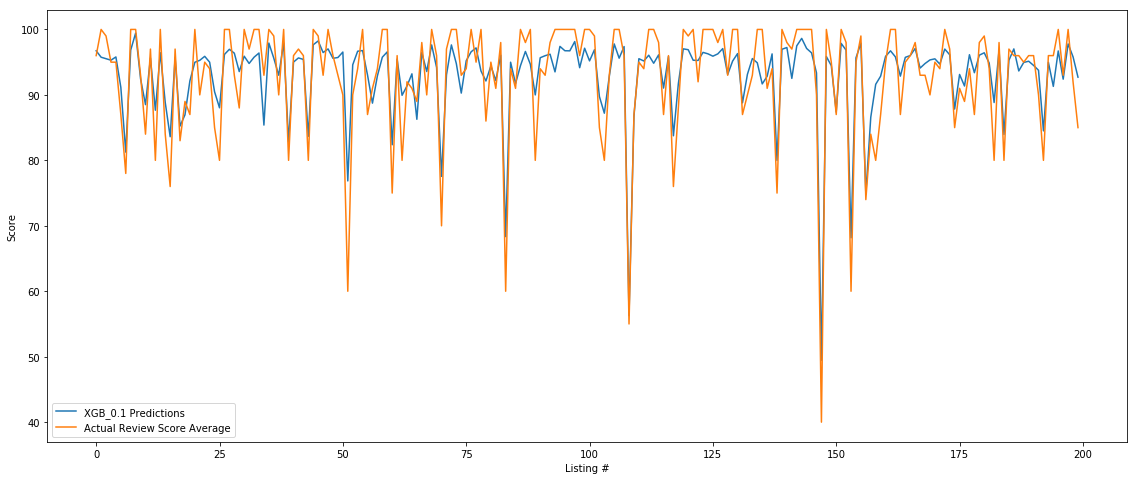

In [16]:
fig5 = plt.figure(figsize=(15,6))
ax5 = fig5.add_axes([0,0,1,1])
ax5.plot(yhat_test[0:200], label='XGB_0.1 Predictions')
ax5.plot(y_test[0:200].reset_index().drop('index',axis=1),label='Actual Review Score Average')
ax5.legend()
ax5.set_ylabel('Score')
ax5.set_xlabel('Listing #')
## Save figure
fig5.savefig('png/Yhat_xgbvsactual.png', bbox_inches='tight');